In [1]:
from torch.utils.data import DataLoader
from utils import *
from matplotlib import pyplot
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
print(device)

cuda


In [3]:
torch.set_default_dtype(torch.float64)
# Okay, we kind of have a way of loading the data
# We need to collect the data and feed it to the transformer model
# Now how do we that ?


# Torch Tensor data !
path = './Datasets/intracardiac_dataset/'
VmTrainData, pECGTrainData, VmDataTest, pECGTestData  = fileReader(path, 3200)
print('Data loading from files - complete')

VmTrainData = (VmTrainData - torch.min(VmTrainData))/(torch.max(VmTrainData) - torch.min(VmTrainData))
pECGTrainData = (pECGTrainData - torch.min(pECGTrainData))/(torch.max(pECGTrainData) - torch.min(pECGTrainData))

VmDataTest = (VmDataTest - torch.min(VmDataTest))/(torch.max(VmDataTest) - torch.min(VmDataTest))

pECGTestData = (pECGTestData - torch.min(pECGTestData))/(torch.max(pECGTestData) - torch.min(pECGTestData))
print('Normalization - complete!')


Loading datafiles : 100%|██████████| 3200/3200 [00:01<00:00, 2253.66it/s]


Data loading from files - complete
Normalization - complete!


In [4]:
## Model parameters
dim_val = 512
n_heads = 2
n_decoder_layers = 2
n_encoder_layers = 2
input_size = 12
dec_seq_len = 10 
enc_seq_len = 2
output_sequence_length = 2
max_seq_len = enc_seq_len
train_batch_size = 32
test_batch_size = 10
batch_first= False
output_size = 75

In [5]:
from dataset import TransformerDataset
# Get the indices of the sequences
# The idea is: start - stop, where stop - start is window_size
# This means, each tuple in VmInd and pECGInd is 50 steps
datInd = get_indices_entire_sequence(VmData = VmTrainData, 
                                            ECGData = pECGTrainData, 
                                            window_size= enc_seq_len + output_sequence_length, 
                                            step_size = 1)

# Now let's collect the training data in the Transformer Dataset class
TrainData = TransformerDataset(VmData = VmTrainData,
                                    datInd=datInd,
                                    ECGData = pECGTrainData,
                                    enc_seq_len = enc_seq_len,
                                    dec_seq_len = dec_seq_len,
                                    target_seq_len = output_sequence_length
                                )


TrainData = DataLoader(TrainData, train_batch_size)

datInd = get_indices_entire_sequence(VmData = VmDataTest, 
                                            ECGData = pECGTestData, 
                                            window_size= enc_seq_len + output_sequence_length, 
                                            step_size = 1)


# Now, let's load the test data
TestData = TransformerDataset(VmData = VmDataTest, 
                                    ECGData = pECGTestData,
                                    datInd=datInd,
                                    enc_seq_len = enc_seq_len,
                                    dec_seq_len = dec_seq_len,
                                    target_seq_len = output_sequence_length
                                )

TestData = DataLoader(TestData, test_batch_size)


In [6]:
from models import TimeSeriesTransformer
model = TimeSeriesTransformer(
    dim_val=dim_val,
    batch_first=batch_first,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads,
    num_predicted_features=output_size
)

# Define the MSE loss
criterion = torch.nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)




In [7]:
EPOCHS = 500
for epoch in tqdm(range(EPOCHS), desc = 'Training ', unit='epochs'):
    batch = 0
    for src, trg, trg_y in tqdm(TrainData, unit = 'batches'):
        optimizer.zero_grad()
        
        # Do it for each step in the sequence and predict the loss
        seqLen = src.shape[2]
        loss = 0
        predList = []
        for i in range(seqLen):

            srciSeq = src[:, :, i, :]
            trgiSeq = trg[:, :, i, :]
            trg_yiSeq = trg_y[:, :, i, :]
            src_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=enc_seq_len
            )
            tgt_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=output_sequence_length
            )
            srciSeq = srciSeq.permute(1, 0, 2).to(device)
            trgiSeq = trgiSeq.permute(1, 0, 2).to(device)
            prediction = model(
                src=srciSeq,
                tgt=trgiSeq,
                src_mask=src_mask,
                tgt_mask=tgt_mask
            )
            
            predList.append(prediction.permute(1,0,2))
        
        loss = criterion(trg_y.to(device), torch.stack(predList, axis = 2).to(device))
        print("Epoch: {epoch}    sequence: {i}/{seqLen}    Loss: {loss}    batch: {batch}/{total_batches}".format(epoch=epoch+1, i=i+1, seqLen=seqLen, loss=loss.item(),batch=batch+1, total_batches=len(TrainData)))
        loss.backward()
        optimizer.step()

        batch+=1

    

Training :   0%|          | 0/500 [00:00<?, ?epochs/s]

Epoch: 1    sequence: 496/496    Loss: 0.5598916082350556    batch: 1/16


Epoch: 1    sequence: 496/496    Loss: 0.22992123778478193    batch: 2/16


Epoch: 1    sequence: 496/496    Loss: 0.19848792283201164    batch: 3/16


Epoch: 1    sequence: 496/496    Loss: 0.18089665437671684    batch: 4/16


Epoch: 1    sequence: 496/496    Loss: 0.15252315940523264    batch: 5/16


Epoch: 1    sequence: 496/496    Loss: 0.13721504706967924    batch: 6/16


Epoch: 1    sequence: 496/496    Loss: 0.11171696828489094    batch: 7/16


Epoch: 1    sequence: 496/496    Loss: 0.09430537777045267    batch: 8/16


Epoch: 1    sequence: 496/496    Loss: 0.08758434094471644    batch: 9/16


Epoch: 1    sequence: 496/496    Loss: 0.08295560535317245    batch: 10/16


Epoch: 1    sequence: 496/496    Loss: 0.08440361425272531    batch: 11/16


Epoch: 1    sequence: 496/496    Loss: 0.08096694259700019    batch: 12/16


Epoch: 1    sequence: 496/496    Loss: 0.08215735106971955    batch: 13/16


Epoch: 1    sequence: 496/496    Loss: 0.07007386419283644    batch: 14/16


Epoch: 1    sequence: 496/496    Loss: 0.06846564857968925    batch: 15/16


Epoch: 1    sequence: 496/496    Loss: 0.07210592808719156    batch: 16/16


Training :   0%|          | 1/500 [02:23<19:52:46, 143.42s/epochs]

Epoch: 2    sequence: 496/496    Loss: 0.05141095318412545    batch: 1/16


Epoch: 2    sequence: 496/496    Loss: 0.06501527315422384    batch: 2/16


Epoch: 2    sequence: 496/496    Loss: 0.05935884338066588    batch: 3/16


Epoch: 2    sequence: 496/496    Loss: 0.05370308338240318    batch: 4/16


Epoch: 2    sequence: 496/496    Loss: 0.051185116792551416    batch: 5/16


Epoch: 2    sequence: 496/496    Loss: 0.04828422844334107    batch: 6/16


Epoch: 2    sequence: 496/496    Loss: 0.04421715888372769    batch: 7/16


Epoch: 2    sequence: 496/496    Loss: 0.040611552055351996    batch: 8/16


Epoch: 2    sequence: 496/496    Loss: 0.03779868964251731    batch: 9/16


Epoch: 2    sequence: 496/496    Loss: 0.04233328350492887    batch: 10/16


Epoch: 2    sequence: 496/496    Loss: 0.05368197731062419    batch: 11/16


Epoch: 2    sequence: 496/496    Loss: 0.04880586378027036    batch: 12/16


Epoch: 2    sequence: 496/496    Loss: 0.048748098483110486    batch: 13/16


Epoch: 2    sequence: 496/496    Loss: 0.05122302202624459    batch: 14/16


Epoch: 2    sequence: 496/496    Loss: 0.05657479264683413    batch: 15/16


Epoch: 2    sequence: 496/496    Loss: 0.06126418896830312    batch: 16/16


Training :   0%|          | 2/500 [04:47<19:52:22, 143.66s/epochs]

Epoch: 3    sequence: 496/496    Loss: 0.04190682709555041    batch: 1/16


Epoch: 3    sequence: 496/496    Loss: 0.05798209939150966    batch: 2/16


Epoch: 3    sequence: 496/496    Loss: 0.04306048203500697    batch: 3/16


Epoch: 3    sequence: 496/496    Loss: 0.04520497160317387    batch: 4/16


Epoch: 3    sequence: 496/496    Loss: 0.04256379294374979    batch: 5/16


Epoch: 3    sequence: 496/496    Loss: 0.03925935584094371    batch: 6/16


Epoch: 3    sequence: 496/496    Loss: 0.039059863870849885    batch: 7/16


Epoch: 3    sequence: 496/496    Loss: 0.03678170064286908    batch: 8/16


Epoch: 3    sequence: 496/496    Loss: 0.03260625415328786    batch: 9/16


Epoch: 3    sequence: 496/496    Loss: 0.03471928846804631    batch: 10/16


Epoch: 3    sequence: 496/496    Loss: 0.04577327940818269    batch: 11/16


Epoch: 3    sequence: 496/496    Loss: 0.038243456964754306    batch: 12/16


Epoch: 3    sequence: 496/496    Loss: 0.04464739741544738    batch: 13/16


Epoch: 3    sequence: 496/496    Loss: 0.03657988278073496    batch: 14/16


Epoch: 3    sequence: 496/496    Loss: 0.04038221628835008    batch: 15/16


Epoch: 3    sequence: 496/496    Loss: 0.04283267289301849    batch: 16/16


Training :   1%|          | 3/500 [07:11<19:51:29, 143.84s/epochs]

Epoch: 4    sequence: 496/496    Loss: 0.0330061544736416    batch: 1/16


Epoch: 4    sequence: 496/496    Loss: 0.04101928299648251    batch: 2/16


Epoch: 4    sequence: 496/496    Loss: 0.03797801036706054    batch: 3/16


Epoch: 4    sequence: 496/496    Loss: 0.034631125439649545    batch: 4/16


Epoch: 4    sequence: 496/496    Loss: 0.031026450689180713    batch: 5/16


Epoch: 4    sequence: 496/496    Loss: 0.03249392114283467    batch: 6/16


Epoch: 4    sequence: 496/496    Loss: 0.030901737321379494    batch: 7/16


Epoch: 4    sequence: 496/496    Loss: 0.028139145896881136    batch: 8/16


Epoch: 4    sequence: 496/496    Loss: 0.02701559422568237    batch: 9/16


Epoch: 4    sequence: 496/496    Loss: 0.027721308592034245    batch: 10/16


Epoch: 4    sequence: 496/496    Loss: 0.03721460135844369    batch: 11/16


Epoch: 4    sequence: 496/496    Loss: 0.033006595440332374    batch: 12/16


Epoch: 4    sequence: 496/496    Loss: 0.036186233724166815    batch: 13/16


Epoch: 4    sequence: 496/496    Loss: 0.031506870442117925    batch: 14/16


Epoch: 4    sequence: 496/496    Loss: 0.03476181474539238    batch: 15/16


Epoch: 4    sequence: 496/496    Loss: 0.035646745017202046    batch: 16/16


Training :   1%|          | 4/500 [09:35<19:48:51, 143.81s/epochs]

Epoch: 5    sequence: 496/496    Loss: 0.029095615331198584    batch: 1/16


Epoch: 5    sequence: 496/496    Loss: 0.03498925521923811    batch: 2/16


Epoch: 5    sequence: 496/496    Loss: 0.03294609704829834    batch: 3/16


Epoch: 5    sequence: 496/496    Loss: 0.03012734129380281    batch: 4/16


Epoch: 5    sequence: 496/496    Loss: 0.02666143451730076    batch: 5/16


Epoch: 5    sequence: 496/496    Loss: 0.02840053338369762    batch: 6/16


Epoch: 5    sequence: 496/496    Loss: 0.026977291577774648    batch: 7/16


Epoch: 5    sequence: 496/496    Loss: 0.02509649326144285    batch: 8/16


Epoch: 5    sequence: 496/496    Loss: 0.023832886178485883    batch: 9/16


Epoch: 5    sequence: 496/496    Loss: 0.02449494124130731    batch: 10/16


Epoch: 5    sequence: 496/496    Loss: 0.032680291282024376    batch: 11/16


Epoch: 5    sequence: 496/496    Loss: 0.02936826282347611    batch: 12/16


Epoch: 5    sequence: 496/496    Loss: 0.031688290461340925    batch: 13/16


Epoch: 5    sequence: 496/496    Loss: 0.02757097412066948    batch: 14/16


Epoch: 5    sequence: 496/496    Loss: 0.030899306508759602    batch: 15/16


Epoch: 5    sequence: 496/496    Loss: 0.03125022335918185    batch: 16/16


Training :   1%|          | 5/500 [11:59<19:47:03, 143.89s/epochs]

Epoch: 6    sequence: 496/496    Loss: 0.0262489792665537    batch: 1/16


Epoch: 6    sequence: 496/496    Loss: 0.03058122114488473    batch: 2/16


Epoch: 6    sequence: 496/496    Loss: 0.029515772000167848    batch: 3/16


Epoch: 6    sequence: 496/496    Loss: 0.02775108188775652    batch: 4/16


Epoch: 6    sequence: 496/496    Loss: 0.024173664535031718    batch: 5/16


Epoch: 6    sequence: 496/496    Loss: 0.02579042247313506    batch: 6/16


Epoch: 6    sequence: 496/496    Loss: 0.02461540095036613    batch: 7/16


Epoch: 6    sequence: 496/496    Loss: 0.023243010183954887    batch: 8/16


Epoch: 6    sequence: 496/496    Loss: 0.021956760609448282    batch: 9/16


Epoch: 6    sequence: 496/496    Loss: 0.022356600821895906    batch: 10/16


Epoch: 6    sequence: 496/496    Loss: 0.029957501076663236    batch: 11/16


Epoch: 6    sequence: 496/496    Loss: 0.026882859217554688    batch: 12/16


Epoch: 6    sequence: 496/496    Loss: 0.028759855240300065    batch: 13/16


Epoch: 6    sequence: 496/496    Loss: 0.02524034416386669    batch: 14/16


Epoch: 6    sequence: 496/496    Loss: 0.02840421586228967    batch: 15/16


Epoch: 6    sequence: 496/496    Loss: 0.02952381554053214    batch: 16/16


Training :   1%|          | 6/500 [14:23<19:44:46, 143.90s/epochs]

Epoch: 7    sequence: 496/496    Loss: 0.026017682460398855    batch: 1/16


Epoch: 7    sequence: 496/496    Loss: 0.034282365652045454    batch: 2/16


Epoch: 7    sequence: 496/496    Loss: 0.02838839401426701    batch: 3/16


Epoch: 7    sequence: 496/496    Loss: 0.038482532752865055    batch: 4/16


Epoch: 7    sequence: 496/496    Loss: 0.04547893207459636    batch: 5/16


Epoch: 7    sequence: 496/496    Loss: 0.045019226801482695    batch: 6/16


Epoch: 7    sequence: 496/496    Loss: 0.040859927807118605    batch: 7/16


Epoch: 7    sequence: 496/496    Loss: 0.03407997607839626    batch: 8/16


Epoch: 7    sequence: 496/496    Loss: 0.03236090631172359    batch: 9/16


Epoch: 7    sequence: 496/496    Loss: 0.036993012350725024    batch: 10/16


Epoch: 7    sequence: 496/496    Loss: 0.04062651815689829    batch: 11/16


Epoch: 7    sequence: 496/496    Loss: 0.03376664087066423    batch: 12/16


Epoch: 7    sequence: 496/496    Loss: 0.034882823406620994    batch: 13/16


Epoch: 7    sequence: 496/496    Loss: 0.031210185804967726    batch: 14/16


Epoch: 7    sequence: 496/496    Loss: 0.03316511504706526    batch: 15/16


Epoch: 7    sequence: 496/496    Loss: 0.031609999844840864    batch: 16/16


Training :   1%|▏         | 7/500 [16:46<19:42:26, 143.91s/epochs]

Epoch: 8    sequence: 496/496    Loss: 0.029176074158895577    batch: 1/16


Epoch: 8    sequence: 496/496    Loss: 0.03129802304252639    batch: 2/16


Epoch: 8    sequence: 496/496    Loss: 0.029299175430753523    batch: 3/16


Epoch: 8    sequence: 496/496    Loss: 0.028175619168526737    batch: 4/16


Epoch: 8    sequence: 496/496    Loss: 0.024550823986285036    batch: 5/16


Epoch: 8    sequence: 496/496    Loss: 0.02535807941689981    batch: 6/16


Epoch: 8    sequence: 496/496    Loss: 0.024588811036659088    batch: 7/16


Epoch: 8    sequence: 496/496    Loss: 0.022993499859517482    batch: 8/16


Epoch: 8    sequence: 496/496    Loss: 0.020620512257165085    batch: 9/16


Epoch: 8    sequence: 496/496    Loss: 0.019865193828481096    batch: 10/16


Epoch: 8    sequence: 496/496    Loss: 0.025556736499864858    batch: 11/16


Epoch: 8    sequence: 496/496    Loss: 0.023504898983838823    batch: 12/16


Epoch: 8    sequence: 496/496    Loss: 0.023219555527522313    batch: 13/16


Epoch: 8    sequence: 496/496    Loss: 0.019734477586234825    batch: 14/16


Epoch: 8    sequence: 496/496    Loss: 0.022175227535533682    batch: 15/16


Epoch: 8    sequence: 496/496    Loss: 0.022455036902106068    batch: 16/16


Training :   2%|▏         | 8/500 [19:10<19:39:47, 143.88s/epochs]

Epoch: 9    sequence: 496/496    Loss: 0.018630864507333374    batch: 1/16


Epoch: 9    sequence: 496/496    Loss: 0.02189976565376608    batch: 2/16


Epoch: 9    sequence: 496/496    Loss: 0.020851234483132832    batch: 3/16


Epoch: 9    sequence: 496/496    Loss: 0.01954660821881454    batch: 4/16


Epoch: 9    sequence: 496/496    Loss: 0.016701692076954978    batch: 5/16


Epoch: 9    sequence: 496/496    Loss: 0.017374990566406064    batch: 6/16


Epoch: 9    sequence: 496/496    Loss: 0.01654165432168653    batch: 7/16


Epoch: 9    sequence: 496/496    Loss: 0.015561047148905568    batch: 8/16


Epoch: 9    sequence: 496/496    Loss: 0.01452959724540414    batch: 9/16


Epoch: 9    sequence: 496/496    Loss: 0.014363225068955794    batch: 10/16


Epoch: 9    sequence: 496/496    Loss: 0.019572627936800202    batch: 11/16


Epoch: 9    sequence: 496/496    Loss: 0.017329159045690105    batch: 12/16


Epoch: 9    sequence: 496/496    Loss: 0.018360895891153195    batch: 13/16


Epoch: 9    sequence: 496/496    Loss: 0.01572109052791011    batch: 14/16


Epoch: 9    sequence: 496/496    Loss: 0.01740808349143558    batch: 15/16


Epoch: 9    sequence: 496/496    Loss: 0.017629748918751093    batch: 16/16


Training :   2%|▏         | 9/500 [21:34<19:37:39, 143.91s/epochs]

Epoch: 10    sequence: 496/496    Loss: 0.014837347242472937    batch: 1/16


Epoch: 10    sequence: 496/496    Loss: 0.017166738751655957    batch: 2/16


Epoch: 10    sequence: 496/496    Loss: 0.01677683219599668    batch: 3/16


Epoch: 10    sequence: 496/496    Loss: 0.01555983737122776    batch: 4/16


Epoch: 10    sequence: 496/496    Loss: 0.01332435082460423    batch: 5/16


Epoch: 10    sequence: 496/496    Loss: 0.014171344519454924    batch: 6/16


Epoch: 10    sequence: 496/496    Loss: 0.013355892106159655    batch: 7/16


Epoch: 10    sequence: 496/496    Loss: 0.012750755957824444    batch: 8/16


Epoch: 10    sequence: 496/496    Loss: 0.0119252244273566    batch: 9/16


Epoch: 10    sequence: 496/496    Loss: 0.01176066360511242    batch: 10/16


Epoch: 10    sequence: 496/496    Loss: 0.01585489544549993    batch: 11/16


Epoch: 10    sequence: 496/496    Loss: 0.014195236899835068    batch: 12/16


Epoch: 10    sequence: 496/496    Loss: 0.014827589781844144    batch: 13/16


Epoch: 10    sequence: 496/496    Loss: 0.012904480042648063    batch: 14/16


Epoch: 10    sequence: 496/496    Loss: 0.014459462580073336    batch: 15/16


Epoch: 10    sequence: 496/496    Loss: 0.014019384663349663    batch: 16/16


Training :   2%|▏         | 10/500 [23:58<19:35:01, 143.88s/epochs]

Epoch: 11    sequence: 496/496    Loss: 0.012197518225531905    batch: 1/16


Epoch: 11    sequence: 496/496    Loss: 0.014115886168893638    batch: 2/16


Epoch: 11    sequence: 496/496    Loss: 0.01353961397430244    batch: 3/16


Epoch: 11    sequence: 496/496    Loss: 0.01296625032787952    batch: 4/16


Epoch: 11    sequence: 496/496    Loss: 0.011136053852927267    batch: 5/16


Epoch: 11    sequence: 496/496    Loss: 0.011652337751323238    batch: 6/16


Epoch: 11    sequence: 496/496    Loss: 0.011172631002897922    batch: 7/16


Epoch: 11    sequence: 496/496    Loss: 0.010715486166499366    batch: 8/16


Epoch: 11    sequence: 496/496    Loss: 0.009986727528862099    batch: 9/16


Epoch: 11    sequence: 496/496    Loss: 0.00987067135460464    batch: 10/16


Epoch: 11    sequence: 496/496    Loss: 0.013131263878220133    batch: 11/16


Epoch: 11    sequence: 496/496    Loss: 0.01208816111821644    batch: 12/16


Epoch: 11    sequence: 496/496    Loss: 0.012424659359760786    batch: 13/16


Epoch: 11    sequence: 496/496    Loss: 0.010723309040772212    batch: 14/16


Epoch: 11    sequence: 496/496    Loss: 0.011931031703784045    batch: 15/16


Epoch: 11    sequence: 496/496    Loss: 0.011519778449504414    batch: 16/16


Training :   2%|▏         | 11/500 [26:22<19:32:46, 143.90s/epochs]

Epoch: 12    sequence: 496/496    Loss: 0.010235163015463717    batch: 1/16


Epoch: 12    sequence: 496/496    Loss: 0.011704970609933512    batch: 2/16


Epoch: 12    sequence: 496/496    Loss: 0.011205366171851933    batch: 3/16


Epoch: 12    sequence: 496/496    Loss: 0.010769348739643468    batch: 4/16


Epoch: 12    sequence: 496/496    Loss: 0.00917922189373899    batch: 5/16


Epoch: 12    sequence: 496/496    Loss: 0.009803117943350379    batch: 6/16


Epoch: 12    sequence: 496/496    Loss: 0.009256277890199645    batch: 7/16


Epoch: 12    sequence: 496/496    Loss: 0.008829026960779017    batch: 8/16


Epoch: 12    sequence: 496/496    Loss: 0.00820607725212096    batch: 9/16


Epoch: 12    sequence: 496/496    Loss: 0.00817865661839859    batch: 10/16


Epoch: 12    sequence: 496/496    Loss: 0.01070262044725659    batch: 11/16


Epoch: 12    sequence: 496/496    Loss: 0.009574171223396136    batch: 12/16


Epoch: 12    sequence: 496/496    Loss: 0.010097947735569353    batch: 13/16


Epoch: 12    sequence: 496/496    Loss: 0.009313417411139068    batch: 14/16


Epoch: 12    sequence: 496/496    Loss: 0.010696384140696284    batch: 15/16


Epoch: 12    sequence: 496/496    Loss: 0.010690356116526512    batch: 16/16


Training :   2%|▏         | 12/500 [28:46<19:30:45, 143.95s/epochs]

Epoch: 13    sequence: 496/496    Loss: 0.008713969454313592    batch: 1/16


Epoch: 13    sequence: 496/496    Loss: 0.009565845335043382    batch: 2/16


Epoch: 13    sequence: 496/496    Loss: 0.009679921605642815    batch: 3/16


Epoch: 13    sequence: 496/496    Loss: 0.009337614178319402    batch: 4/16


Epoch: 13    sequence: 496/496    Loss: 0.007722116698527968    batch: 5/16


Epoch: 13    sequence: 496/496    Loss: 0.007957452757167437    batch: 6/16


Epoch: 13    sequence: 496/496    Loss: 0.007807120359151731    batch: 7/16


Epoch: 13    sequence: 496/496    Loss: 0.007509462761961795    batch: 8/16


Epoch: 13    sequence: 496/496    Loss: 0.006896720783078386    batch: 9/16


Epoch: 13    sequence: 496/496    Loss: 0.00672627413535582    batch: 10/16


Epoch: 13    sequence: 496/496    Loss: 0.008953992202323357    batch: 11/16


Epoch: 13    sequence: 496/496    Loss: 0.007920694271408804    batch: 12/16


Epoch: 13    sequence: 496/496    Loss: 0.008416034530074137    batch: 13/16


Epoch: 13    sequence: 496/496    Loss: 0.007714224723951079    batch: 14/16


Epoch: 13    sequence: 496/496    Loss: 0.00866602381874517    batch: 15/16


Epoch: 13    sequence: 496/496    Loss: 0.008092299311822131    batch: 16/16


Training :   3%|▎         | 13/500 [31:10<19:28:23, 143.95s/epochs]

Epoch: 14    sequence: 496/496    Loss: 0.006949043097818521    batch: 1/16


Epoch: 14    sequence: 496/496    Loss: 0.008104965031446438    batch: 2/16


Epoch: 14    sequence: 496/496    Loss: 0.008165862458642684    batch: 3/16


Epoch: 14    sequence: 496/496    Loss: 0.007476238826156186    batch: 4/16


Epoch: 14    sequence: 496/496    Loss: 0.006287850941566149    batch: 5/16


Epoch: 14    sequence: 496/496    Loss: 0.006880399850410365    batch: 6/16


Epoch: 14    sequence: 496/496    Loss: 0.006410629387441024    batch: 7/16


Epoch: 14    sequence: 496/496    Loss: 0.006014167288114544    batch: 8/16


Epoch: 14    sequence: 496/496    Loss: 0.005772295914686346    batch: 9/16


Epoch: 14    sequence: 496/496    Loss: 0.005778580132916402    batch: 10/16


Epoch: 14    sequence: 496/496    Loss: 0.007562568494891944    batch: 11/16


Epoch: 14    sequence: 496/496    Loss: 0.0066581494976045725    batch: 12/16


Epoch: 14    sequence: 496/496    Loss: 0.007295645180288144    batch: 13/16


Epoch: 14    sequence: 496/496    Loss: 0.0069962676280859015    batch: 14/16


Epoch: 14    sequence: 496/496    Loss: 0.007125853139749949    batch: 15/16


Epoch: 14    sequence: 496/496    Loss: 0.006518886317474952    batch: 16/16


Training :   3%|▎         | 14/500 [33:34<19:25:40, 143.91s/epochs]

Epoch: 15    sequence: 496/496    Loss: 0.006115934441867146    batch: 1/16


Epoch: 15    sequence: 496/496    Loss: 0.006833135712606467    batch: 2/16


Epoch: 15    sequence: 496/496    Loss: 0.006426787675050797    batch: 3/16


Epoch: 15    sequence: 496/496    Loss: 0.006301028671128433    batch: 4/16


Epoch: 15    sequence: 496/496    Loss: 0.005446349783068529    batch: 5/16


Epoch: 15    sequence: 496/496    Loss: 0.005560215481558301    batch: 6/16


Epoch: 15    sequence: 496/496    Loss: 0.005347010374497743    batch: 7/16


Epoch: 15    sequence: 496/496    Loss: 0.005251816521016536    batch: 8/16


Epoch: 15    sequence: 496/496    Loss: 0.005097573474890341    batch: 9/16


Epoch: 15    sequence: 496/496    Loss: 0.004798655603812657    batch: 10/16


Epoch: 15    sequence: 496/496    Loss: 0.006384886747606883    batch: 11/16


Epoch: 15    sequence: 496/496    Loss: 0.006082183610845495    batch: 12/16


Epoch: 15    sequence: 496/496    Loss: 0.00648881908737706    batch: 13/16


Epoch: 15    sequence: 496/496    Loss: 0.005558082386101981    batch: 14/16


Epoch: 15    sequence: 496/496    Loss: 0.005850849465891542    batch: 15/16


Epoch: 15    sequence: 496/496    Loss: 0.005632002120093231    batch: 16/16


Training :   3%|▎         | 15/500 [35:57<19:22:36, 143.83s/epochs]

Epoch: 16    sequence: 496/496    Loss: 0.0052137119231611025    batch: 1/16


Epoch: 16    sequence: 496/496    Loss: 0.005746265670460559    batch: 2/16


Epoch: 16    sequence: 496/496    Loss: 0.005538724107998669    batch: 3/16


Epoch: 16    sequence: 496/496    Loss: 0.00544509528281252    batch: 4/16


Epoch: 16    sequence: 496/496    Loss: 0.0045574299325315945    batch: 5/16


Epoch: 16    sequence: 496/496    Loss: 0.004795506819742003    batch: 6/16


Epoch: 16    sequence: 496/496    Loss: 0.0047189374203593926    batch: 7/16


Epoch: 16    sequence: 496/496    Loss: 0.004537880414403132    batch: 8/16


Epoch: 16    sequence: 496/496    Loss: 0.004230270552861773    batch: 9/16


Epoch: 16    sequence: 496/496    Loss: 0.004144146521412229    batch: 10/16


Epoch: 16    sequence: 496/496    Loss: 0.005563544705174774    batch: 11/16


Epoch: 16    sequence: 496/496    Loss: 0.005245644283642906    batch: 12/16


Epoch: 16    sequence: 496/496    Loss: 0.005659121520759465    batch: 13/16


Epoch: 16    sequence: 496/496    Loss: 0.005067543992879971    batch: 14/16


Epoch: 16    sequence: 496/496    Loss: 0.005231217917992748    batch: 15/16


Epoch: 16    sequence: 496/496    Loss: 0.004934129330789081    batch: 16/16


Training :   3%|▎         | 16/500 [38:21<19:19:19, 143.72s/epochs]

Epoch: 17    sequence: 496/496    Loss: 0.00453692982315149    batch: 1/16


Epoch: 17    sequence: 496/496    Loss: 0.0051319032800761395    batch: 2/16


Epoch: 17    sequence: 496/496    Loss: 0.004830432021922813    batch: 3/16


Epoch: 17    sequence: 496/496    Loss: 0.004741233791099237    batch: 4/16


Epoch: 17    sequence: 496/496    Loss: 0.004046489214793142    batch: 5/16


Epoch: 17    sequence: 496/496    Loss: 0.004258950116489181    batch: 6/16


Epoch: 17    sequence: 496/496    Loss: 0.004063841695921625    batch: 7/16


Epoch: 17    sequence: 496/496    Loss: 0.003990705949509544    batch: 8/16


Epoch: 17    sequence: 496/496    Loss: 0.0038881767126371578    batch: 9/16


Epoch: 17    sequence: 496/496    Loss: 0.003782382331402225    batch: 10/16


Epoch: 17    sequence: 496/496    Loss: 0.004978721655276059    batch: 11/16


Epoch: 17    sequence: 496/496    Loss: 0.004463572583624966    batch: 12/16


Epoch: 17    sequence: 496/496    Loss: 0.005041348358996481    batch: 13/16


Epoch: 17    sequence: 496/496    Loss: 0.004922066098845037    batch: 14/16


Epoch: 17    sequence: 496/496    Loss: 0.004914061261814841    batch: 15/16


Epoch: 17    sequence: 496/496    Loss: 0.004411353983537158    batch: 16/16


Training :   3%|▎         | 17/500 [40:44<19:16:24, 143.65s/epochs]

Epoch: 18    sequence: 496/496    Loss: 0.004075546335798792    batch: 1/16


Epoch: 18    sequence: 496/496    Loss: 0.004643277275399124    batch: 2/16


Epoch: 18    sequence: 496/496    Loss: 0.004356081384674411    batch: 3/16


Epoch: 18    sequence: 496/496    Loss: 0.004260626214317882    batch: 4/16


Epoch: 18    sequence: 496/496    Loss: 0.003669129476582412    batch: 5/16


Epoch: 18    sequence: 496/496    Loss: 0.0038581991499813044    batch: 6/16


Epoch: 18    sequence: 496/496    Loss: 0.0036645484275775347    batch: 7/16


Epoch: 18    sequence: 496/496    Loss: 0.0036288633117271454    batch: 8/16


Epoch: 18    sequence: 496/496    Loss: 0.0035124003385232005    batch: 9/16


Epoch: 18    sequence: 496/496    Loss: 0.0033723949648510223    batch: 10/16


Epoch: 18    sequence: 496/496    Loss: 0.004481515056345834    batch: 11/16


Epoch: 18    sequence: 496/496    Loss: 0.004164236610953101    batch: 12/16


Epoch: 18    sequence: 496/496    Loss: 0.0046174463933342305    batch: 13/16


Epoch: 18    sequence: 496/496    Loss: 0.004250805164707607    batch: 14/16


Epoch: 18    sequence: 496/496    Loss: 0.004333747353760885    batch: 15/16


Epoch: 18    sequence: 496/496    Loss: 0.003980309668311947    batch: 16/16


Training :   4%|▎         | 18/500 [43:08<19:13:26, 143.58s/epochs]

Epoch: 19    sequence: 496/496    Loss: 0.003636882422460393    batch: 1/16


Epoch: 19    sequence: 496/496    Loss: 0.0041902551870986165    batch: 2/16


Epoch: 19    sequence: 496/496    Loss: 0.003963750529118995    batch: 3/16


Epoch: 19    sequence: 496/496    Loss: 0.0038159127321435466    batch: 4/16


Epoch: 19    sequence: 496/496    Loss: 0.0033211404258347505    batch: 5/16


Epoch: 19    sequence: 496/496    Loss: 0.0034994927043491635    batch: 6/16


Epoch: 19    sequence: 496/496    Loss: 0.0033125484065078684    batch: 7/16


Epoch: 19    sequence: 496/496    Loss: 0.0032405385791760034    batch: 8/16


Epoch: 19    sequence: 496/496    Loss: 0.003202763217996447    batch: 9/16


Epoch: 19    sequence: 496/496    Loss: 0.0031708919081286416    batch: 10/16


Epoch: 19    sequence: 496/496    Loss: 0.004172785498174072    batch: 11/16


Epoch: 19    sequence: 496/496    Loss: 0.003666159553045887    batch: 12/16


Epoch: 19    sequence: 496/496    Loss: 0.004165582861678577    batch: 13/16


Epoch: 19    sequence: 496/496    Loss: 0.004213746098833276    batch: 14/16


Epoch: 19    sequence: 496/496    Loss: 0.0041969151045723255    batch: 15/16


Epoch: 19    sequence: 496/496    Loss: 0.003682408338445981    batch: 16/16


Training :   4%|▍         | 19/500 [45:31<19:11:12, 143.60s/epochs]

Epoch: 20    sequence: 496/496    Loss: 0.0033913195421012756    batch: 1/16


Epoch: 20    sequence: 496/496    Loss: 0.003982639192539921    batch: 2/16


Epoch: 20    sequence: 496/496    Loss: 0.0037123398192251814    batch: 3/16


Epoch: 20    sequence: 496/496    Loss: 0.0034910934172760616    batch: 4/16


Epoch: 20    sequence: 496/496    Loss: 0.0031040949940156957    batch: 5/16


Epoch: 20    sequence: 496/496    Loss: 0.0032446427579044595    batch: 6/16


Epoch: 20    sequence: 496/496    Loss: 0.003066611665160103    batch: 7/16


Epoch: 20    sequence: 496/496    Loss: 0.003057435400825265    batch: 8/16


Epoch: 20    sequence: 496/496    Loss: 0.0030153310900712105    batch: 9/16


Epoch: 20    sequence: 496/496    Loss: 0.0028559555915103796    batch: 10/16


Epoch: 20    sequence: 496/496    Loss: 0.0038018214097256123    batch: 11/16


Epoch: 20    sequence: 496/496    Loss: 0.0035881305151885573    batch: 12/16


Epoch: 20    sequence: 496/496    Loss: 0.00400104246002259    batch: 13/16


Epoch: 20    sequence: 496/496    Loss: 0.003605611801097224    batch: 14/16


Epoch: 20    sequence: 496/496    Loss: 0.003592621380711188    batch: 15/16


Epoch: 20    sequence: 496/496    Loss: 0.003434266981656071    batch: 16/16


Training :   4%|▍         | 20/500 [47:55<19:08:26, 143.55s/epochs]

Epoch: 21    sequence: 496/496    Loss: 0.0031706234611259213    batch: 1/16


Epoch: 21    sequence: 496/496    Loss: 0.003522066511374657    batch: 2/16


Epoch: 21    sequence: 496/496    Loss: 0.0033821026023797608    batch: 3/16


Epoch: 21    sequence: 496/496    Loss: 0.0033274433019349534    batch: 4/16


Epoch: 21    sequence: 496/496    Loss: 0.0027736803076097035    batch: 5/16


Epoch: 21    sequence: 496/496    Loss: 0.0029748411755061623    batch: 6/16


Epoch: 21    sequence: 496/496    Loss: 0.002927716886159352    batch: 7/16


Epoch: 21    sequence: 496/496    Loss: 0.00283024453736596    batch: 8/16


Epoch: 21    sequence: 496/496    Loss: 0.002642543907067421    batch: 9/16


Epoch: 21    sequence: 496/496    Loss: 0.0025767601993745386    batch: 10/16


Epoch: 21    sequence: 496/496    Loss: 0.003572585764864578    batch: 11/16


Epoch: 21    sequence: 496/496    Loss: 0.0034775089164490467    batch: 12/16


Epoch: 21    sequence: 496/496    Loss: 0.0037088843052191073    batch: 13/16


Epoch: 21    sequence: 496/496    Loss: 0.0032144042598180483    batch: 14/16


Epoch: 21    sequence: 496/496    Loss: 0.003331286521207241    batch: 15/16


Epoch: 21    sequence: 496/496    Loss: 0.003170921596592328    batch: 16/16


Training :   4%|▍         | 21/500 [50:18<19:05:41, 143.51s/epochs]

Epoch: 22    sequence: 496/496    Loss: 0.0028968315147092603    batch: 1/16


Epoch: 22    sequence: 496/496    Loss: 0.0032961076748148793    batch: 2/16


Epoch: 22    sequence: 496/496    Loss: 0.0031374956279729043    batch: 3/16


Epoch: 22    sequence: 496/496    Loss: 0.0030097673931073583    batch: 4/16


Epoch: 22    sequence: 496/496    Loss: 0.0025885473807790394    batch: 5/16


Epoch: 22    sequence: 496/496    Loss: 0.0027448600756639872    batch: 6/16


Epoch: 22    sequence: 496/496    Loss: 0.002644232191824743    batch: 7/16


Epoch: 22    sequence: 496/496    Loss: 0.0026023293250402304    batch: 8/16


Epoch: 22    sequence: 496/496    Loss: 0.0024980196636280178    batch: 9/16


Epoch: 22    sequence: 496/496    Loss: 0.002487568584958138    batch: 10/16


Epoch: 22    sequence: 496/496    Loss: 0.003287826068794963    batch: 11/16


Epoch: 22    sequence: 496/496    Loss: 0.002956483866339371    batch: 12/16


Epoch: 22    sequence: 496/496    Loss: 0.0033491420537438707    batch: 13/16


Epoch: 22    sequence: 496/496    Loss: 0.0032787403798707386    batch: 14/16


Epoch: 22    sequence: 496/496    Loss: 0.0034947002385609213    batch: 15/16


Epoch: 22    sequence: 496/496    Loss: 0.0031107558686430162    batch: 16/16


Training :   4%|▍         | 22/500 [52:42<19:02:47, 143.45s/epochs]

Epoch: 23    sequence: 496/496    Loss: 0.0026180312095724777    batch: 1/16


Epoch: 23    sequence: 496/496    Loss: 0.003247760113500913    batch: 2/16


Epoch: 23    sequence: 496/496    Loss: 0.0032204125086141987    batch: 3/16


Epoch: 23    sequence: 496/496    Loss: 0.002844449787131927    batch: 4/16


Epoch: 23    sequence: 496/496    Loss: 0.002493348773144893    batch: 5/16


Epoch: 23    sequence: 496/496    Loss: 0.0027442981396686708    batch: 6/16


Epoch: 23    sequence: 496/496    Loss: 0.0025137004926149412    batch: 7/16


Epoch: 23    sequence: 496/496    Loss: 0.002431484544614568    batch: 8/16


Epoch: 23    sequence: 496/496    Loss: 0.0024768362713678597    batch: 9/16


Epoch: 23    sequence: 496/496    Loss: 0.002435079058155981    batch: 10/16


Epoch: 23    sequence: 496/496    Loss: 0.0031115494807543317    batch: 11/16


Epoch: 23    sequence: 496/496    Loss: 0.0028611196115935268    batch: 12/16


Epoch: 23    sequence: 496/496    Loss: 0.0033231331853065525    batch: 13/16


Epoch: 23    sequence: 496/496    Loss: 0.0031828872876763837    batch: 14/16


Epoch: 23    sequence: 496/496    Loss: 0.0030386566579905607    batch: 15/16


Epoch: 23    sequence: 496/496    Loss: 0.0028443778011978445    batch: 16/16


Training :   5%|▍         | 23/500 [55:05<19:00:34, 143.47s/epochs]

Epoch: 24    sequence: 496/496    Loss: 0.002702456876608545    batch: 1/16


Epoch: 24    sequence: 496/496    Loss: 0.002986472383309045    batch: 2/16


Epoch: 24    sequence: 496/496    Loss: 0.002809523361024273    batch: 3/16


Epoch: 24    sequence: 496/496    Loss: 0.0027855746105127513    batch: 4/16


Epoch: 24    sequence: 496/496    Loss: 0.002324312295813128    batch: 5/16


Epoch: 24    sequence: 496/496    Loss: 0.0024778843405581733    batch: 6/16


Epoch: 24    sequence: 496/496    Loss: 0.00242881481817618    batch: 7/16


Epoch: 24    sequence: 496/496    Loss: 0.002368734732100338    batch: 8/16


Epoch: 24    sequence: 496/496    Loss: 0.0022237758957929657    batch: 9/16


Epoch: 24    sequence: 496/496    Loss: 0.0021621237146020756    batch: 10/16


Epoch: 24    sequence: 496/496    Loss: 0.002952054536553601    batch: 11/16


Epoch: 24    sequence: 496/496    Loss: 0.002852301342294862    batch: 12/16


Epoch: 24    sequence: 496/496    Loss: 0.003110166104732433    batch: 13/16


Epoch: 24    sequence: 496/496    Loss: 0.0027340481106189946    batch: 14/16


Epoch: 24    sequence: 496/496    Loss: 0.002795935226821054    batch: 15/16


Epoch: 24    sequence: 496/496    Loss: 0.0027023736951305856    batch: 16/16


Training :   5%|▍         | 24/500 [57:29<18:57:54, 143.43s/epochs]

Epoch: 25    sequence: 496/496    Loss: 0.00244572172573168    batch: 1/16


Epoch: 25    sequence: 496/496    Loss: 0.002812745757146476    batch: 2/16


Epoch: 25    sequence: 496/496    Loss: 0.0026528338321313624    batch: 3/16


Epoch: 25    sequence: 496/496    Loss: 0.0025660188353411805    batch: 4/16


Epoch: 25    sequence: 496/496    Loss: 0.0021768008858235365    batch: 5/16


Epoch: 25    sequence: 496/496    Loss: 0.0023238582742378467    batch: 6/16


Epoch: 25    sequence: 496/496    Loss: 0.002255174011578859    batch: 7/16


Epoch: 25    sequence: 496/496    Loss: 0.002193818324043671    batch: 8/16


Epoch: 25    sequence: 496/496    Loss: 0.002093707860677291    batch: 9/16


Epoch: 25    sequence: 496/496    Loss: 0.002079708157142969    batch: 10/16


Epoch: 25    sequence: 496/496    Loss: 0.0027405095071215994    batch: 11/16


Epoch: 25    sequence: 496/496    Loss: 0.002574160881612999    batch: 12/16


Epoch: 25    sequence: 496/496    Loss: 0.0029589664092657874    batch: 13/16


Epoch: 25    sequence: 496/496    Loss: 0.002944947145477241    batch: 14/16


Epoch: 25    sequence: 496/496    Loss: 0.0029006484788933187    batch: 15/16


Epoch: 25    sequence: 496/496    Loss: 0.002541692794435366    batch: 16/16


Training :   5%|▌         | 25/500 [59:52<18:56:05, 143.51s/epochs]

Epoch: 26    sequence: 496/496    Loss: 0.002308904578178197    batch: 1/16


Epoch: 26    sequence: 496/496    Loss: 0.0027855941509268593    batch: 2/16


Epoch: 26    sequence: 496/496    Loss: 0.002604441844982505    batch: 3/16


Epoch: 26    sequence: 496/496    Loss: 0.0024138806963778154    batch: 4/16


Epoch: 26    sequence: 496/496    Loss: 0.002128245276213914    batch: 5/16


Epoch: 26    sequence: 496/496    Loss: 0.00227920959646478    batch: 6/16


Epoch: 26    sequence: 496/496    Loss: 0.0021285952813547082    batch: 7/16


Epoch: 26    sequence: 496/496    Loss: 0.0020967264625677104    batch: 8/16


Epoch: 26    sequence: 496/496    Loss: 0.002076612150358714    batch: 9/16


Epoch: 26    sequence: 496/496    Loss: 0.002030256149527366    batch: 10/16


Epoch: 26    sequence: 496/496    Loss: 0.002646821409079681    batch: 11/16


Epoch: 26    sequence: 496/496    Loss: 0.0024538950203420273    batch: 12/16


Epoch: 26    sequence: 496/496    Loss: 0.0028390923882067654    batch: 13/16


Epoch: 26    sequence: 496/496    Loss: 0.002723558800775742    batch: 14/16


Epoch: 26    sequence: 496/496    Loss: 0.0026587989219802387    batch: 15/16


Epoch: 26    sequence: 496/496    Loss: 0.0024295776698137128    batch: 16/16


Training :   5%|▌         | 26/500 [1:02:16<18:53:19, 143.46s/epochs]

Epoch: 27    sequence: 496/496    Loss: 0.0022752148628852604    batch: 1/16


Epoch: 27    sequence: 496/496    Loss: 0.0026158074182295746    batch: 2/16


Epoch: 27    sequence: 496/496    Loss: 0.002412472976078743    batch: 3/16


Epoch: 27    sequence: 496/496    Loss: 0.0023590285937807845    batch: 4/16


Epoch: 27    sequence: 496/496    Loss: 0.0020266465571392852    batch: 5/16


Epoch: 27    sequence: 496/496    Loss: 0.002156982317377625    batch: 6/16


Epoch: 27    sequence: 496/496    Loss: 0.002049151049102156    batch: 7/16


Epoch: 27    sequence: 496/496    Loss: 0.002046561210823735    batch: 8/16


Epoch: 27    sequence: 496/496    Loss: 0.002001217058702395    batch: 9/16


Epoch: 27    sequence: 496/496    Loss: 0.0019390531461968084    batch: 10/16


Epoch: 27    sequence: 496/496    Loss: 0.0025400052801445084    batch: 11/16


Epoch: 27    sequence: 496/496    Loss: 0.0023668004736434717    batch: 12/16


Epoch: 27    sequence: 496/496    Loss: 0.0027363066166450813    batch: 13/16


Epoch: 27    sequence: 496/496    Loss: 0.0026072315798628723    batch: 14/16


Epoch: 27    sequence: 496/496    Loss: 0.0025317785845893914    batch: 15/16


Epoch: 27    sequence: 496/496    Loss: 0.002333695930995563    batch: 16/16


Training :   5%|▌         | 27/500 [1:04:39<18:50:51, 143.45s/epochs]

Epoch: 28    sequence: 496/496    Loss: 0.002150003675748193    batch: 1/16


Epoch: 28    sequence: 496/496    Loss: 0.002497049964310285    batch: 2/16


Epoch: 28    sequence: 496/496    Loss: 0.0023063642783488166    batch: 3/16


Epoch: 28    sequence: 496/496    Loss: 0.0022339875271486895    batch: 4/16


Epoch: 28    sequence: 496/496    Loss: 0.0019438183347628814    batch: 5/16


Epoch: 28    sequence: 496/496    Loss: 0.002039369774186675    batch: 6/16


Epoch: 28    sequence: 496/496    Loss: 0.0019773806710275624    batch: 7/16


Epoch: 28    sequence: 496/496    Loss: 0.0019421679021162312    batch: 8/16


Epoch: 28    sequence: 496/496    Loss: 0.0018766569044376589    batch: 9/16


Epoch: 28    sequence: 496/496    Loss: 0.0018385185721487764    batch: 10/16


Epoch: 28    sequence: 496/496    Loss: 0.0024196069864180674    batch: 11/16


Epoch: 28    sequence: 496/496    Loss: 0.002286573344410869    batch: 12/16


Epoch: 28    sequence: 496/496    Loss: 0.002640589900252972    batch: 13/16


Epoch: 28    sequence: 496/496    Loss: 0.002534656961089113    batch: 14/16


Epoch: 28    sequence: 496/496    Loss: 0.0024668636310109546    batch: 15/16


Epoch: 28    sequence: 496/496    Loss: 0.002238476298969664    batch: 16/16


Training :   6%|▌         | 28/500 [1:07:03<18:49:04, 143.53s/epochs]

Epoch: 29    sequence: 496/496    Loss: 0.002049259075728578    batch: 1/16


Epoch: 29    sequence: 496/496    Loss: 0.0024014886544839026    batch: 2/16


Epoch: 29    sequence: 496/496    Loss: 0.0022503350443050392    batch: 3/16


Epoch: 29    sequence: 496/496    Loss: 0.0021548090793408114    batch: 4/16


Epoch: 29    sequence: 496/496    Loss: 0.0018802911019227605    batch: 5/16


Epoch: 29    sequence: 496/496    Loss: 0.001976670821034607    batch: 6/16


Epoch: 29    sequence: 496/496    Loss: 0.0018710056467707763    batch: 7/16


Epoch: 29    sequence: 496/496    Loss: 0.001866328652703448    batch: 8/16


Epoch: 29    sequence: 496/496    Loss: 0.0018204729673868833    batch: 9/16


Epoch: 29    sequence: 496/496    Loss: 0.0017832974301198697    batch: 10/16


Epoch: 29    sequence: 496/496    Loss: 0.002341860491943606    batch: 11/16


Epoch: 29    sequence: 496/496    Loss: 0.0021584213031705752    batch: 12/16


Epoch: 29    sequence: 496/496    Loss: 0.002486842819743204    batch: 13/16


Epoch: 29    sequence: 496/496    Loss: 0.0024551507740896428    batch: 14/16


Epoch: 29    sequence: 496/496    Loss: 0.0024290243978158173    batch: 15/16


Epoch: 29    sequence: 496/496    Loss: 0.002155414008435371    batch: 16/16


Training :   6%|▌         | 29/500 [1:09:26<18:46:21, 143.48s/epochs]

Epoch: 30    sequence: 496/496    Loss: 0.0019621466380834608    batch: 1/16


Epoch: 30    sequence: 496/496    Loss: 0.0023640307943263448    batch: 2/16


Epoch: 30    sequence: 496/496    Loss: 0.002210128326461094    batch: 3/16


Epoch: 30    sequence: 496/496    Loss: 0.0020310734950033894    batch: 4/16


Epoch: 30    sequence: 496/496    Loss: 0.0018203148346436799    batch: 5/16


Epoch: 30    sequence: 496/496    Loss: 0.0019572019256126456    batch: 6/16


Epoch: 30    sequence: 496/496    Loss: 0.0018085410108103922    batch: 7/16


Epoch: 30    sequence: 496/496    Loss: 0.0017863905295253154    batch: 8/16


Epoch: 30    sequence: 496/496    Loss: 0.0017775480125066655    batch: 9/16


Epoch: 30    sequence: 496/496    Loss: 0.0017702202072670296    batch: 10/16


Epoch: 30    sequence: 496/496    Loss: 0.0023041630731435673    batch: 11/16


Epoch: 30    sequence: 496/496    Loss: 0.0020521951203249793    batch: 12/16


Epoch: 30    sequence: 496/496    Loss: 0.002429818743018851    batch: 13/16


Epoch: 30    sequence: 496/496    Loss: 0.0024304157443295884    batch: 14/16


Epoch: 30    sequence: 496/496    Loss: 0.002321588616230404    batch: 15/16


Epoch: 30    sequence: 496/496    Loss: 0.00208266772340087    batch: 16/16


Training :   6%|▌         | 30/500 [1:11:49<18:43:51, 143.47s/epochs]

Epoch: 31    sequence: 496/496    Loss: 0.001966953894599111    batch: 1/16


Epoch: 31    sequence: 496/496    Loss: 0.0022693495184852633    batch: 2/16


Epoch: 31    sequence: 496/496    Loss: 0.0020759212604278027    batch: 3/16


Epoch: 31    sequence: 496/496    Loss: 0.0020311428963404004    batch: 4/16


Epoch: 31    sequence: 496/496    Loss: 0.00177200375446753    batch: 5/16


Epoch: 31    sequence: 496/496    Loss: 0.001856251717187968    batch: 6/16


Epoch: 31    sequence: 496/496    Loss: 0.0017703448713218789    batch: 7/16


Epoch: 31    sequence: 496/496    Loss: 0.0017873075655370084    batch: 8/16


Epoch: 31    sequence: 496/496    Loss: 0.0017523329576972179    batch: 9/16


Epoch: 31    sequence: 496/496    Loss: 0.001675803068860509    batch: 10/16


Epoch: 31    sequence: 496/496    Loss: 0.0021857311926899224    batch: 11/16


Epoch: 31    sequence: 496/496    Loss: 0.002070379494322665    batch: 12/16


Epoch: 31    sequence: 496/496    Loss: 0.002451045936525072    batch: 13/16


Epoch: 31    sequence: 496/496    Loss: 0.0023335583118882803    batch: 14/16


Epoch: 31    sequence: 496/496    Loss: 0.0021675583636595313    batch: 15/16


Epoch: 31    sequence: 496/496    Loss: 0.0020503922461938572    batch: 16/16


Training :   6%|▌         | 31/500 [1:14:13<18:41:02, 143.42s/epochs]

Epoch: 32    sequence: 496/496    Loss: 0.0019737592857673016    batch: 1/16


Epoch: 32    sequence: 496/496    Loss: 0.0021530091641130283    batch: 2/16


Epoch: 32    sequence: 496/496    Loss: 0.002041461617125646    batch: 3/16


Epoch: 32    sequence: 496/496    Loss: 0.0020456849363601373    batch: 4/16


Epoch: 32    sequence: 496/496    Loss: 0.0017002223198104606    batch: 5/16


Epoch: 32    sequence: 496/496    Loss: 0.0018217386816527185    batch: 6/16


Epoch: 32    sequence: 496/496    Loss: 0.001840809613712076    batch: 7/16


Epoch: 32    sequence: 496/496    Loss: 0.0017255016230389715    batch: 8/16


Epoch: 32    sequence: 496/496    Loss: 0.001591165725637089    batch: 9/16


Epoch: 32    sequence: 496/496    Loss: 0.0015997567725276882    batch: 10/16


Epoch: 32    sequence: 496/496    Loss: 0.0022373334216610986    batch: 11/16


Epoch: 32    sequence: 496/496    Loss: 0.002235309258770761    batch: 12/16


Epoch: 32    sequence: 496/496    Loss: 0.0022588115344425934    batch: 13/16


Epoch: 32    sequence: 496/496    Loss: 0.0018108232181581287    batch: 14/16


Epoch: 32    sequence: 496/496    Loss: 0.0019938736711644736    batch: 15/16


Epoch: 32    sequence: 496/496    Loss: 0.0019890598363489524    batch: 16/16


Training :   6%|▋         | 32/500 [1:16:36<18:37:51, 143.32s/epochs]

Epoch: 33    sequence: 496/496    Loss: 0.0017518198658541084    batch: 1/16


Epoch: 33    sequence: 496/496    Loss: 0.0020249292850877355    batch: 2/16


Epoch: 33    sequence: 496/496    Loss: 0.0019735028919683523    batch: 3/16


Epoch: 33    sequence: 496/496    Loss: 0.0019142955595519266    batch: 4/16


Epoch: 33    sequence: 496/496    Loss: 0.001620981768370311    batch: 5/16


Epoch: 33    sequence: 496/496    Loss: 0.0017251849827573627    batch: 6/16


Epoch: 33    sequence: 496/496    Loss: 0.0017248783306513956    batch: 7/16


Epoch: 33    sequence: 496/496    Loss: 0.0016517791382609406    batch: 8/16


Epoch: 33    sequence: 496/496    Loss: 0.0015575042257443233    batch: 9/16


Epoch: 33    sequence: 496/496    Loss: 0.0015190252394138987    batch: 10/16


Epoch: 33    sequence: 496/496    Loss: 0.002071421465288293    batch: 11/16


Epoch: 33    sequence: 496/496    Loss: 0.002046273325439528    batch: 12/16


Epoch: 33    sequence: 496/496    Loss: 0.0023139074295918127    batch: 13/16


Epoch: 33    sequence: 496/496    Loss: 0.002086145191419076    batch: 14/16


Epoch: 33    sequence: 496/496    Loss: 0.002025885895454429    batch: 15/16


Epoch: 33    sequence: 496/496    Loss: 0.0019036806189982227    batch: 16/16


Training :   7%|▋         | 33/500 [1:18:59<18:35:36, 143.33s/epochs]

Epoch: 34    sequence: 496/496    Loss: 0.0017696677451961246    batch: 1/16


Epoch: 34    sequence: 496/496    Loss: 0.002042266494011701    batch: 2/16


Epoch: 34    sequence: 496/496    Loss: 0.001923429929794786    batch: 3/16


Epoch: 34    sequence: 496/496    Loss: 0.0018472897413458087    batch: 4/16


Epoch: 34    sequence: 496/496    Loss: 0.0016021908108641496    batch: 5/16


Epoch: 34    sequence: 496/496    Loss: 0.0016793040286780647    batch: 6/16


Epoch: 34    sequence: 496/496    Loss: 0.0016184751403438445    batch: 7/16


Epoch: 34    sequence: 496/496    Loss: 0.0015933224577653073    batch: 8/16


Epoch: 34    sequence: 496/496    Loss: 0.0015392139468886092    batch: 9/16


Epoch: 34    sequence: 496/496    Loss: 0.0015129734763807995    batch: 10/16


Epoch: 34    sequence: 496/496    Loss: 0.0020241957175091726    batch: 11/16


Epoch: 34    sequence: 496/496    Loss: 0.0018674414004262048    batch: 12/16


Epoch: 34    sequence: 496/496    Loss: 0.0021480313581586133    batch: 13/16


Epoch: 34    sequence: 496/496    Loss: 0.0020386581054959944    batch: 14/16


Epoch: 34    sequence: 496/496    Loss: 0.0021015171008449633    batch: 15/16


Epoch: 34    sequence: 496/496    Loss: 0.0018924162839448419    batch: 16/16


Training :   7%|▋         | 34/500 [1:21:22<18:32:40, 143.26s/epochs]

Epoch: 35    sequence: 496/496    Loss: 0.0016495542469116076    batch: 1/16


Epoch: 35    sequence: 496/496    Loss: 0.002007854440302622    batch: 2/16


Epoch: 35    sequence: 496/496    Loss: 0.0019291781117272116    batch: 3/16


Epoch: 35    sequence: 496/496    Loss: 0.0017903170591580038    batch: 4/16


Epoch: 35    sequence: 496/496    Loss: 0.0015407451802332596    batch: 5/16


Epoch: 35    sequence: 496/496    Loss: 0.0016656257904731793    batch: 6/16


Epoch: 35    sequence: 496/496    Loss: 0.001584065092084238    batch: 7/16


Epoch: 35    sequence: 496/496    Loss: 0.0015162891135688638    batch: 8/16


Epoch: 35    sequence: 496/496    Loss: 0.0014705302176193263    batch: 9/16


Epoch: 35    sequence: 496/496    Loss: 0.0014576342746530633    batch: 10/16


Epoch: 35    sequence: 496/496    Loss: 0.001987794272707928    batch: 11/16


Epoch: 35    sequence: 496/496    Loss: 0.0017940549695884683    batch: 12/16


Epoch: 35    sequence: 496/496    Loss: 0.0020276518355763383    batch: 13/16


Epoch: 35    sequence: 496/496    Loss: 0.002021056362643689    batch: 14/16


Epoch: 35    sequence: 496/496    Loss: 0.0022267340532109866    batch: 15/16


Epoch: 35    sequence: 496/496    Loss: 0.0020154780612505092    batch: 16/16


Training :   7%|▋         | 35/500 [1:23:45<18:29:53, 143.21s/epochs]

Epoch: 36    sequence: 496/496    Loss: 0.0016121819169504223    batch: 1/16


Epoch: 36    sequence: 496/496    Loss: 0.002027478254501137    batch: 2/16


Epoch: 36    sequence: 496/496    Loss: 0.0020845342479387874    batch: 3/16


Epoch: 36    sequence: 496/496    Loss: 0.0017852630079263573    batch: 4/16


Epoch: 36    sequence: 496/496    Loss: 0.001554539933976813    batch: 5/16


Epoch: 36    sequence: 496/496    Loss: 0.00174613212254072    batch: 6/16


Epoch: 36    sequence: 496/496    Loss: 0.0015891403473436622    batch: 7/16


Epoch: 36    sequence: 496/496    Loss: 0.0015103602607086776    batch: 8/16


Epoch: 36    sequence: 496/496    Loss: 0.001534546188727572    batch: 9/16


Epoch: 36    sequence: 496/496    Loss: 0.001568095419326959    batch: 10/16


Epoch: 36    sequence: 496/496    Loss: 0.0019966407493428747    batch: 11/16


Epoch: 36    sequence: 496/496    Loss: 0.0017657053189078491    batch: 12/16


Epoch: 36    sequence: 496/496    Loss: 0.0021556672885521405    batch: 13/16


Epoch: 36    sequence: 496/496    Loss: 0.002195098903327557    batch: 14/16


Epoch: 36    sequence: 496/496    Loss: 0.0019413022968321383    batch: 15/16


Epoch: 36    sequence: 496/496    Loss: 0.0018191575362753467    batch: 16/16


Training :   7%|▋         | 36/500 [1:26:08<18:26:56, 143.14s/epochs]

Epoch: 37    sequence: 496/496    Loss: 0.0018843259401426216    batch: 1/16


Epoch: 37    sequence: 496/496    Loss: 0.0019360101123244312    batch: 2/16


Epoch: 37    sequence: 496/496    Loss: 0.0018102442948858242    batch: 3/16


Epoch: 37    sequence: 496/496    Loss: 0.001889190347557536    batch: 4/16


Epoch: 37    sequence: 496/496    Loss: 0.0015213755354983927    batch: 5/16


Epoch: 37    sequence: 496/496    Loss: 0.0016161087179179198    batch: 6/16


Epoch: 37    sequence: 496/496    Loss: 0.0016523532216189596    batch: 7/16


Epoch: 37    sequence: 496/496    Loss: 0.0015790874262396326    batch: 8/16


Epoch: 37    sequence: 496/496    Loss: 0.0014293666473289392    batch: 9/16


Epoch: 37    sequence: 496/496    Loss: 0.0014346587877817744    batch: 10/16


Epoch: 37    sequence: 496/496    Loss: 0.0020031133707459734    batch: 11/16


Epoch: 37    sequence: 496/496    Loss: 0.0019909151755426163    batch: 12/16


Epoch: 37    sequence: 496/496    Loss: 0.001995856100236717    batch: 13/16


Epoch: 37    sequence: 496/496    Loss: 0.0016074884496493718    batch: 14/16


Epoch: 37    sequence: 496/496    Loss: 0.001785686257917192    batch: 15/16


Epoch: 37    sequence: 496/496    Loss: 0.0017738141728523146    batch: 16/16


Training :   7%|▋         | 37/500 [1:28:31<18:24:02, 143.07s/epochs]

Epoch: 38    sequence: 496/496    Loss: 0.0015613678555481136    batch: 1/16


Epoch: 38    sequence: 496/496    Loss: 0.001800003179532452    batch: 2/16


Epoch: 38    sequence: 496/496    Loss: 0.0017550389024731802    batch: 3/16


Epoch: 38    sequence: 496/496    Loss: 0.001675738379401234    batch: 4/16


Epoch: 38    sequence: 496/496    Loss: 0.0014371279683632967    batch: 5/16


Epoch: 38    sequence: 496/496    Loss: 0.0015590556356095278    batch: 6/16


Epoch: 38    sequence: 496/496    Loss: 0.0015598974892885348    batch: 7/16


Epoch: 38    sequence: 496/496    Loss: 0.001463877891983057    batch: 8/16


Epoch: 38    sequence: 496/496    Loss: 0.0013796926123203195    batch: 9/16


Epoch: 38    sequence: 496/496    Loss: 0.0013611868042236735    batch: 10/16


Epoch: 38    sequence: 496/496    Loss: 0.0019119983636106252    batch: 11/16


Epoch: 38    sequence: 496/496    Loss: 0.0019116158179072027    batch: 12/16


Epoch: 38    sequence: 496/496    Loss: 0.002014176852072114    batch: 13/16


Epoch: 38    sequence: 496/496    Loss: 0.0016517973831254953    batch: 14/16


Epoch: 38    sequence: 496/496    Loss: 0.001723023851287157    batch: 15/16


Epoch: 38    sequence: 496/496    Loss: 0.0017050462915393562    batch: 16/16


Training :   8%|▊         | 38/500 [1:30:54<18:21:45, 143.09s/epochs]

Epoch: 39    sequence: 496/496    Loss: 0.0015310820158004382    batch: 1/16


Epoch: 39    sequence: 496/496    Loss: 0.0017782190337134636    batch: 2/16


Epoch: 39    sequence: 496/496    Loss: 0.0016759053531939306    batch: 3/16


Epoch: 39    sequence: 496/496    Loss: 0.001620032684639684    batch: 4/16


Epoch: 39    sequence: 496/496    Loss: 0.001404254357774655    batch: 5/16


Epoch: 39    sequence: 496/496    Loss: 0.0014860533568772788    batch: 6/16


Epoch: 39    sequence: 496/496    Loss: 0.0014507627487878444    batch: 7/16


Epoch: 39    sequence: 496/496    Loss: 0.0014054135400384008    batch: 8/16


Epoch: 39    sequence: 496/496    Loss: 0.0013577897680806695    batch: 9/16


Epoch: 39    sequence: 496/496    Loss: 0.0013390895189956944    batch: 10/16


Epoch: 39    sequence: 496/496    Loss: 0.0017868595298816637    batch: 11/16


Epoch: 39    sequence: 496/496    Loss: 0.0016558057826153163    batch: 12/16


Epoch: 39    sequence: 496/496    Loss: 0.0018947673449958087    batch: 13/16


Epoch: 39    sequence: 496/496    Loss: 0.00183529716733628    batch: 14/16


Epoch: 39    sequence: 496/496    Loss: 0.001966093092153688    batch: 15/16


Epoch: 39    sequence: 496/496    Loss: 0.0017833626991439198    batch: 16/16


Training :   8%|▊         | 39/500 [1:33:17<18:19:02, 143.04s/epochs]

Epoch: 40    sequence: 496/496    Loss: 0.0014724390509670922    batch: 1/16


Epoch: 40    sequence: 496/496    Loss: 0.0018118098115527084    batch: 2/16


Epoch: 40    sequence: 496/496    Loss: 0.001835986378910529    batch: 3/16


Epoch: 40    sequence: 496/496    Loss: 0.0016265217539120553    batch: 4/16


Epoch: 40    sequence: 496/496    Loss: 0.001388085890436169    batch: 5/16


Epoch: 40    sequence: 496/496    Loss: 0.0015201210770031403    batch: 6/16


Epoch: 40    sequence: 496/496    Loss: 0.0014407635733648784    batch: 7/16


Epoch: 40    sequence: 496/496    Loss: 0.001376017531279533    batch: 8/16


Epoch: 40    sequence: 496/496    Loss: 0.0013219435582768045    batch: 9/16


Epoch: 40    sequence: 496/496    Loss: 0.0013369698780912307    batch: 10/16


Epoch: 40    sequence: 496/496    Loss: 0.0017844079552741285    batch: 11/16


Epoch: 40    sequence: 496/496    Loss: 0.0016019530653748006    batch: 12/16


Epoch: 40    sequence: 496/496    Loss: 0.001801948574047806    batch: 13/16


Epoch: 40    sequence: 496/496    Loss: 0.0017811718041688283    batch: 14/16


Epoch: 40    sequence: 496/496    Loss: 0.0019464560909267907    batch: 15/16


Epoch: 40    sequence: 496/496    Loss: 0.0017400994389052923    batch: 16/16


Training :   8%|▊         | 40/500 [1:35:41<18:16:56, 143.08s/epochs]

Epoch: 41    sequence: 496/496    Loss: 0.0014405233663940817    batch: 1/16


Epoch: 41    sequence: 496/496    Loss: 0.0018658680364464946    batch: 2/16


Epoch: 41    sequence: 496/496    Loss: 0.0019079884439244593    batch: 3/16


Epoch: 41    sequence: 496/496    Loss: 0.001626948245422323    batch: 4/16


Epoch: 41    sequence: 496/496    Loss: 0.00142102168922975    batch: 5/16


Epoch: 41    sequence: 496/496    Loss: 0.0015807396078828635    batch: 6/16


Epoch: 41    sequence: 496/496    Loss: 0.0014538298850105841    batch: 7/16


Epoch: 41    sequence: 496/496    Loss: 0.0013618856739034348    batch: 8/16


Epoch: 41    sequence: 496/496    Loss: 0.0013962446711311904    batch: 9/16


Epoch: 41    sequence: 496/496    Loss: 0.0014354704162602096    batch: 10/16


Epoch: 41    sequence: 496/496    Loss: 0.0018161832004501167    batch: 11/16


Epoch: 41    sequence: 496/496    Loss: 0.0016086819740451495    batch: 12/16


Epoch: 41    sequence: 496/496    Loss: 0.0019653822196715313    batch: 13/16


Epoch: 41    sequence: 496/496    Loss: 0.0020155258284189747    batch: 14/16


Epoch: 41    sequence: 496/496    Loss: 0.0017398275637628673    batch: 15/16


Epoch: 41    sequence: 496/496    Loss: 0.0016639320472118051    batch: 16/16


Training :   8%|▊         | 41/500 [1:38:04<18:14:55, 143.13s/epochs]

Epoch: 42    sequence: 496/496    Loss: 0.0017243589052064457    batch: 1/16


Epoch: 42    sequence: 496/496    Loss: 0.0017188914199180022    batch: 2/16


Epoch: 42    sequence: 496/496    Loss: 0.001677350069697953    batch: 3/16


Epoch: 42    sequence: 496/496    Loss: 0.0017788057401159285    batch: 4/16


Epoch: 42    sequence: 496/496    Loss: 0.0013696978372907784    batch: 5/16


Epoch: 42    sequence: 496/496    Loss: 0.0015192313885831715    batch: 6/16


Epoch: 42    sequence: 496/496    Loss: 0.0016198433618227026    batch: 7/16


Epoch: 42    sequence: 496/496    Loss: 0.0013996808633796548    batch: 8/16


Epoch: 42    sequence: 496/496    Loss: 0.001343343932148277    batch: 9/16


Epoch: 42    sequence: 496/496    Loss: 0.0014769367599180663    batch: 10/16


Epoch: 42    sequence: 496/496    Loss: 0.0018837244669740571    batch: 11/16


Epoch: 42    sequence: 496/496    Loss: 0.0016454944695507396    batch: 12/16


Epoch: 42    sequence: 496/496    Loss: 0.0016721609191033158    batch: 13/16


Epoch: 42    sequence: 496/496    Loss: 0.001428281085229033    batch: 14/16


Epoch: 42    sequence: 496/496    Loss: 0.0016412750785976043    batch: 15/16


Epoch: 42    sequence: 496/496    Loss: 0.001562086506863981    batch: 16/16


Training :   8%|▊         | 42/500 [1:40:27<18:12:43, 143.15s/epochs]

Epoch: 43    sequence: 496/496    Loss: 0.0013977840856035219    batch: 1/16


Epoch: 43    sequence: 496/496    Loss: 0.0017055194138740296    batch: 2/16


Epoch: 43    sequence: 496/496    Loss: 0.0016251516394919627    batch: 3/16


Epoch: 43    sequence: 496/496    Loss: 0.0015108776345993656    batch: 4/16


Epoch: 43    sequence: 496/496    Loss: 0.0013318698527045685    batch: 5/16


Epoch: 43    sequence: 496/496    Loss: 0.001484927860042788    batch: 6/16


Epoch: 43    sequence: 496/496    Loss: 0.0014308561331591617    batch: 7/16


Epoch: 43    sequence: 496/496    Loss: 0.001300656501951216    batch: 8/16


Epoch: 43    sequence: 496/496    Loss: 0.0012980532646294008    batch: 9/16


Epoch: 43    sequence: 496/496    Loss: 0.001361776443175323    batch: 10/16


Epoch: 43    sequence: 496/496    Loss: 0.0018298157716935461    batch: 11/16


Epoch: 43    sequence: 496/496    Loss: 0.0017347380433017183    batch: 12/16


Epoch: 43    sequence: 496/496    Loss: 0.0017006638065039392    batch: 13/16


Epoch: 43    sequence: 496/496    Loss: 0.00138886898364335    batch: 14/16


Epoch: 43    sequence: 496/496    Loss: 0.0015738717600359564    batch: 15/16


Epoch: 43    sequence: 496/496    Loss: 0.0015507469859269347    batch: 16/16


Training :   9%|▊         | 43/500 [1:42:50<18:10:33, 143.18s/epochs]

Epoch: 44    sequence: 496/496    Loss: 0.0013564580942566691    batch: 1/16


Epoch: 44    sequence: 496/496    Loss: 0.0016071821007116133    batch: 2/16


Epoch: 44    sequence: 496/496    Loss: 0.0015559964633875692    batch: 3/16


Epoch: 44    sequence: 496/496    Loss: 0.0014844538183432403    batch: 4/16


Epoch: 44    sequence: 496/496    Loss: 0.001274059036727262    batch: 5/16


Epoch: 44    sequence: 496/496    Loss: 0.001376415350016487    batch: 6/16


Epoch: 44    sequence: 496/496    Loss: 0.001333921953429264    batch: 7/16


Epoch: 44    sequence: 496/496    Loss: 0.0012791531979849053    batch: 8/16


Epoch: 44    sequence: 496/496    Loss: 0.0012303848787798952    batch: 9/16


Epoch: 44    sequence: 496/496    Loss: 0.0012183485299490243    batch: 10/16


Epoch: 44    sequence: 496/496    Loss: 0.0016702826209999597    batch: 11/16


Epoch: 44    sequence: 496/496    Loss: 0.0016481472785444449    batch: 12/16


Epoch: 44    sequence: 496/496    Loss: 0.001863529094930253    batch: 13/16


Epoch: 44    sequence: 496/496    Loss: 0.001750279498998576    batch: 14/16


Epoch: 44    sequence: 496/496    Loss: 0.0017183220493161115    batch: 15/16


Epoch: 44    sequence: 496/496    Loss: 0.001528637043383123    batch: 16/16


Training :   9%|▉         | 44/500 [1:45:13<18:08:03, 143.16s/epochs]

Epoch: 45    sequence: 496/496    Loss: 0.0013828063951160866    batch: 1/16


Epoch: 45    sequence: 496/496    Loss: 0.0017000597202568252    batch: 2/16


Epoch: 45    sequence: 496/496    Loss: 0.0016066149016930253    batch: 3/16


Epoch: 45    sequence: 496/496    Loss: 0.0014660690363942931    batch: 4/16


Epoch: 45    sequence: 496/496    Loss: 0.001297210246427126    batch: 5/16


Epoch: 45    sequence: 496/496    Loss: 0.0013971265712633622    batch: 6/16


Epoch: 45    sequence: 496/496    Loss: 0.0013067028189062747    batch: 7/16


Epoch: 45    sequence: 496/496    Loss: 0.0012693489208669495    batch: 8/16


Epoch: 45    sequence: 496/496    Loss: 0.0012613091752547154    batch: 9/16


Epoch: 45    sequence: 496/496    Loss: 0.0012678917165749512    batch: 10/16


Epoch: 45    sequence: 496/496    Loss: 0.0016679807552683625    batch: 11/16


Epoch: 45    sequence: 496/496    Loss: 0.00147758210432007    batch: 12/16


Epoch: 45    sequence: 496/496    Loss: 0.0017028442605773824    batch: 13/16


Epoch: 45    sequence: 496/496    Loss: 0.001685480450159744    batch: 14/16


Epoch: 45    sequence: 496/496    Loss: 0.0017212094651434025    batch: 15/16


Epoch: 45    sequence: 496/496    Loss: 0.001492810688561924    batch: 16/16


Training :   9%|▉         | 45/500 [1:47:37<18:07:28, 143.40s/epochs]

Epoch: 46    sequence: 496/496    Loss: 0.001354517593832728    batch: 1/16


Epoch: 46    sequence: 496/496    Loss: 0.0016680374673978457    batch: 2/16


Epoch: 46    sequence: 496/496    Loss: 0.001573128426571976    batch: 3/16


Epoch: 46    sequence: 496/496    Loss: 0.0014355639396174426    batch: 4/16


Epoch: 46    sequence: 496/496    Loss: 0.0012813259002190476    batch: 5/16


Epoch: 46    sequence: 496/496    Loss: 0.0014089132173816005    batch: 6/16


Epoch: 46    sequence: 496/496    Loss: 0.0012878822667303435    batch: 7/16


Epoch: 46    sequence: 496/496    Loss: 0.0012562883485931313    batch: 8/16


Epoch: 46    sequence: 496/496    Loss: 0.0012604237131180534    batch: 9/16


Epoch: 46    sequence: 496/496    Loss: 0.0012660659311270375    batch: 10/16


Epoch: 46    sequence: 496/496    Loss: 0.0016349256272444673    batch: 11/16


Epoch: 46    sequence: 496/496    Loss: 0.0014649535542173582    batch: 12/16


Epoch: 46    sequence: 496/496    Loss: 0.0017611587593825404    batch: 13/16


Epoch: 46    sequence: 496/496    Loss: 0.001807547003805411    batch: 14/16


Epoch: 46    sequence: 496/496    Loss: 0.0016599192419077984    batch: 15/16


Epoch: 46    sequence: 496/496    Loss: 0.001451123990655871    batch: 16/16


Training :   9%|▉         | 46/500 [1:50:02<18:07:35, 143.73s/epochs]

Epoch: 47    sequence: 496/496    Loss: 0.0014518757172250533    batch: 1/16


Epoch: 47    sequence: 496/496    Loss: 0.0016261052277676794    batch: 2/16


Epoch: 47    sequence: 496/496    Loss: 0.0014805038358296444    batch: 3/16


Epoch: 47    sequence: 496/496    Loss: 0.0014823187982000283    batch: 4/16


Epoch: 47    sequence: 496/496    Loss: 0.0013121401576965954    batch: 5/16


Epoch: 47    sequence: 496/496    Loss: 0.001332517506734162    batch: 6/16


Epoch: 47    sequence: 496/496    Loss: 0.0012895865311880314    batch: 7/16


Epoch: 47    sequence: 496/496    Loss: 0.0013000630221594591    batch: 8/16


Epoch: 47    sequence: 496/496    Loss: 0.001273730125460163    batch: 9/16


Epoch: 47    sequence: 496/496    Loss: 0.0011940637769670259    batch: 10/16


Epoch: 47    sequence: 496/496    Loss: 0.001576491799438289    batch: 11/16


Epoch: 47    sequence: 496/496    Loss: 0.0015423279395845857    batch: 12/16


Epoch: 47    sequence: 496/496    Loss: 0.0017637147297954222    batch: 13/16


Epoch: 47    sequence: 496/496    Loss: 0.0015913087587761238    batch: 14/16


Epoch: 47    sequence: 496/496    Loss: 0.0015359542639470382    batch: 15/16


Epoch: 47    sequence: 496/496    Loss: 0.0014597941120428892    batch: 16/16


Training :   9%|▉         | 47/500 [1:52:26<18:07:04, 143.98s/epochs]

Epoch: 48    sequence: 496/496    Loss: 0.0014090161638345565    batch: 1/16


Epoch: 48    sequence: 496/496    Loss: 0.0015229003174606819    batch: 2/16


Epoch: 48    sequence: 496/496    Loss: 0.00146645772824013    batch: 3/16


Epoch: 48    sequence: 496/496    Loss: 0.00148348988525622    batch: 4/16


Epoch: 48    sequence: 496/496    Loss: 0.0012502256261476446    batch: 5/16


Epoch: 48    sequence: 496/496    Loss: 0.001290560840738973    batch: 6/16


Epoch: 48    sequence: 496/496    Loss: 0.0013048690562133443    batch: 7/16


Epoch: 48    sequence: 496/496    Loss: 0.0012642759502821787    batch: 8/16


Epoch: 48    sequence: 496/496    Loss: 0.0011893003895649848    batch: 9/16


Epoch: 48    sequence: 496/496    Loss: 0.0011549124070194866    batch: 10/16


Epoch: 48    sequence: 496/496    Loss: 0.0015901000843157479    batch: 11/16


Epoch: 48    sequence: 496/496    Loss: 0.0015971049554231174    batch: 12/16


Epoch: 48    sequence: 496/496    Loss: 0.001690853536750477    batch: 13/16


Epoch: 48    sequence: 496/496    Loss: 0.0014094380033297885    batch: 14/16


Epoch: 48    sequence: 496/496    Loss: 0.001464513602993583    batch: 15/16


Epoch: 48    sequence: 496/496    Loss: 0.001412920711857122    batch: 16/16


Training :  10%|▉         | 48/500 [1:54:51<18:06:21, 144.21s/epochs]

Epoch: 49    sequence: 496/496    Loss: 0.0013033218141743548    batch: 1/16


Epoch: 49    sequence: 496/496    Loss: 0.0014943499224006605    batch: 2/16


Epoch: 49    sequence: 496/496    Loss: 0.0014283997502676845    batch: 3/16


Epoch: 49    sequence: 496/496    Loss: 0.0013986491117965684    batch: 4/16


Epoch: 49    sequence: 496/496    Loss: 0.001192387985516296    batch: 5/16


Epoch: 49    sequence: 496/496    Loss: 0.0012674189616466852    batch: 6/16


Epoch: 49    sequence: 496/496    Loss: 0.0012427351054293964    batch: 7/16


Epoch: 49    sequence: 496/496    Loss: 0.0012232978057546563    batch: 8/16


Epoch: 49    sequence: 496/496    Loss: 0.0011630827386599942    batch: 9/16


Epoch: 49    sequence: 496/496    Loss: 0.0011327193709864177    batch: 10/16


Epoch: 49    sequence: 496/496    Loss: 0.0015110845617062431    batch: 11/16


Epoch: 49    sequence: 496/496    Loss: 0.001440248753144024    batch: 12/16


Epoch: 49    sequence: 496/496    Loss: 0.0016474408359777601    batch: 13/16


Epoch: 49    sequence: 496/496    Loss: 0.0015681206058182242    batch: 14/16


Epoch: 49    sequence: 496/496    Loss: 0.001611922760822301    batch: 15/16


Epoch: 49    sequence: 496/496    Loss: 0.0014195426305202625    batch: 16/16


Training :  10%|▉         | 49/500 [1:57:16<18:05:33, 144.42s/epochs]

Epoch: 50    sequence: 496/496    Loss: 0.001250537045326375    batch: 1/16


Epoch: 50    sequence: 496/496    Loss: 0.0015293374708165023    batch: 2/16


Epoch: 50    sequence: 496/496    Loss: 0.0014847539715537306    batch: 3/16


Epoch: 50    sequence: 496/496    Loss: 0.001363492627877112    batch: 4/16


Epoch: 50    sequence: 496/496    Loss: 0.001188177035341392    batch: 5/16


Epoch: 50    sequence: 496/496    Loss: 0.0012634198208168349    batch: 6/16


Epoch: 50    sequence: 496/496    Loss: 0.0011993153138726085    batch: 7/16


Epoch: 50    sequence: 496/496    Loss: 0.0011737788465785487    batch: 8/16


Epoch: 50    sequence: 496/496    Loss: 0.001131720688916833    batch: 9/16


Epoch: 50    sequence: 496/496    Loss: 0.0011446200351087046    batch: 10/16


Epoch: 50    sequence: 496/496    Loss: 0.0015080351348035121    batch: 11/16


Epoch: 50    sequence: 496/496    Loss: 0.0013764517930232654    batch: 12/16


Epoch: 50    sequence: 496/496    Loss: 0.0015797441866843304    batch: 13/16


Epoch: 50    sequence: 496/496    Loss: 0.0015695740825710392    batch: 14/16


Epoch: 50    sequence: 496/496    Loss: 0.001636724199974661    batch: 15/16


Epoch: 50    sequence: 496/496    Loss: 0.001409791397203795    batch: 16/16


Training :  10%|█         | 50/500 [1:59:41<18:03:49, 144.51s/epochs]

Epoch: 51    sequence: 496/496    Loss: 0.0012340048721170979    batch: 1/16


Epoch: 51    sequence: 496/496    Loss: 0.0015707753127449239    batch: 2/16


Epoch: 51    sequence: 496/496    Loss: 0.0015685437057975495    batch: 3/16


Epoch: 51    sequence: 496/496    Loss: 0.0013621233135711788    batch: 4/16


Epoch: 51    sequence: 496/496    Loss: 0.0011820426465388378    batch: 5/16


Epoch: 51    sequence: 496/496    Loss: 0.0013104437667897303    batch: 6/16


Epoch: 51    sequence: 496/496    Loss: 0.0012165975948826794    batch: 7/16


Epoch: 51    sequence: 496/496    Loss: 0.0011625144044453868    batch: 8/16


Epoch: 51    sequence: 496/496    Loss: 0.0011553727857081366    batch: 9/16


Epoch: 51    sequence: 496/496    Loss: 0.0011653368723091738    batch: 10/16


Epoch: 51    sequence: 496/496    Loss: 0.0015170071360687883    batch: 11/16


Epoch: 51    sequence: 496/496    Loss: 0.0013658306520757002    batch: 12/16


Epoch: 51    sequence: 496/496    Loss: 0.0016214824316025294    batch: 13/16


Epoch: 51    sequence: 496/496    Loss: 0.001655944581703436    batch: 14/16


Epoch: 51    sequence: 496/496    Loss: 0.001600453697822588    batch: 15/16


Epoch: 51    sequence: 496/496    Loss: 0.0013615732293764482    batch: 16/16


Training :  10%|█         | 51/500 [2:02:05<18:01:44, 144.55s/epochs]

Epoch: 52    sequence: 496/496    Loss: 0.0012840123460028205    batch: 1/16


Epoch: 52    sequence: 496/496    Loss: 0.0015559362858827825    batch: 2/16


Epoch: 52    sequence: 496/496    Loss: 0.0014123322486633216    batch: 3/16


Epoch: 52    sequence: 496/496    Loss: 0.0013605024299007259    batch: 4/16


Epoch: 52    sequence: 496/496    Loss: 0.0012568337389330991    batch: 5/16


Epoch: 52    sequence: 496/496    Loss: 0.0013161197864314785    batch: 6/16


Epoch: 52    sequence: 496/496    Loss: 0.0012009923433450973    batch: 7/16


Epoch: 52    sequence: 496/496    Loss: 0.001226724695732863    batch: 8/16


Epoch: 52    sequence: 496/496    Loss: 0.0012846376972656126    batch: 9/16


Epoch: 52    sequence: 496/496    Loss: 0.0011889042311542576    batch: 10/16


Epoch: 52    sequence: 496/496    Loss: 0.0014647424992066625    batch: 11/16


Epoch: 52    sequence: 496/496    Loss: 0.0014572848196039074    batch: 12/16


Epoch: 52    sequence: 496/496    Loss: 0.0016883926333628517    batch: 13/16


Epoch: 52    sequence: 496/496    Loss: 0.0015196380351896108    batch: 14/16


Epoch: 52    sequence: 496/496    Loss: 0.0014191472675467523    batch: 15/16


Epoch: 52    sequence: 496/496    Loss: 0.0013754390599191116    batch: 16/16


Training :  10%|█         | 52/500 [2:04:30<17:59:31, 144.58s/epochs]

Epoch: 53    sequence: 496/496    Loss: 0.0013788705823531507    batch: 1/16


Epoch: 53    sequence: 496/496    Loss: 0.0014282901567148946    batch: 2/16


Epoch: 53    sequence: 496/496    Loss: 0.0014398412439008963    batch: 3/16


Epoch: 53    sequence: 496/496    Loss: 0.0014528844269576444    batch: 4/16


Epoch: 53    sequence: 496/496    Loss: 0.0012080401327810844    batch: 5/16


Epoch: 53    sequence: 496/496    Loss: 0.0012437253814273994    batch: 6/16


Epoch: 53    sequence: 496/496    Loss: 0.0012839092493825493    batch: 7/16


Epoch: 53    sequence: 496/496    Loss: 0.001246357226220414    batch: 8/16


Epoch: 53    sequence: 496/496    Loss: 0.0011062752525266076    batch: 9/16


Epoch: 53    sequence: 496/496    Loss: 0.0011108259398664982    batch: 10/16


Epoch: 53    sequence: 496/496    Loss: 0.0015242985654239161    batch: 11/16


Epoch: 53    sequence: 496/496    Loss: 0.0015739523463364883    batch: 12/16


Epoch: 53    sequence: 496/496    Loss: 0.0015494818537857946    batch: 13/16


Epoch: 53    sequence: 496/496    Loss: 0.001242451537227111    batch: 14/16


Epoch: 53    sequence: 496/496    Loss: 0.0013535954710047716    batch: 15/16


Epoch: 53    sequence: 496/496    Loss: 0.0013589682130267138    batch: 16/16


Training :  11%|█         | 53/500 [2:06:55<17:56:58, 144.56s/epochs]

Epoch: 54    sequence: 496/496    Loss: 0.0012093318049848272    batch: 1/16


Epoch: 54    sequence: 496/496    Loss: 0.0013809239380827537    batch: 2/16


Epoch: 54    sequence: 496/496    Loss: 0.0013989479438441467    batch: 3/16


Epoch: 54    sequence: 496/496    Loss: 0.0013383005102730284    batch: 4/16


Epoch: 54    sequence: 496/496    Loss: 0.0011231400181529296    batch: 5/16


Epoch: 54    sequence: 496/496    Loss: 0.001215104030580985    batch: 6/16


Epoch: 54    sequence: 496/496    Loss: 0.0012319349339621113    batch: 7/16


Epoch: 54    sequence: 496/496    Loss: 0.0011482341962745055    batch: 8/16


Epoch: 54    sequence: 496/496    Loss: 0.0010840106939520075    batch: 9/16


Epoch: 54    sequence: 496/496    Loss: 0.0010885963783330331    batch: 10/16


Epoch: 54    sequence: 496/496    Loss: 0.0014945023931894402    batch: 11/16


Epoch: 54    sequence: 496/496    Loss: 0.0014800832687877417    batch: 12/16


Epoch: 54    sequence: 496/496    Loss: 0.0015094806897864492    batch: 13/16


Epoch: 54    sequence: 496/496    Loss: 0.0012227570283796453    batch: 14/16


Epoch: 54    sequence: 496/496    Loss: 0.0013371693267614558    batch: 15/16


Epoch: 54    sequence: 496/496    Loss: 0.0012922318643343944    batch: 16/16


Training :  11%|█         | 54/500 [2:09:19<17:54:18, 144.53s/epochs]

Epoch: 55    sequence: 496/496    Loss: 0.0011734541859527896    batch: 1/16


Epoch: 55    sequence: 496/496    Loss: 0.0013709687606537145    batch: 2/16


Epoch: 55    sequence: 496/496    Loss: 0.001327400220372031    batch: 3/16


Epoch: 55    sequence: 496/496    Loss: 0.001275966678246999    batch: 4/16


Epoch: 55    sequence: 496/496    Loss: 0.0010992156537690488    batch: 5/16


Epoch: 55    sequence: 496/496    Loss: 0.0011798467297132436    batch: 6/16


Epoch: 55    sequence: 496/496    Loss: 0.0011358576558578265    batch: 7/16


Epoch: 55    sequence: 496/496    Loss: 0.001104936403655273    batch: 8/16


Epoch: 55    sequence: 496/496    Loss: 0.0010539046218501808    batch: 9/16


Epoch: 55    sequence: 496/496    Loss: 0.0010433665930705582    batch: 10/16


Epoch: 55    sequence: 496/496    Loss: 0.0014107952760765642    batch: 11/16


Epoch: 55    sequence: 496/496    Loss: 0.0013747010837697716    batch: 12/16


Epoch: 55    sequence: 496/496    Loss: 0.0015399036269523987    batch: 13/16


Epoch: 55    sequence: 496/496    Loss: 0.001463327633631282    batch: 14/16


Epoch: 55    sequence: 496/496    Loss: 0.0015020826071317954    batch: 15/16


Epoch: 55    sequence: 496/496    Loss: 0.0013220015620264089    batch: 16/16


Training :  11%|█         | 55/500 [2:11:43<17:51:48, 144.51s/epochs]

Epoch: 56    sequence: 496/496    Loss: 0.0011682767721080914    batch: 1/16


Epoch: 56    sequence: 496/496    Loss: 0.0014378723113996643    batch: 2/16


Epoch: 56    sequence: 496/496    Loss: 0.0014369555570742116    batch: 3/16


Epoch: 56    sequence: 496/496    Loss: 0.0012905512745733086    batch: 4/16


Epoch: 56    sequence: 496/496    Loss: 0.001105542074870466    batch: 5/16


Epoch: 56    sequence: 496/496    Loss: 0.0011759887767017628    batch: 6/16


Epoch: 56    sequence: 496/496    Loss: 0.0011400067002950145    batch: 7/16


Epoch: 56    sequence: 496/496    Loss: 0.0011101285774975064    batch: 8/16


Epoch: 56    sequence: 496/496    Loss: 0.001062937108529541    batch: 9/16


Epoch: 56    sequence: 496/496    Loss: 0.0010542350778439946    batch: 10/16


Epoch: 56    sequence: 496/496    Loss: 0.0013879088511475981    batch: 11/16


Epoch: 56    sequence: 496/496    Loss: 0.0012821338065686113    batch: 12/16


Epoch: 56    sequence: 496/496    Loss: 0.0014375632873398383    batch: 13/16


Epoch: 56    sequence: 496/496    Loss: 0.0013274514309943133    batch: 14/16


Epoch: 56    sequence: 496/496    Loss: 0.001475826697255029    batch: 15/16


Epoch: 56    sequence: 496/496    Loss: 0.001359999952243506    batch: 16/16


Training :  11%|█         | 56/500 [2:14:08<17:50:01, 144.60s/epochs]

Epoch: 57    sequence: 496/496    Loss: 0.001142161802806831    batch: 1/16


Epoch: 57    sequence: 496/496    Loss: 0.0013829413246827117    batch: 2/16


Epoch: 57    sequence: 496/496    Loss: 0.0014123726438948793    batch: 3/16


Epoch: 57    sequence: 496/496    Loss: 0.0013121222487519051    batch: 4/16


Epoch: 57    sequence: 496/496    Loss: 0.0011007567504278534    batch: 5/16


Epoch: 57    sequence: 496/496    Loss: 0.001156589564365944    batch: 6/16


Epoch: 57    sequence: 496/496    Loss: 0.0011313089142939835    batch: 7/16


Epoch: 57    sequence: 496/496    Loss: 0.0011084371915388704    batch: 8/16


Epoch: 57    sequence: 496/496    Loss: 0.001083335027260473    batch: 9/16


Epoch: 57    sequence: 496/496    Loss: 0.0010406822223329767    batch: 10/16


Epoch: 57    sequence: 496/496    Loss: 0.0013790040365429421    batch: 11/16


Epoch: 57    sequence: 496/496    Loss: 0.0013119193641335067    batch: 12/16


Epoch: 57    sequence: 496/496    Loss: 0.001492886473697239    batch: 13/16


Epoch: 57    sequence: 496/496    Loss: 0.0015047407827391845    batch: 14/16


Epoch: 57    sequence: 496/496    Loss: 0.0015472888172375495    batch: 15/16


Epoch: 57    sequence: 496/496    Loss: 0.0012880502741405813    batch: 16/16


Training :  11%|█▏        | 57/500 [2:16:33<17:47:39, 144.60s/epochs]

Epoch: 58    sequence: 496/496    Loss: 0.0011749046692928404    batch: 1/16


Epoch: 58    sequence: 496/496    Loss: 0.0015295173227131648    batch: 2/16


Epoch: 58    sequence: 496/496    Loss: 0.001503791011863626    batch: 3/16


Epoch: 58    sequence: 496/496    Loss: 0.0012845327135182958    batch: 4/16


Epoch: 58    sequence: 496/496    Loss: 0.0011482870801717638    batch: 5/16


Epoch: 58    sequence: 496/496    Loss: 0.0013315833627658214    batch: 6/16


Epoch: 58    sequence: 496/496    Loss: 0.0011420542118367463    batch: 7/16


Epoch: 58    sequence: 496/496    Loss: 0.0011123014365217742    batch: 8/16


Epoch: 58    sequence: 496/496    Loss: 0.001198404311986664    batch: 9/16


Epoch: 58    sequence: 496/496    Loss: 0.0011785603444849021    batch: 10/16


Epoch: 58    sequence: 496/496    Loss: 0.0014095253582053942    batch: 11/16


Epoch: 58    sequence: 496/496    Loss: 0.001320838030632245    batch: 12/16


Epoch: 58    sequence: 496/496    Loss: 0.00161700726400881    batch: 13/16


Epoch: 58    sequence: 496/496    Loss: 0.0015499738613696313    batch: 14/16


Epoch: 58    sequence: 496/496    Loss: 0.0013399663079802949    batch: 15/16


Epoch: 58    sequence: 496/496    Loss: 0.0013229081749580888    batch: 16/16


Training :  12%|█▏        | 58/500 [2:18:58<17:45:26, 144.63s/epochs]

Epoch: 59    sequence: 496/496    Loss: 0.0013629794127122147    batch: 1/16


Epoch: 59    sequence: 496/496    Loss: 0.001346088173205892    batch: 2/16


Epoch: 59    sequence: 496/496    Loss: 0.0013925285401649682    batch: 3/16


Epoch: 59    sequence: 496/496    Loss: 0.0015153627378079449    batch: 4/16


Epoch: 59    sequence: 496/496    Loss: 0.0011129770015264086    batch: 5/16


Epoch: 59    sequence: 496/496    Loss: 0.0012683987877113575    batch: 6/16


Epoch: 59    sequence: 496/496    Loss: 0.0014034176281474998    batch: 7/16


Epoch: 59    sequence: 496/496    Loss: 0.0011394907397667417    batch: 8/16


Epoch: 59    sequence: 496/496    Loss: 0.0011438625106201291    batch: 9/16


Epoch: 59    sequence: 496/496    Loss: 0.001290145091419638    batch: 10/16


Epoch: 59    sequence: 496/496    Loss: 0.0015045469448302885    batch: 11/16


Epoch: 59    sequence: 496/496    Loss: 0.0012763831875367594    batch: 12/16


Epoch: 59    sequence: 496/496    Loss: 0.0013336421674079886    batch: 13/16


Epoch: 59    sequence: 496/496    Loss: 0.0011543940074179933    batch: 14/16


Epoch: 59    sequence: 496/496    Loss: 0.0012916875650826058    batch: 15/16


Epoch: 59    sequence: 496/496    Loss: 0.001237377976177063    batch: 16/16


Training :  12%|█▏        | 59/500 [2:21:22<17:43:16, 144.66s/epochs]

Epoch: 60    sequence: 496/496    Loss: 0.00113507070511005    batch: 1/16


Epoch: 60    sequence: 496/496    Loss: 0.0013546311305214632    batch: 2/16


Epoch: 60    sequence: 496/496    Loss: 0.001287573930329196    batch: 3/16


Epoch: 60    sequence: 496/496    Loss: 0.0012159293006574641    batch: 4/16


Epoch: 60    sequence: 496/496    Loss: 0.0011017581587534342    batch: 5/16


Epoch: 60    sequence: 496/496    Loss: 0.001193512701240632    batch: 6/16


Epoch: 60    sequence: 496/496    Loss: 0.0011328654708209966    batch: 7/16


Epoch: 60    sequence: 496/496    Loss: 0.0010570291932845066    batch: 8/16


Epoch: 60    sequence: 496/496    Loss: 0.001081236480738717    batch: 9/16


Epoch: 60    sequence: 496/496    Loss: 0.0011308127678568826    batch: 10/16


Epoch: 60    sequence: 496/496    Loss: 0.0014471010993222292    batch: 11/16


Epoch: 60    sequence: 496/496    Loss: 0.0013110447708914665    batch: 12/16


Epoch: 60    sequence: 496/496    Loss: 0.0013239616156118929    batch: 13/16


Epoch: 60    sequence: 496/496    Loss: 0.0011148767513004525    batch: 14/16


Epoch: 60    sequence: 496/496    Loss: 0.0012574172948420555    batch: 15/16


Epoch: 60    sequence: 496/496    Loss: 0.0012242584454044661    batch: 16/16


Training :  12%|█▏        | 60/500 [2:23:47<17:40:21, 144.59s/epochs]

Epoch: 61    sequence: 496/496    Loss: 0.0011169904586625574    batch: 1/16


Epoch: 61    sequence: 496/496    Loss: 0.0012907677712804284    batch: 2/16


Epoch: 61    sequence: 496/496    Loss: 0.001254191661362341    batch: 3/16


Epoch: 61    sequence: 496/496    Loss: 0.001201442783733097    batch: 4/16


Epoch: 61    sequence: 496/496    Loss: 0.0010520180803645469    batch: 5/16


Epoch: 61    sequence: 496/496    Loss: 0.0011071669174748371    batch: 6/16


Epoch: 61    sequence: 496/496    Loss: 0.0010782991288780291    batch: 7/16


Epoch: 61    sequence: 496/496    Loss: 0.0010531882917613265    batch: 8/16


Epoch: 61    sequence: 496/496    Loss: 0.0010089443438208807    batch: 9/16


Epoch: 61    sequence: 496/496    Loss: 0.0009972574068668916    batch: 10/16


Epoch: 61    sequence: 496/496    Loss: 0.0013289341372079802    batch: 11/16


Epoch: 61    sequence: 496/496    Loss: 0.0012902429332453916    batch: 12/16


Epoch: 61    sequence: 496/496    Loss: 0.0014382893214576686    batch: 13/16


Epoch: 61    sequence: 496/496    Loss: 0.0013902983173233504    batch: 14/16


Epoch: 61    sequence: 496/496    Loss: 0.0014609928210981764    batch: 15/16


Epoch: 61    sequence: 496/496    Loss: 0.0012879539964761645    batch: 16/16


Training :  12%|█▏        | 61/500 [2:26:12<17:38:32, 144.67s/epochs]

Epoch: 62    sequence: 496/496    Loss: 0.0011061194165497188    batch: 1/16


Epoch: 62    sequence: 496/496    Loss: 0.0013764379476451833    batch: 2/16


Epoch: 62    sequence: 496/496    Loss: 0.0014141075599545287    batch: 3/16


Epoch: 62    sequence: 496/496    Loss: 0.0012276621319319675    batch: 4/16


Epoch: 62    sequence: 496/496    Loss: 0.0010618636198313988    batch: 5/16


Epoch: 62    sequence: 496/496    Loss: 0.0011255943014381123    batch: 6/16


Epoch: 62    sequence: 496/496    Loss: 0.001088576015843904    batch: 7/16


Epoch: 62    sequence: 496/496    Loss: 0.00104180734475051    batch: 8/16


Epoch: 62    sequence: 496/496    Loss: 0.0010162202874209293    batch: 9/16


Epoch: 62    sequence: 496/496    Loss: 0.0010289936252941413    batch: 10/16


Epoch: 62    sequence: 496/496    Loss: 0.0013443281682279803    batch: 11/16


Epoch: 62    sequence: 496/496    Loss: 0.0012081693848941754    batch: 12/16


Epoch: 62    sequence: 496/496    Loss: 0.0013642269358717673    batch: 13/16


Epoch: 62    sequence: 496/496    Loss: 0.0013253676941133437    batch: 14/16


Epoch: 62    sequence: 496/496    Loss: 0.001448515443793442    batch: 15/16


Epoch: 62    sequence: 496/496    Loss: 0.001275717963699767    batch: 16/16


Training :  12%|█▏        | 62/500 [2:28:36<17:36:22, 144.71s/epochs]

Epoch: 63    sequence: 496/496    Loss: 0.00108436249809198    batch: 1/16


Epoch: 63    sequence: 496/496    Loss: 0.001367941565098789    batch: 2/16


Epoch: 63    sequence: 496/496    Loss: 0.0013593339987775603    batch: 3/16


Epoch: 63    sequence: 496/496    Loss: 0.001209676757481618    batch: 4/16


Epoch: 63    sequence: 496/496    Loss: 0.0010664702476792876    batch: 5/16


Epoch: 63    sequence: 496/496    Loss: 0.001175790946449533    batch: 6/16


Epoch: 63    sequence: 496/496    Loss: 0.0010844538359915383    batch: 7/16


Epoch: 63    sequence: 496/496    Loss: 0.001034788399766595    batch: 8/16


Epoch: 63    sequence: 496/496    Loss: 0.0010643659220976103    batch: 9/16


Epoch: 63    sequence: 496/496    Loss: 0.0010779640644801988    batch: 10/16


Epoch: 63    sequence: 496/496    Loss: 0.001363049583135841    batch: 11/16


Epoch: 63    sequence: 496/496    Loss: 0.0012047234520334437    batch: 12/16


Epoch: 63    sequence: 496/496    Loss: 0.0014480584962936634    batch: 13/16


Epoch: 63    sequence: 496/496    Loss: 0.0015129804063298284    batch: 14/16


Epoch: 63    sequence: 496/496    Loss: 0.0013725010807753213    batch: 15/16


Epoch: 63    sequence: 496/496    Loss: 0.0011853795088941088    batch: 16/16


Training :  13%|█▎        | 63/500 [2:31:01<17:33:37, 144.66s/epochs]

Epoch: 64    sequence: 496/496    Loss: 0.001237953774972017    batch: 1/16


Epoch: 64    sequence: 496/496    Loss: 0.0013523173449153751    batch: 2/16


Epoch: 64    sequence: 496/496    Loss: 0.001223304739197247    batch: 3/16


Epoch: 64    sequence: 496/496    Loss: 0.0012780414749366065    batch: 4/16


Epoch: 64    sequence: 496/496    Loss: 0.001121597038803729    batch: 5/16


Epoch: 64    sequence: 496/496    Loss: 0.001126692268871928    batch: 6/16


Epoch: 64    sequence: 496/496    Loss: 0.0010807856702379417    batch: 7/16


Epoch: 64    sequence: 496/496    Loss: 0.0011335863835249926    batch: 8/16


Epoch: 64    sequence: 496/496    Loss: 0.0010912449170619861    batch: 9/16


Epoch: 64    sequence: 496/496    Loss: 0.000997972758873752    batch: 10/16


Epoch: 64    sequence: 496/496    Loss: 0.0013146475923030642    batch: 11/16


Epoch: 64    sequence: 496/496    Loss: 0.0013900468337607447    batch: 12/16


Epoch: 64    sequence: 496/496    Loss: 0.001458447401359953    batch: 13/16


Epoch: 64    sequence: 496/496    Loss: 0.0011699962491110447    batch: 14/16


Epoch: 64    sequence: 496/496    Loss: 0.0012208121377927613    batch: 15/16


Epoch: 64    sequence: 496/496    Loss: 0.001224716739282872    batch: 16/16


Training :  13%|█▎        | 64/500 [2:33:26<17:30:56, 144.63s/epochs]

Epoch: 65    sequence: 496/496    Loss: 0.00113196706914281    batch: 1/16


Epoch: 65    sequence: 496/496    Loss: 0.001229962741340902    batch: 2/16


Epoch: 65    sequence: 496/496    Loss: 0.00127658245529075    batch: 3/16


Epoch: 65    sequence: 496/496    Loss: 0.0012911753254790652    batch: 4/16


Epoch: 65    sequence: 496/496    Loss: 0.001031371557087576    batch: 5/16


Epoch: 65    sequence: 496/496    Loss: 0.001109289525282385    batch: 6/16


Epoch: 65    sequence: 496/496    Loss: 0.0011888589979763573    batch: 7/16


Epoch: 65    sequence: 496/496    Loss: 0.0010652100862387404    batch: 8/16


Epoch: 65    sequence: 496/496    Loss: 0.0009913558706257566    batch: 9/16


Epoch: 65    sequence: 496/496    Loss: 0.0010132130214297683    batch: 10/16


Epoch: 65    sequence: 496/496    Loss: 0.001387390812273965    batch: 11/16


Epoch: 65    sequence: 496/496    Loss: 0.0013360321808524786    batch: 12/16


Epoch: 65    sequence: 496/496    Loss: 0.0012913886592857598    batch: 13/16


Epoch: 65    sequence: 496/496    Loss: 0.0010527282728607092    batch: 14/16


Epoch: 65    sequence: 496/496    Loss: 0.001193373928446224    batch: 15/16


Epoch: 65    sequence: 496/496    Loss: 0.0011663500164626555    batch: 16/16


Training :  13%|█▎        | 65/500 [2:35:50<17:28:37, 144.64s/epochs]

Epoch: 66    sequence: 496/496    Loss: 0.0010424948364965083    batch: 1/16


Epoch: 66    sequence: 496/496    Loss: 0.001223252170182509    batch: 2/16


Epoch: 66    sequence: 496/496    Loss: 0.0012215710568397682    batch: 3/16


Epoch: 66    sequence: 496/496    Loss: 0.001151508637779466    batch: 4/16


Epoch: 66    sequence: 496/496    Loss: 0.000994241663128648    batch: 5/16


Epoch: 66    sequence: 496/496    Loss: 0.0010839598733558236    batch: 6/16


Epoch: 66    sequence: 496/496    Loss: 0.0010792366245862305    batch: 7/16


Epoch: 66    sequence: 496/496    Loss: 0.001018761719683122    batch: 8/16


Epoch: 66    sequence: 496/496    Loss: 0.0009703383668337933    batch: 9/16


Epoch: 66    sequence: 496/496    Loss: 0.0009630012971746179    batch: 10/16


Epoch: 66    sequence: 496/496    Loss: 0.0013072521077409456    batch: 11/16


Epoch: 66    sequence: 496/496    Loss: 0.0013282566069490014    batch: 12/16


Epoch: 66    sequence: 496/496    Loss: 0.001362018558629044    batch: 13/16


Epoch: 66    sequence: 496/496    Loss: 0.0011364206239291871    batch: 14/16


Epoch: 66    sequence: 496/496    Loss: 0.0011995108442280672    batch: 15/16


Epoch: 66    sequence: 496/496    Loss: 0.0011516980540564516    batch: 16/16


Training :  13%|█▎        | 66/500 [2:38:15<17:26:22, 144.66s/epochs]

Epoch: 67    sequence: 496/496    Loss: 0.001051103144942646    batch: 1/16


Epoch: 67    sequence: 496/496    Loss: 0.001220675658599101    batch: 2/16


Epoch: 67    sequence: 496/496    Loss: 0.001175601529015119    batch: 3/16


Epoch: 67    sequence: 496/496    Loss: 0.001134126479211251    batch: 4/16


Epoch: 67    sequence: 496/496    Loss: 0.0009897833877640792    batch: 5/16


Epoch: 67    sequence: 496/496    Loss: 0.0010409171496224869    batch: 6/16


Epoch: 67    sequence: 496/496    Loss: 0.0010125127883876164    batch: 7/16


Epoch: 67    sequence: 496/496    Loss: 0.0009864361813601977    batch: 8/16


Epoch: 67    sequence: 496/496    Loss: 0.0009575681573962614    batch: 9/16


Epoch: 67    sequence: 496/496    Loss: 0.0009402302560089993    batch: 10/16


Epoch: 67    sequence: 496/496    Loss: 0.0012447470894721105    batch: 11/16


Epoch: 67    sequence: 496/496    Loss: 0.0011878920697258755    batch: 12/16


Epoch: 67    sequence: 496/496    Loss: 0.0013150733509659535    batch: 13/16


Epoch: 67    sequence: 496/496    Loss: 0.0012372538019021276    batch: 14/16


Epoch: 67    sequence: 496/496    Loss: 0.001363301193699159    batch: 15/16


Epoch: 67    sequence: 496/496    Loss: 0.0012423118798916694    batch: 16/16


Training :  13%|█▎        | 67/500 [2:40:40<17:24:13, 144.70s/epochs]

Epoch: 68    sequence: 496/496    Loss: 0.0010501196152755364    batch: 1/16


Epoch: 68    sequence: 496/496    Loss: 0.0012452137322537702    batch: 2/16


Epoch: 68    sequence: 496/496    Loss: 0.0012767966196874584    batch: 3/16


Epoch: 68    sequence: 496/496    Loss: 0.0012101203672816563    batch: 4/16


Epoch: 68    sequence: 496/496    Loss: 0.0010315700388511223    batch: 5/16


Epoch: 68    sequence: 496/496    Loss: 0.0010439197066669551    batch: 6/16


Epoch: 68    sequence: 496/496    Loss: 0.0010208847516383055    batch: 7/16


Epoch: 68    sequence: 496/496    Loss: 0.001042483849981468    batch: 8/16


Epoch: 68    sequence: 496/496    Loss: 0.0010230158075710367    batch: 9/16


Epoch: 68    sequence: 496/496    Loss: 0.0009614829102915827    batch: 10/16


Epoch: 68    sequence: 496/496    Loss: 0.0012435246584515545    batch: 11/16


Epoch: 68    sequence: 496/496    Loss: 0.0011595126572132614    batch: 12/16


Epoch: 68    sequence: 496/496    Loss: 0.0012429649929252369    batch: 13/16


Epoch: 68    sequence: 496/496    Loss: 0.0010927117550722746    batch: 14/16


Epoch: 68    sequence: 496/496    Loss: 0.0012110682292253655    batch: 15/16


Epoch: 68    sequence: 496/496    Loss: 0.0011353803848842684    batch: 16/16


Training :  14%|█▎        | 68/500 [2:43:04<17:21:42, 144.68s/epochs]

Epoch: 69    sequence: 496/496    Loss: 0.001017745950185728    batch: 1/16


Epoch: 69    sequence: 496/496    Loss: 0.0012204393841347123    batch: 2/16


Epoch: 69    sequence: 496/496    Loss: 0.0012091203992817428    batch: 3/16


Epoch: 69    sequence: 496/496    Loss: 0.0011577956433366208    batch: 4/16


Epoch: 69    sequence: 496/496    Loss: 0.001006337493093903    batch: 5/16


Epoch: 69    sequence: 496/496    Loss: 0.001032993267798561    batch: 6/16


Epoch: 69    sequence: 496/496    Loss: 0.0009909844386250634    batch: 7/16


Epoch: 69    sequence: 496/496    Loss: 0.000976692972555306    batch: 8/16


Epoch: 69    sequence: 496/496    Loss: 0.0009862931076117984    batch: 9/16


Epoch: 69    sequence: 496/496    Loss: 0.000978189872296948    batch: 10/16


Epoch: 69    sequence: 496/496    Loss: 0.0012840118307799746    batch: 11/16


Epoch: 69    sequence: 496/496    Loss: 0.001239330889382655    batch: 12/16


Epoch: 69    sequence: 496/496    Loss: 0.001321950222201567    batch: 13/16


Epoch: 69    sequence: 496/496    Loss: 0.0011403896390258029    batch: 14/16


Epoch: 69    sequence: 496/496    Loss: 0.0011934313936693794    batch: 15/16


Epoch: 69    sequence: 496/496    Loss: 0.0011129046047176848    batch: 16/16


Training :  14%|█▍        | 69/500 [2:45:29<17:19:07, 144.66s/epochs]

Epoch: 70    sequence: 496/496    Loss: 0.001016343445916652    batch: 1/16


Epoch: 70    sequence: 496/496    Loss: 0.0012397561465952234    batch: 2/16


Epoch: 70    sequence: 496/496    Loss: 0.0011885544469005358    batch: 3/16


Epoch: 70    sequence: 496/496    Loss: 0.001114848135811595    batch: 4/16


Epoch: 70    sequence: 496/496    Loss: 0.0009695501376893598    batch: 5/16


Epoch: 70    sequence: 496/496    Loss: 0.0010272264219499225    batch: 6/16


Epoch: 70    sequence: 496/496    Loss: 0.0009957830616997992    batch: 7/16


Epoch: 70    sequence: 496/496    Loss: 0.00095440488889606    batch: 8/16


Epoch: 70    sequence: 496/496    Loss: 0.0009378605803067616    batch: 9/16


Epoch: 70    sequence: 496/496    Loss: 0.0009109451152948863    batch: 10/16


Epoch: 70    sequence: 496/496    Loss: 0.0011981602324865179    batch: 11/16


Epoch: 70    sequence: 496/496    Loss: 0.0011218925161883115    batch: 12/16


Epoch: 70    sequence: 496/496    Loss: 0.0012415508050910812    batch: 13/16


Epoch: 70    sequence: 496/496    Loss: 0.0011703831756953054    batch: 14/16


Epoch: 70    sequence: 496/496    Loss: 0.001394238784953213    batch: 15/16


Epoch: 70    sequence: 496/496    Loss: 0.0013795171523862052    batch: 16/16


Training :  14%|█▍        | 70/500 [2:47:53<17:16:27, 144.62s/epochs]

Epoch: 71    sequence: 496/496    Loss: 0.0011011780398300114    batch: 1/16


Epoch: 71    sequence: 496/496    Loss: 0.0012103445997471533    batch: 2/16


Epoch: 71    sequence: 496/496    Loss: 0.0012376457678114536    batch: 3/16


Epoch: 71    sequence: 496/496    Loss: 0.001237549777902975    batch: 4/16


Epoch: 71    sequence: 496/496    Loss: 0.0010628863613228513    batch: 5/16


Epoch: 71    sequence: 496/496    Loss: 0.0010196165845204753    batch: 6/16


Epoch: 71    sequence: 496/496    Loss: 0.0010321028578039488    batch: 7/16


Epoch: 71    sequence: 496/496    Loss: 0.0010638850687841035    batch: 8/16


Epoch: 71    sequence: 496/496    Loss: 0.0010379216071563957    batch: 9/16


Epoch: 71    sequence: 496/496    Loss: 0.0009707219492698723    batch: 10/16


Epoch: 71    sequence: 496/496    Loss: 0.001217671312814804    batch: 11/16


Epoch: 71    sequence: 496/496    Loss: 0.0011366678790489073    batch: 12/16


Epoch: 71    sequence: 496/496    Loss: 0.0012065319907311758    batch: 13/16


Epoch: 71    sequence: 496/496    Loss: 0.001067130347497389    batch: 14/16


Epoch: 71    sequence: 496/496    Loss: 0.001205719456533078    batch: 15/16


Epoch: 71    sequence: 496/496    Loss: 0.0011000873370830013    batch: 16/16


Training :  14%|█▍        | 71/500 [2:50:18<17:14:15, 144.65s/epochs]

Epoch: 72    sequence: 496/496    Loss: 0.0010412626999405762    batch: 1/16


Epoch: 72    sequence: 496/496    Loss: 0.001286748367528143    batch: 2/16


Epoch: 72    sequence: 496/496    Loss: 0.0013668119973662765    batch: 3/16


Epoch: 72    sequence: 496/496    Loss: 0.001224060630057684    batch: 4/16


Epoch: 72    sequence: 496/496    Loss: 0.0009631776642397501    batch: 5/16


Epoch: 72    sequence: 496/496    Loss: 0.0010441792559917806    batch: 6/16


Epoch: 72    sequence: 496/496    Loss: 0.0010229733656578039    batch: 7/16


Epoch: 72    sequence: 496/496    Loss: 0.0010020664385804157    batch: 8/16


Epoch: 72    sequence: 496/496    Loss: 0.0009538635684187446    batch: 9/16


Epoch: 72    sequence: 496/496    Loss: 0.0009203768225965295    batch: 10/16


Epoch: 72    sequence: 496/496    Loss: 0.0012281942214320623    batch: 11/16


Epoch: 72    sequence: 496/496    Loss: 0.0011054285333856472    batch: 12/16


Epoch: 72    sequence: 496/496    Loss: 0.0012285668606428486    batch: 13/16


Epoch: 72    sequence: 496/496    Loss: 0.0011899255008110449    batch: 14/16


Epoch: 72    sequence: 496/496    Loss: 0.0013601381887393133    batch: 15/16


Epoch: 72    sequence: 496/496    Loss: 0.001251441679822599    batch: 16/16


Training :  14%|█▍        | 72/500 [2:52:43<17:11:57, 144.67s/epochs]

Epoch: 73    sequence: 496/496    Loss: 0.0010195494846298302    batch: 1/16


Epoch: 73    sequence: 496/496    Loss: 0.001211221896532855    batch: 2/16


Epoch: 73    sequence: 496/496    Loss: 0.0012640441844220804    batch: 3/16


Epoch: 73    sequence: 496/496    Loss: 0.0011592399439998664    batch: 4/16


Epoch: 73    sequence: 496/496    Loss: 0.0009665974698362387    batch: 5/16


Epoch: 73    sequence: 496/496    Loss: 0.0010199139347953036    batch: 6/16


Epoch: 73    sequence: 496/496    Loss: 0.0010050409166529153    batch: 7/16


Epoch: 73    sequence: 496/496    Loss: 0.0009826721452875266    batch: 8/16


Epoch: 73    sequence: 496/496    Loss: 0.00095042104538333    batch: 9/16


Epoch: 73    sequence: 496/496    Loss: 0.0009195244382180888    batch: 10/16


Epoch: 73    sequence: 496/496    Loss: 0.0011960677082799632    batch: 11/16


Epoch: 73    sequence: 496/496    Loss: 0.0011218853666103657    batch: 12/16


Epoch: 73    sequence: 496/496    Loss: 0.0012302051962022964    batch: 13/16


Epoch: 73    sequence: 496/496    Loss: 0.0011587412973192975    batch: 14/16


Epoch: 73    sequence: 496/496    Loss: 0.0012497555934542102    batch: 15/16


Epoch: 73    sequence: 496/496    Loss: 0.0010781954833034024    batch: 16/16


Training :  15%|█▍        | 73/500 [2:55:08<17:09:29, 144.66s/epochs]

Epoch: 74    sequence: 496/496    Loss: 0.0010025771908380035    batch: 1/16


Epoch: 74    sequence: 496/496    Loss: 0.0013047916263123046    batch: 2/16


Epoch: 74    sequence: 496/496    Loss: 0.0012827093680587017    batch: 3/16


Epoch: 74    sequence: 496/496    Loss: 0.0011094597136086333    batch: 4/16


Epoch: 74    sequence: 496/496    Loss: 0.0010002342881291284    batch: 5/16


Epoch: 74    sequence: 496/496    Loss: 0.001160529586482492    batch: 6/16


Epoch: 74    sequence: 496/496    Loss: 0.0010009696483743594    batch: 7/16


Epoch: 74    sequence: 496/496    Loss: 0.0009654799100788249    batch: 8/16


Epoch: 74    sequence: 496/496    Loss: 0.0010164625707792393    batch: 9/16


Epoch: 74    sequence: 496/496    Loss: 0.0010327701306058646    batch: 10/16


Epoch: 74    sequence: 496/496    Loss: 0.0012615967705545091    batch: 11/16


Epoch: 74    sequence: 496/496    Loss: 0.0011271723154367601    batch: 12/16


Epoch: 74    sequence: 496/496    Loss: 0.001384601957182012    batch: 13/16


Epoch: 74    sequence: 496/496    Loss: 0.0014718388519652514    batch: 14/16


Epoch: 74    sequence: 496/496    Loss: 0.0012662628727581548    batch: 15/16


Epoch: 74    sequence: 496/496    Loss: 0.001087045810018973    batch: 16/16


Training :  15%|█▍        | 74/500 [2:57:32<17:07:20, 144.70s/epochs]

Epoch: 75    sequence: 496/496    Loss: 0.0011668480068632613    batch: 1/16


Epoch: 75    sequence: 496/496    Loss: 0.0012122839313690999    batch: 2/16


Epoch: 75    sequence: 496/496    Loss: 0.001136314341099706    batch: 3/16


Epoch: 75    sequence: 496/496    Loss: 0.0012985378222921749    batch: 4/16


Epoch: 75    sequence: 496/496    Loss: 0.0011036749272610679    batch: 5/16


Epoch: 75    sequence: 496/496    Loss: 0.0010841560733843099    batch: 6/16


Epoch: 75    sequence: 496/496    Loss: 0.0010786074948367212    batch: 7/16


Epoch: 75    sequence: 496/496    Loss: 0.001113189007651317    batch: 8/16


Epoch: 75    sequence: 496/496    Loss: 0.0010535285025997216    batch: 9/16


Epoch: 75    sequence: 496/496    Loss: 0.0009320887121772442    batch: 10/16


Epoch: 75    sequence: 496/496    Loss: 0.001270121371183341    batch: 11/16


Epoch: 75    sequence: 496/496    Loss: 0.001386601572171736    batch: 12/16


Epoch: 75    sequence: 496/496    Loss: 0.0014000777933443529    batch: 13/16


Epoch: 75    sequence: 496/496    Loss: 0.0010998015646304816    batch: 14/16


Epoch: 75    sequence: 496/496    Loss: 0.0011487813148635033    batch: 15/16


Epoch: 75    sequence: 496/496    Loss: 0.0011435678741960936    batch: 16/16


Training :  15%|█▌        | 75/500 [2:59:57<17:04:32, 144.64s/epochs]

Epoch: 76    sequence: 496/496    Loss: 0.001086150946500212    batch: 1/16


Epoch: 76    sequence: 496/496    Loss: 0.0011540487444727876    batch: 2/16


Epoch: 76    sequence: 496/496    Loss: 0.001209051206251585    batch: 3/16


Epoch: 76    sequence: 496/496    Loss: 0.001231629909963506    batch: 4/16


Epoch: 76    sequence: 496/496    Loss: 0.000965301050185158    batch: 5/16


Epoch: 76    sequence: 496/496    Loss: 0.001053252977684042    batch: 6/16


Epoch: 76    sequence: 496/496    Loss: 0.0011218200610633774    batch: 7/16


Epoch: 76    sequence: 496/496    Loss: 0.0010075217337703404    batch: 8/16


Epoch: 76    sequence: 496/496    Loss: 0.0009237528401938056    batch: 9/16


Epoch: 76    sequence: 496/496    Loss: 0.0009509089906423501    batch: 10/16


Epoch: 76    sequence: 496/496    Loss: 0.0012872299316885173    batch: 11/16


Epoch: 76    sequence: 496/496    Loss: 0.001300795217251999    batch: 12/16


Epoch: 76    sequence: 496/496    Loss: 0.001247055345813032    batch: 13/16


Epoch: 76    sequence: 496/496    Loss: 0.0009870356293445487    batch: 14/16


Epoch: 76    sequence: 496/496    Loss: 0.0011134056158376747    batch: 15/16


Epoch: 76    sequence: 496/496    Loss: 0.0010794646941813314    batch: 16/16


Training :  15%|█▌        | 76/500 [3:02:21<17:01:56, 144.62s/epochs]

Epoch: 77    sequence: 496/496    Loss: 0.0009820936301742726    batch: 1/16


Epoch: 77    sequence: 496/496    Loss: 0.0011273905097282958    batch: 2/16


Epoch: 77    sequence: 496/496    Loss: 0.0011373816210363975    batch: 3/16


Epoch: 77    sequence: 496/496    Loss: 0.0010852249902263086    batch: 4/16


Epoch: 77    sequence: 496/496    Loss: 0.0009327506438265649    batch: 5/16


Epoch: 77    sequence: 496/496    Loss: 0.0010105223051102023    batch: 6/16


Epoch: 77    sequence: 496/496    Loss: 0.001020126006263575    batch: 7/16


Epoch: 77    sequence: 496/496    Loss: 0.000954169290186446    batch: 8/16


Epoch: 77    sequence: 496/496    Loss: 0.0009073400208834104    batch: 9/16


Epoch: 77    sequence: 496/496    Loss: 0.0009079545369473186    batch: 10/16


Epoch: 77    sequence: 496/496    Loss: 0.0012179973481559647    batch: 11/16


Epoch: 77    sequence: 496/496    Loss: 0.0012016254168673482    batch: 12/16


Epoch: 77    sequence: 496/496    Loss: 0.001215940217127154    batch: 13/16


Epoch: 77    sequence: 496/496    Loss: 0.0010038139357734352    batch: 14/16


Epoch: 77    sequence: 496/496    Loss: 0.001076069768147752    batch: 15/16


Epoch: 77    sequence: 496/496    Loss: 0.0010411220869529212    batch: 16/16


Training :  15%|█▌        | 77/500 [3:04:46<16:59:26, 144.60s/epochs]

Epoch: 78    sequence: 496/496    Loss: 0.0009640471217009137    batch: 1/16


Epoch: 78    sequence: 496/496    Loss: 0.0011075240332587852    batch: 2/16


Epoch: 78    sequence: 496/496    Loss: 0.001078322024406401    batch: 3/16


Epoch: 78    sequence: 496/496    Loss: 0.0010398078526859603    batch: 4/16


Epoch: 78    sequence: 496/496    Loss: 0.0009070084323421668    batch: 5/16


Epoch: 78    sequence: 496/496    Loss: 0.0009577779358416269    batch: 6/16


Epoch: 78    sequence: 496/496    Loss: 0.0009381890602491048    batch: 7/16


Epoch: 78    sequence: 496/496    Loss: 0.0009116605783698895    batch: 8/16


Epoch: 78    sequence: 496/496    Loss: 0.0008905497838797958    batch: 9/16


Epoch: 78    sequence: 496/496    Loss: 0.000865669604418429    batch: 10/16


Epoch: 78    sequence: 496/496    Loss: 0.0011364672785445615    batch: 11/16


Epoch: 78    sequence: 496/496    Loss: 0.0011021311084893626    batch: 12/16


Epoch: 78    sequence: 496/496    Loss: 0.0012475235174503755    batch: 13/16


Epoch: 78    sequence: 496/496    Loss: 0.0012242733051988685    batch: 14/16


Epoch: 78    sequence: 496/496    Loss: 0.0013029493020479518    batch: 15/16


Epoch: 78    sequence: 496/496    Loss: 0.0011748275247383715    batch: 16/16


Training :  16%|█▌        | 78/500 [3:07:11<16:57:15, 144.63s/epochs]

Epoch: 79    sequence: 496/496    Loss: 0.0009838528083092714    batch: 1/16


Epoch: 79    sequence: 496/496    Loss: 0.0012237404752456916    batch: 2/16


Epoch: 79    sequence: 496/496    Loss: 0.001263017150358012    batch: 3/16


Epoch: 79    sequence: 496/496    Loss: 0.0011283156881000762    batch: 4/16


Epoch: 79    sequence: 496/496    Loss: 0.000943045137905268    batch: 5/16


Epoch: 79    sequence: 496/496    Loss: 0.0010055805854078874    batch: 6/16


Epoch: 79    sequence: 496/496    Loss: 0.0010000982514552206    batch: 7/16


Epoch: 79    sequence: 496/496    Loss: 0.0009866012621587163    batch: 8/16


Epoch: 79    sequence: 496/496    Loss: 0.0009279382307469742    batch: 9/16


Epoch: 79    sequence: 496/496    Loss: 0.0008919484856492767    batch: 10/16


Epoch: 79    sequence: 496/496    Loss: 0.0011781895347939553    batch: 11/16


Epoch: 79    sequence: 496/496    Loss: 0.0010705804476353919    batch: 12/16


Epoch: 79    sequence: 496/496    Loss: 0.0012119660023066914    batch: 13/16


Epoch: 79    sequence: 496/496    Loss: 0.0010723629698836286    batch: 14/16


Epoch: 79    sequence: 496/496    Loss: 0.0012049060451496518    batch: 15/16


Epoch: 79    sequence: 496/496    Loss: 0.0011589674009416023    batch: 16/16


Training :  16%|█▌        | 79/500 [3:09:35<16:54:47, 144.63s/epochs]

Epoch: 80    sequence: 496/496    Loss: 0.0009659436917703064    batch: 1/16


Epoch: 80    sequence: 496/496    Loss: 0.0011565752255749764    batch: 2/16


Epoch: 80    sequence: 496/496    Loss: 0.001148648665550845    batch: 3/16


Epoch: 80    sequence: 496/496    Loss: 0.0010949615993037416    batch: 4/16


Epoch: 80    sequence: 496/496    Loss: 0.0009341419252129162    batch: 5/16


Epoch: 80    sequence: 496/496    Loss: 0.0009626599735992399    batch: 6/16


Epoch: 80    sequence: 496/496    Loss: 0.0009399021492964793    batch: 7/16


Epoch: 80    sequence: 496/496    Loss: 0.0009291367141914725    batch: 8/16


Epoch: 80    sequence: 496/496    Loss: 0.0009212757564020399    batch: 9/16


Epoch: 80    sequence: 496/496    Loss: 0.0009059457460837534    batch: 10/16


Epoch: 80    sequence: 496/496    Loss: 0.0011644418962147918    batch: 11/16


Epoch: 80    sequence: 496/496    Loss: 0.0011063435947154714    batch: 12/16


Epoch: 80    sequence: 496/496    Loss: 0.0012263617883361635    batch: 13/16


Epoch: 80    sequence: 496/496    Loss: 0.0011245646726575687    batch: 14/16


Epoch: 80    sequence: 496/496    Loss: 0.0012109662633062073    batch: 15/16


Epoch: 80    sequence: 496/496    Loss: 0.001066712780323795    batch: 16/16


Training :  16%|█▌        | 80/500 [3:12:00<16:52:15, 144.61s/epochs]

Epoch: 81    sequence: 496/496    Loss: 0.0009803220790672801    batch: 1/16


Epoch: 81    sequence: 496/496    Loss: 0.0012398903986929452    batch: 2/16


Epoch: 81    sequence: 496/496    Loss: 0.00120243381105896    batch: 3/16


Epoch: 81    sequence: 496/496    Loss: 0.0010694031741061956    batch: 4/16


Epoch: 81    sequence: 496/496    Loss: 0.0009393869848315159    batch: 5/16


Epoch: 81    sequence: 496/496    Loss: 0.001044384733754909    batch: 6/16


Epoch: 81    sequence: 496/496    Loss: 0.0009586837245563329    batch: 7/16


Epoch: 81    sequence: 496/496    Loss: 0.0009119742781282625    batch: 8/16


Epoch: 81    sequence: 496/496    Loss: 0.0009294405129503471    batch: 9/16


Epoch: 81    sequence: 496/496    Loss: 0.0009527322469220415    batch: 10/16


Epoch: 81    sequence: 496/496    Loss: 0.001208113202976168    batch: 11/16


Epoch: 81    sequence: 496/496    Loss: 0.001060286811680681    batch: 12/16


Epoch: 81    sequence: 496/496    Loss: 0.0012270709507871324    batch: 13/16


Epoch: 81    sequence: 496/496    Loss: 0.0012935259704244932    batch: 14/16


Epoch: 81    sequence: 496/496    Loss: 0.0012998200434296775    batch: 15/16


Epoch: 81    sequence: 496/496    Loss: 0.0010351882559795004    batch: 16/16


Training :  16%|█▌        | 81/500 [3:14:25<16:50:42, 144.73s/epochs]

Epoch: 82    sequence: 496/496    Loss: 0.0010030416945258232    batch: 1/16


Epoch: 82    sequence: 496/496    Loss: 0.0012106140193779817    batch: 2/16


Epoch: 82    sequence: 496/496    Loss: 0.0010986987217548585    batch: 3/16


Epoch: 82    sequence: 496/496    Loss: 0.0010773678900445562    batch: 4/16


Epoch: 82    sequence: 496/496    Loss: 0.0010174922314434513    batch: 5/16


Epoch: 82    sequence: 496/496    Loss: 0.0010508977402076728    batch: 6/16


Epoch: 82    sequence: 496/496    Loss: 0.0009203717069564407    batch: 7/16


Epoch: 82    sequence: 496/496    Loss: 0.0010204040182535674    batch: 8/16


Epoch: 82    sequence: 496/496    Loss: 0.001067812250734048    batch: 9/16


Epoch: 82    sequence: 496/496    Loss: 0.000930564205153265    batch: 10/16


Epoch: 82    sequence: 496/496    Loss: 0.0011176988859266282    batch: 11/16


Epoch: 82    sequence: 496/496    Loss: 0.001225458611553289    batch: 12/16


Epoch: 82    sequence: 496/496    Loss: 0.0013712707963078963    batch: 13/16


Epoch: 82    sequence: 496/496    Loss: 0.0011493962095175288    batch: 14/16


Epoch: 82    sequence: 496/496    Loss: 0.00105553520241783    batch: 15/16


Epoch: 82    sequence: 496/496    Loss: 0.0011384464234709911    batch: 16/16


Training :  16%|█▋        | 82/500 [3:16:49<16:48:05, 144.70s/epochs]

Epoch: 83    sequence: 496/496    Loss: 0.0011263305646959914    batch: 1/16


Epoch: 83    sequence: 496/496    Loss: 0.0010794734440684407    batch: 2/16


Epoch: 83    sequence: 496/496    Loss: 0.001216357421281165    batch: 3/16


Epoch: 83    sequence: 496/496    Loss: 0.001314214141842988    batch: 4/16


Epoch: 83    sequence: 496/496    Loss: 0.0009515422834131577    batch: 5/16


Epoch: 83    sequence: 496/496    Loss: 0.0011374871680065986    batch: 6/16


Epoch: 83    sequence: 496/496    Loss: 0.001277132270653489    batch: 7/16


Epoch: 83    sequence: 496/496    Loss: 0.0009959955876411631    batch: 8/16


Epoch: 83    sequence: 496/496    Loss: 0.0010624495128681436    batch: 9/16


Epoch: 83    sequence: 496/496    Loss: 0.0011946587714167034    batch: 10/16


Epoch: 83    sequence: 496/496    Loss: 0.0012682365413652175    batch: 11/16


Epoch: 83    sequence: 496/496    Loss: 0.0010582351948849574    batch: 12/16


Epoch: 83    sequence: 496/496    Loss: 0.0011835186741826463    batch: 13/16


Epoch: 83    sequence: 496/496    Loss: 0.0010087065799411496    batch: 14/16


Epoch: 83    sequence: 496/496    Loss: 0.0010644089223589511    batch: 15/16


Epoch: 83    sequence: 496/496    Loss: 0.0010562844384046327    batch: 16/16


Training :  17%|█▋        | 83/500 [3:19:14<16:45:48, 144.72s/epochs]

Epoch: 84    sequence: 496/496    Loss: 0.0009966643179240098    batch: 1/16


Epoch: 84    sequence: 496/496    Loss: 0.0011780389741095991    batch: 2/16


Epoch: 84    sequence: 496/496    Loss: 0.0010663799759439534    batch: 3/16


Epoch: 84    sequence: 496/496    Loss: 0.0010678163137144451    batch: 4/16


Epoch: 84    sequence: 496/496    Loss: 0.001000939326041494    batch: 5/16


Epoch: 84    sequence: 496/496    Loss: 0.0010135568312390284    batch: 6/16


Epoch: 84    sequence: 496/496    Loss: 0.0009177911794296103    batch: 7/16


Epoch: 84    sequence: 496/496    Loss: 0.0009276260111900308    batch: 8/16


Epoch: 84    sequence: 496/496    Loss: 0.0009670602480466527    batch: 9/16


Epoch: 84    sequence: 496/496    Loss: 0.0009557046153911081    batch: 10/16


Epoch: 84    sequence: 496/496    Loss: 0.0011502788924208868    batch: 11/16


Epoch: 84    sequence: 496/496    Loss: 0.0010367209637976744    batch: 12/16


Epoch: 84    sequence: 496/496    Loss: 0.0010884570284767157    batch: 13/16


Epoch: 84    sequence: 496/496    Loss: 0.000939946558044275    batch: 14/16


Epoch: 84    sequence: 496/496    Loss: 0.0010429790747214483    batch: 15/16


Epoch: 84    sequence: 496/496    Loss: 0.0009999647890221257    batch: 16/16


Training :  17%|█▋        | 84/500 [3:21:39<16:42:43, 144.62s/epochs]

Epoch: 85    sequence: 496/496    Loss: 0.0009218686237775584    batch: 1/16


Epoch: 85    sequence: 496/496    Loss: 0.0010764030742747954    batch: 2/16


Epoch: 85    sequence: 496/496    Loss: 0.0010890184316458948    batch: 3/16


Epoch: 85    sequence: 496/496    Loss: 0.0010288641393942223    batch: 4/16


Epoch: 85    sequence: 496/496    Loss: 0.0008960421803887343    batch: 5/16


Epoch: 85    sequence: 496/496    Loss: 0.000936949804366513    batch: 6/16


Epoch: 85    sequence: 496/496    Loss: 0.0008952763927395542    batch: 7/16


Epoch: 85    sequence: 496/496    Loss: 0.0008912784139953246    batch: 8/16


Epoch: 85    sequence: 496/496    Loss: 0.0008791749148328792    batch: 9/16


Epoch: 85    sequence: 496/496    Loss: 0.0008691675595317712    batch: 10/16


Epoch: 85    sequence: 496/496    Loss: 0.0011280991688982502    batch: 11/16


Epoch: 85    sequence: 496/496    Loss: 0.001083900289072143    batch: 12/16


Epoch: 85    sequence: 496/496    Loss: 0.0011564742225242165    batch: 13/16


Epoch: 85    sequence: 496/496    Loss: 0.0010441877680918404    batch: 14/16


Epoch: 85    sequence: 496/496    Loss: 0.0011019422352754559    batch: 15/16


Epoch: 85    sequence: 496/496    Loss: 0.0009996397234302698    batch: 16/16


Training :  17%|█▋        | 85/500 [3:24:03<16:40:26, 144.64s/epochs]

Epoch: 86    sequence: 496/496    Loss: 0.0009231904779804556    batch: 1/16


Epoch: 86    sequence: 496/496    Loss: 0.0010997533563795873    batch: 2/16


Epoch: 86    sequence: 496/496    Loss: 0.0010788052485875904    batch: 3/16


Epoch: 86    sequence: 496/496    Loss: 0.0009981806008340442    batch: 4/16


Epoch: 86    sequence: 496/496    Loss: 0.0008769516411562369    batch: 5/16


Epoch: 86    sequence: 496/496    Loss: 0.0009417522510971132    batch: 6/16


Epoch: 86    sequence: 496/496    Loss: 0.0009016268809925487    batch: 7/16


Epoch: 86    sequence: 496/496    Loss: 0.0008672871035756714    batch: 8/16


Epoch: 86    sequence: 496/496    Loss: 0.0008513065125691267    batch: 9/16


Epoch: 86    sequence: 496/496    Loss: 0.0008476123382470463    batch: 10/16


Epoch: 86    sequence: 496/496    Loss: 0.0011061343486076783    batch: 11/16


Epoch: 86    sequence: 496/496    Loss: 0.0010001155848143996    batch: 12/16


Epoch: 86    sequence: 496/496    Loss: 0.0011028856489896672    batch: 13/16


Epoch: 86    sequence: 496/496    Loss: 0.0010267985964774343    batch: 14/16


Epoch: 86    sequence: 496/496    Loss: 0.0011913049975871889    batch: 15/16


Epoch: 86    sequence: 496/496    Loss: 0.0011463378240384517    batch: 16/16


Training :  17%|█▋        | 86/500 [3:26:28<16:37:51, 144.62s/epochs]

Epoch: 87    sequence: 496/496    Loss: 0.0009331153608067461    batch: 1/16


Epoch: 87    sequence: 496/496    Loss: 0.001099252327928862    batch: 2/16


Epoch: 87    sequence: 496/496    Loss: 0.0011359685240697646    batch: 3/16


Epoch: 87    sequence: 496/496    Loss: 0.001063933971319966    batch: 4/16


Epoch: 87    sequence: 496/496    Loss: 0.0008776051975200349    batch: 5/16


Epoch: 87    sequence: 496/496    Loss: 0.0009247877338172575    batch: 6/16


Epoch: 87    sequence: 496/496    Loss: 0.0009110926224117886    batch: 7/16


Epoch: 87    sequence: 496/496    Loss: 0.0008879802361674584    batch: 8/16


Epoch: 87    sequence: 496/496    Loss: 0.0008646299995277321    batch: 9/16


Epoch: 87    sequence: 496/496    Loss: 0.0008376675283106892    batch: 10/16


Epoch: 87    sequence: 496/496    Loss: 0.0010958455674306147    batch: 11/16


Epoch: 87    sequence: 496/496    Loss: 0.0009900494498504286    batch: 12/16


Epoch: 87    sequence: 496/496    Loss: 0.0011081419166034739    batch: 13/16


Epoch: 87    sequence: 496/496    Loss: 0.0010666997790487274    batch: 14/16


Epoch: 87    sequence: 496/496    Loss: 0.0012063897542462676    batch: 15/16


Epoch: 87    sequence: 496/496    Loss: 0.0010729068929076844    batch: 16/16


Training :  17%|█▋        | 87/500 [3:28:53<16:35:44, 144.66s/epochs]

Epoch: 88    sequence: 496/496    Loss: 0.0009001431298164055    batch: 1/16


Epoch: 88    sequence: 496/496    Loss: 0.0011742186730623156    batch: 2/16


Epoch: 88    sequence: 496/496    Loss: 0.0012199376268224444    batch: 3/16


Epoch: 88    sequence: 496/496    Loss: 0.001011992085839485    batch: 4/16


Epoch: 88    sequence: 496/496    Loss: 0.0009156650920951805    batch: 5/16


Epoch: 88    sequence: 496/496    Loss: 0.001052973413714731    batch: 6/16


Epoch: 88    sequence: 496/496    Loss: 0.0008925210715412123    batch: 7/16


Epoch: 88    sequence: 496/496    Loss: 0.0009170460226129869    batch: 8/16


Epoch: 88    sequence: 496/496    Loss: 0.001003129582652757    batch: 9/16


Epoch: 88    sequence: 496/496    Loss: 0.0009466700867111789    batch: 10/16


Epoch: 88    sequence: 496/496    Loss: 0.0010939056839599877    batch: 11/16


Epoch: 88    sequence: 496/496    Loss: 0.001069361813400809    batch: 12/16


Epoch: 88    sequence: 496/496    Loss: 0.0013445008035497749    batch: 13/16


Epoch: 88    sequence: 496/496    Loss: 0.0012740627403513651    batch: 14/16


Epoch: 88    sequence: 496/496    Loss: 0.0010402354890770326    batch: 15/16


Epoch: 88    sequence: 496/496    Loss: 0.0011087158371155463    batch: 16/16


Training :  18%|█▊        | 88/500 [3:31:17<16:33:32, 144.69s/epochs]

Epoch: 89    sequence: 496/496    Loss: 0.0011771852060163143    batch: 1/16


Epoch: 89    sequence: 496/496    Loss: 0.001095686417829562    batch: 2/16


Epoch: 89    sequence: 496/496    Loss: 0.0012112224259612863    batch: 3/16


Epoch: 89    sequence: 496/496    Loss: 0.001308046461172859    batch: 4/16


Epoch: 89    sequence: 496/496    Loss: 0.0009104780240098371    batch: 5/16


Epoch: 89    sequence: 496/496    Loss: 0.0011613602963625716    batch: 6/16


Epoch: 89    sequence: 496/496    Loss: 0.0012352192655105453    batch: 7/16


Epoch: 89    sequence: 496/496    Loss: 0.0008959552752660809    batch: 8/16


Epoch: 89    sequence: 496/496    Loss: 0.00117051648968013    batch: 9/16


Epoch: 89    sequence: 496/496    Loss: 0.0014010375237844084    batch: 10/16


Epoch: 89    sequence: 496/496    Loss: 0.001140672180051542    batch: 11/16


Epoch: 89    sequence: 496/496    Loss: 0.0011581964676341426    batch: 12/16


Epoch: 89    sequence: 496/496    Loss: 0.0013396199105404323    batch: 13/16


Epoch: 89    sequence: 496/496    Loss: 0.0009736250917189059    batch: 14/16


Epoch: 89    sequence: 496/496    Loss: 0.0013162949757614534    batch: 15/16


Epoch: 89    sequence: 496/496    Loss: 0.0012699514917992511    batch: 16/16


Training :  18%|█▊        | 89/500 [3:33:42<16:30:46, 144.64s/epochs]

Epoch: 90    sequence: 496/496    Loss: 0.0009664583097240124    batch: 1/16


Epoch: 90    sequence: 496/496    Loss: 0.0014376584943960628    batch: 2/16


Epoch: 90    sequence: 496/496    Loss: 0.0012516797880665817    batch: 3/16


Epoch: 90    sequence: 496/496    Loss: 0.0010653696588549812    batch: 4/16


Epoch: 90    sequence: 496/496    Loss: 0.0010864569988472048    batch: 5/16


Epoch: 90    sequence: 496/496    Loss: 0.0010507219986579622    batch: 6/16


Epoch: 90    sequence: 496/496    Loss: 0.0009572576779155986    batch: 7/16


Epoch: 90    sequence: 496/496    Loss: 0.0010870351447065405    batch: 8/16


Epoch: 90    sequence: 496/496    Loss: 0.0009653755366597391    batch: 9/16


Epoch: 90    sequence: 496/496    Loss: 0.0008865630804171828    batch: 10/16


Epoch: 90    sequence: 496/496    Loss: 0.001208411205524222    batch: 11/16


Epoch: 90    sequence: 496/496    Loss: 0.001249936408282594    batch: 12/16


Epoch: 90    sequence: 496/496    Loss: 0.0011471694846059268    batch: 13/16


Epoch: 90    sequence: 496/496    Loss: 0.0009300978769370958    batch: 14/16


Epoch: 90    sequence: 496/496    Loss: 0.001075591033182552    batch: 15/16


Epoch: 90    sequence: 496/496    Loss: 0.001014229236779576    batch: 16/16


Training :  18%|█▊        | 90/500 [3:36:07<16:28:18, 144.63s/epochs]

Epoch: 91    sequence: 496/496    Loss: 0.000922275007272327    batch: 1/16


Epoch: 91    sequence: 496/496    Loss: 0.0011014445361993402    batch: 2/16


Epoch: 91    sequence: 496/496    Loss: 0.0010519220073867126    batch: 3/16


Epoch: 91    sequence: 496/496    Loss: 0.001000194387128235    batch: 4/16


Epoch: 91    sequence: 496/496    Loss: 0.0009061978296834392    batch: 5/16


Epoch: 91    sequence: 496/496    Loss: 0.000957065689606654    batch: 6/16


Epoch: 91    sequence: 496/496    Loss: 0.0008897905096788601    batch: 7/16


Epoch: 91    sequence: 496/496    Loss: 0.0008794060687303817    batch: 8/16


Epoch: 91    sequence: 496/496    Loss: 0.000890290733261058    batch: 9/16


Epoch: 91    sequence: 496/496    Loss: 0.0008904212177282259    batch: 10/16


Epoch: 91    sequence: 496/496    Loss: 0.0011239982778465272    batch: 11/16


Epoch: 91    sequence: 496/496    Loss: 0.001053167271921462    batch: 12/16


Epoch: 91    sequence: 496/496    Loss: 0.0010861043151598128    batch: 13/16


Epoch: 91    sequence: 496/496    Loss: 0.0009280625160731213    batch: 14/16


Epoch: 91    sequence: 496/496    Loss: 0.0010205274704778962    batch: 15/16


Epoch: 91    sequence: 496/496    Loss: 0.0009589501867976446    batch: 16/16


Training :  18%|█▊        | 91/500 [3:38:31<16:26:00, 144.65s/epochs]

Epoch: 92    sequence: 496/496    Loss: 0.0009161865679019935    batch: 1/16


Epoch: 92    sequence: 496/496    Loss: 0.0010459524566308273    batch: 2/16


Epoch: 92    sequence: 496/496    Loss: 0.0010097000745456788    batch: 3/16


Epoch: 92    sequence: 496/496    Loss: 0.000986915605493796    batch: 4/16


Epoch: 92    sequence: 496/496    Loss: 0.0008483338408985379    batch: 5/16


Epoch: 92    sequence: 496/496    Loss: 0.0009045181787061232    batch: 6/16


Epoch: 92    sequence: 496/496    Loss: 0.000865843244885563    batch: 7/16


Epoch: 92    sequence: 496/496    Loss: 0.0008490466638891698    batch: 8/16


Epoch: 92    sequence: 496/496    Loss: 0.0008318873355013495    batch: 9/16


Epoch: 92    sequence: 496/496    Loss: 0.000830568165036003    batch: 10/16


Epoch: 92    sequence: 496/496    Loss: 0.0010575160573669344    batch: 11/16


Epoch: 92    sequence: 496/496    Loss: 0.0009820858978641174    batch: 12/16


Epoch: 92    sequence: 496/496    Loss: 0.001067455257787722    batch: 13/16


Epoch: 92    sequence: 496/496    Loss: 0.0009865367157342742    batch: 14/16


Epoch: 92    sequence: 496/496    Loss: 0.0011029525525489878    batch: 15/16


Epoch: 92    sequence: 496/496    Loss: 0.001003351081509302    batch: 16/16


Training :  18%|█▊        | 92/500 [3:40:56<16:22:59, 144.56s/epochs]

Epoch: 93    sequence: 496/496    Loss: 0.0008829992591248515    batch: 1/16


Epoch: 93    sequence: 496/496    Loss: 0.0010288060345883406    batch: 2/16


Epoch: 93    sequence: 496/496    Loss: 0.0010298434430085351    batch: 3/16


Epoch: 93    sequence: 496/496    Loss: 0.0009583262755226478    batch: 4/16


Epoch: 93    sequence: 496/496    Loss: 0.0008468373631211459    batch: 5/16


Epoch: 93    sequence: 496/496    Loss: 0.0009072683252427028    batch: 6/16


Epoch: 93    sequence: 496/496    Loss: 0.0008587978251401129    batch: 7/16


Epoch: 93    sequence: 496/496    Loss: 0.00084354450339969    batch: 8/16


Epoch: 93    sequence: 496/496    Loss: 0.0008298953644785983    batch: 9/16


Epoch: 93    sequence: 496/496    Loss: 0.0008297120783186217    batch: 10/16


Epoch: 93    sequence: 496/496    Loss: 0.001066233730907543    batch: 11/16


Epoch: 93    sequence: 496/496    Loss: 0.0009788377578222103    batch: 12/16


Epoch: 93    sequence: 496/496    Loss: 0.0010945864338622873    batch: 13/16


Epoch: 93    sequence: 496/496    Loss: 0.0011155389454734403    batch: 14/16


Epoch: 93    sequence: 496/496    Loss: 0.0012326536241805794    batch: 15/16


Epoch: 93    sequence: 496/496    Loss: 0.0009932954850491785    batch: 16/16


Training :  19%|█▊        | 93/500 [3:43:20<16:20:39, 144.57s/epochs]

Epoch: 94    sequence: 496/496    Loss: 0.0009076269358561365    batch: 1/16


Epoch: 94    sequence: 496/496    Loss: 0.0011696166544290856    batch: 2/16


Epoch: 94    sequence: 496/496    Loss: 0.0011575091168273635    batch: 3/16


Epoch: 94    sequence: 496/496    Loss: 0.000974170729146221    batch: 4/16


Epoch: 94    sequence: 496/496    Loss: 0.0009574218851285076    batch: 5/16


Epoch: 94    sequence: 496/496    Loss: 0.0010649524612444238    batch: 6/16


Epoch: 94    sequence: 496/496    Loss: 0.0008750617654518001    batch: 7/16


Epoch: 94    sequence: 496/496    Loss: 0.000985187523290901    batch: 8/16


Epoch: 94    sequence: 496/496    Loss: 0.0010684845189813978    batch: 9/16


Epoch: 94    sequence: 496/496    Loss: 0.0008613273945140222    batch: 10/16


Epoch: 94    sequence: 496/496    Loss: 0.0011102548114211009    batch: 11/16


Epoch: 94    sequence: 496/496    Loss: 0.0013183553966485857    batch: 12/16


Epoch: 94    sequence: 496/496    Loss: 0.0011745630955544333    batch: 13/16


Epoch: 94    sequence: 496/496    Loss: 0.0008932048417462012    batch: 14/16


Epoch: 94    sequence: 496/496    Loss: 0.0010474734594015976    batch: 15/16


Epoch: 94    sequence: 496/496    Loss: 0.0009924542866315237    batch: 16/16


Training :  19%|█▉        | 94/500 [3:45:45<16:18:33, 144.61s/epochs]

Epoch: 95    sequence: 496/496    Loss: 0.0008835449078586723    batch: 1/16


Epoch: 95    sequence: 496/496    Loss: 0.001092367960615734    batch: 2/16


Epoch: 95    sequence: 496/496    Loss: 0.0010278253405705325    batch: 3/16


Epoch: 95    sequence: 496/496    Loss: 0.0009559363242295553    batch: 4/16


Epoch: 95    sequence: 496/496    Loss: 0.0008870777806372707    batch: 5/16


Epoch: 95    sequence: 496/496    Loss: 0.0009369841304065933    batch: 6/16


Epoch: 95    sequence: 496/496    Loss: 0.0008780328135435302    batch: 7/16


Epoch: 95    sequence: 496/496    Loss: 0.0008471279640756647    batch: 8/16


Epoch: 95    sequence: 496/496    Loss: 0.0008992051563167557    batch: 9/16


Epoch: 95    sequence: 496/496    Loss: 0.0009192526990498643    batch: 10/16


Epoch: 95    sequence: 496/496    Loss: 0.001121666914072593    batch: 11/16


Epoch: 95    sequence: 496/496    Loss: 0.0010054109193992165    batch: 12/16


Epoch: 95    sequence: 496/496    Loss: 0.0010377583810911915    batch: 13/16


Epoch: 95    sequence: 496/496    Loss: 0.0008816839338059187    batch: 14/16


Epoch: 95    sequence: 496/496    Loss: 0.0009784213973505454    batch: 15/16


Epoch: 95    sequence: 496/496    Loss: 0.0009365303918576426    batch: 16/16


Training :  19%|█▉        | 95/500 [3:48:09<16:15:38, 144.54s/epochs]

Epoch: 96    sequence: 496/496    Loss: 0.0008999894763966742    batch: 1/16


Epoch: 96    sequence: 496/496    Loss: 0.0010212980058586165    batch: 2/16


Epoch: 96    sequence: 496/496    Loss: 0.0009857306358576645    batch: 3/16


Epoch: 96    sequence: 496/496    Loss: 0.0009461501393049695    batch: 4/16


Epoch: 96    sequence: 496/496    Loss: 0.000847813013784933    batch: 5/16


Epoch: 96    sequence: 496/496    Loss: 0.0008888963386781218    batch: 6/16


Epoch: 96    sequence: 496/496    Loss: 0.0008544406785944759    batch: 7/16


Epoch: 96    sequence: 496/496    Loss: 0.0008276977670817082    batch: 8/16


Epoch: 96    sequence: 496/496    Loss: 0.0008343597036828884    batch: 9/16


Epoch: 96    sequence: 496/496    Loss: 0.0008240211862689852    batch: 10/16


Epoch: 96    sequence: 496/496    Loss: 0.0010647212353936627    batch: 11/16


Epoch: 96    sequence: 496/496    Loss: 0.000988819754924345    batch: 12/16


Epoch: 96    sequence: 496/496    Loss: 0.0010381353717942993    batch: 13/16


Epoch: 96    sequence: 496/496    Loss: 0.0008801471381335727    batch: 14/16


Epoch: 96    sequence: 496/496    Loss: 0.0009731626933600156    batch: 15/16


Epoch: 96    sequence: 496/496    Loss: 0.0009274092934703123    batch: 16/16


Training :  19%|█▉        | 96/500 [3:50:34<16:13:33, 144.59s/epochs]

Epoch: 97    sequence: 496/496    Loss: 0.0008457868664127334    batch: 1/16


Epoch: 97    sequence: 496/496    Loss: 0.0009928191031515308    batch: 2/16


Epoch: 97    sequence: 496/496    Loss: 0.0009595247535131014    batch: 3/16


Epoch: 97    sequence: 496/496    Loss: 0.000931728649184965    batch: 4/16


Epoch: 97    sequence: 496/496    Loss: 0.0008202752633494579    batch: 5/16


Epoch: 97    sequence: 496/496    Loss: 0.0008601291969751334    batch: 6/16


Epoch: 97    sequence: 496/496    Loss: 0.0008396941453137599    batch: 7/16


Epoch: 97    sequence: 496/496    Loss: 0.0008188511885379242    batch: 8/16


Epoch: 97    sequence: 496/496    Loss: 0.0008056382112354794    batch: 9/16


Epoch: 97    sequence: 496/496    Loss: 0.0007960937522417713    batch: 10/16


Epoch: 97    sequence: 496/496    Loss: 0.0010349070732479952    batch: 11/16


Epoch: 97    sequence: 496/496    Loss: 0.00102523259654232    batch: 12/16


Epoch: 97    sequence: 496/496    Loss: 0.0011519958873666934    batch: 13/16


Epoch: 97    sequence: 496/496    Loss: 0.001112243609680125    batch: 14/16


Epoch: 97    sequence: 496/496    Loss: 0.0011363199465136216    batch: 15/16


Epoch: 97    sequence: 496/496    Loss: 0.0009348100662785436    batch: 16/16


Training :  19%|█▉        | 97/500 [3:52:59<16:11:36, 144.66s/epochs]

Epoch: 98    sequence: 496/496    Loss: 0.0008754939370058649    batch: 1/16


Epoch: 98    sequence: 496/496    Loss: 0.0010865970996744322    batch: 2/16


Epoch: 98    sequence: 496/496    Loss: 0.0010591092863294915    batch: 3/16


Epoch: 98    sequence: 496/496    Loss: 0.000933598809915087    batch: 4/16


Epoch: 98    sequence: 496/496    Loss: 0.0008492938930491098    batch: 5/16


Epoch: 98    sequence: 496/496    Loss: 0.0009351487474551016    batch: 6/16


Epoch: 98    sequence: 496/496    Loss: 0.0008504614850364347    batch: 7/16


Epoch: 98    sequence: 496/496    Loss: 0.0008397365242220807    batch: 8/16


Epoch: 98    sequence: 496/496    Loss: 0.0008779358905954504    batch: 9/16


Epoch: 98    sequence: 496/496    Loss: 0.0008655065181227814    batch: 10/16


Epoch: 98    sequence: 496/496    Loss: 0.001049547061901659    batch: 11/16


Epoch: 98    sequence: 496/496    Loss: 0.0009649293582893526    batch: 12/16


Epoch: 98    sequence: 496/496    Loss: 0.0011607797207871934    batch: 13/16


Epoch: 98    sequence: 496/496    Loss: 0.00113517277278719    batch: 14/16


Epoch: 98    sequence: 496/496    Loss: 0.0010547368232428152    batch: 15/16


Epoch: 98    sequence: 496/496    Loss: 0.0009279059438844521    batch: 16/16


Training :  20%|█▉        | 98/500 [3:55:23<16:08:56, 144.62s/epochs]

Epoch: 99    sequence: 496/496    Loss: 0.0009386869616329973    batch: 1/16


Epoch: 99    sequence: 496/496    Loss: 0.0010164868766313754    batch: 2/16


Epoch: 99    sequence: 496/496    Loss: 0.0009678034861313789    batch: 3/16


Epoch: 99    sequence: 496/496    Loss: 0.0009866153285214467    batch: 4/16


Epoch: 99    sequence: 496/496    Loss: 0.0008423932993429129    batch: 5/16


Epoch: 99    sequence: 496/496    Loss: 0.0008724608824632013    batch: 6/16


Epoch: 99    sequence: 496/496    Loss: 0.0008967660124351936    batch: 7/16


Epoch: 99    sequence: 496/496    Loss: 0.0008473207757909887    batch: 8/16


Epoch: 99    sequence: 496/496    Loss: 0.0008104628674021671    batch: 9/16


Epoch: 99    sequence: 496/496    Loss: 0.0007948705000237724    batch: 10/16


Epoch: 99    sequence: 496/496    Loss: 0.001053035769394078    batch: 11/16


Epoch: 99    sequence: 496/496    Loss: 0.0010600529527701285    batch: 12/16


Epoch: 99    sequence: 496/496    Loss: 0.0011313202889794516    batch: 13/16


Epoch: 99    sequence: 496/496    Loss: 0.0009748773553590737    batch: 14/16


Epoch: 99    sequence: 496/496    Loss: 0.0009801889845476217    batch: 15/16


Epoch: 99    sequence: 496/496    Loss: 0.0009160464168364338    batch: 16/16


Training :  20%|█▉        | 99/500 [3:57:48<16:06:43, 144.65s/epochs]

Epoch: 100    sequence: 496/496    Loss: 0.0009191785193817737    batch: 1/16


Epoch: 100    sequence: 496/496    Loss: 0.0010299058531515297    batch: 2/16


Epoch: 100    sequence: 496/496    Loss: 0.0009638580040709432    batch: 3/16


Epoch: 100    sequence: 496/496    Loss: 0.0009398586689578815    batch: 4/16


Epoch: 100    sequence: 496/496    Loss: 0.0008372882867320543    batch: 5/16


Epoch: 100    sequence: 496/496    Loss: 0.0008721474336804899    batch: 6/16


Epoch: 100    sequence: 496/496    Loss: 0.0008363027485139148    batch: 7/16


Epoch: 100    sequence: 496/496    Loss: 0.0008226554585860857    batch: 8/16


Epoch: 100    sequence: 496/496    Loss: 0.0008229333386071973    batch: 9/16


Epoch: 100    sequence: 496/496    Loss: 0.0008102052635788797    batch: 10/16


Epoch: 100    sequence: 496/496    Loss: 0.0010182326835888494    batch: 11/16


Epoch: 100    sequence: 496/496    Loss: 0.0009465005025085302    batch: 12/16


Epoch: 100    sequence: 496/496    Loss: 0.0010853868537831217    batch: 13/16


Epoch: 100    sequence: 496/496    Loss: 0.0009931465468536516    batch: 14/16


Epoch: 100    sequence: 496/496    Loss: 0.00106060449180718    batch: 15/16


Epoch: 100    sequence: 496/496    Loss: 0.0009430362878309202    batch: 16/16


Training :  20%|██        | 100/500 [4:00:13<16:04:35, 144.69s/epochs]

Epoch: 101    sequence: 496/496    Loss: 0.0008484478991942047    batch: 1/16


Epoch: 101    sequence: 496/496    Loss: 0.0010145294808871818    batch: 2/16


Epoch: 101    sequence: 496/496    Loss: 0.0009714803583581505    batch: 3/16


Epoch: 101    sequence: 496/496    Loss: 0.000921786299694976    batch: 4/16


Epoch: 101    sequence: 496/496    Loss: 0.000814218808885714    batch: 5/16


Epoch: 101    sequence: 496/496    Loss: 0.0008640038142120645    batch: 6/16


Epoch: 101    sequence: 496/496    Loss: 0.0008276559936589905    batch: 7/16


Epoch: 101    sequence: 496/496    Loss: 0.0008055494180714767    batch: 8/16


Epoch: 101    sequence: 496/496    Loss: 0.0007979815081906103    batch: 9/16


Epoch: 101    sequence: 496/496    Loss: 0.0008043509828701546    batch: 10/16


Epoch: 101    sequence: 496/496    Loss: 0.0010198363642322677    batch: 11/16


Epoch: 101    sequence: 496/496    Loss: 0.0009255891244512396    batch: 12/16


Epoch: 101    sequence: 496/496    Loss: 0.00102813142078848    batch: 13/16


Epoch: 101    sequence: 496/496    Loss: 0.0010156141103529396    batch: 14/16


Epoch: 101    sequence: 496/496    Loss: 0.0011694920764606064    batch: 15/16


Epoch: 101    sequence: 496/496    Loss: 0.0010104680118742308    batch: 16/16


Training :  20%|██        | 101/500 [4:02:37<16:01:51, 144.64s/epochs]

Epoch: 102    sequence: 496/496    Loss: 0.0008457417967608256    batch: 1/16


Epoch: 102    sequence: 496/496    Loss: 0.0010594391703742092    batch: 2/16


Epoch: 102    sequence: 496/496    Loss: 0.0010979357180240768    batch: 3/16


Epoch: 102    sequence: 496/496    Loss: 0.0009312775472983542    batch: 4/16


Epoch: 102    sequence: 496/496    Loss: 0.0008639620950564499    batch: 5/16


Epoch: 102    sequence: 496/496    Loss: 0.0009522233796339412    batch: 6/16


Epoch: 102    sequence: 496/496    Loss: 0.0008336235551965427    batch: 7/16


Epoch: 102    sequence: 496/496    Loss: 0.0008590925391179453    batch: 8/16


Epoch: 102    sequence: 496/496    Loss: 0.0009212452406234315    batch: 9/16


Epoch: 102    sequence: 496/496    Loss: 0.0008636162660120536    batch: 10/16


Epoch: 102    sequence: 496/496    Loss: 0.0010134893103750512    batch: 11/16


Epoch: 102    sequence: 496/496    Loss: 0.001008340279081743    batch: 12/16


Epoch: 102    sequence: 496/496    Loss: 0.0012283064732544339    batch: 13/16


Epoch: 102    sequence: 496/496    Loss: 0.0011326609075745636    batch: 14/16


Epoch: 102    sequence: 496/496    Loss: 0.000977209199406651    batch: 15/16


Epoch: 102    sequence: 496/496    Loss: 0.0010015956115562903    batch: 16/16


Training :  20%|██        | 102/500 [4:05:02<16:00:08, 144.74s/epochs]

Epoch: 103    sequence: 496/496    Loss: 0.001066311691874328    batch: 1/16


Epoch: 103    sequence: 496/496    Loss: 0.0009743108541218798    batch: 2/16


Epoch: 103    sequence: 496/496    Loss: 0.0011354576040867375    batch: 3/16


Epoch: 103    sequence: 496/496    Loss: 0.0011581935030806627    batch: 4/16


Epoch: 103    sequence: 496/496    Loss: 0.000821896506941842    batch: 5/16


Epoch: 103    sequence: 496/496    Loss: 0.0010774498550276965    batch: 6/16


Epoch: 103    sequence: 496/496    Loss: 0.0011607280926144345    batch: 7/16


Epoch: 103    sequence: 496/496    Loss: 0.0008541275842538114    batch: 8/16


Epoch: 103    sequence: 496/496    Loss: 0.0011660048720038695    batch: 9/16


Epoch: 103    sequence: 496/496    Loss: 0.0012518780693990005    batch: 10/16


Epoch: 103    sequence: 496/496    Loss: 0.0010352312075358927    batch: 11/16


Epoch: 103    sequence: 496/496    Loss: 0.0011727014084976421    batch: 12/16


Epoch: 103    sequence: 496/496    Loss: 0.0012619319286943694    batch: 13/16


Epoch: 103    sequence: 496/496    Loss: 0.0010031135935666187    batch: 14/16


Epoch: 103    sequence: 496/496    Loss: 0.0012348036607818266    batch: 15/16


Epoch: 103    sequence: 496/496    Loss: 0.0012300765887209276    batch: 16/16


Training :  21%|██        | 103/500 [4:07:27<15:57:23, 144.69s/epochs]

Epoch: 104    sequence: 496/496    Loss: 0.0009256554937763685    batch: 1/16


Epoch: 104    sequence: 496/496    Loss: 0.0012357485220020254    batch: 2/16


Epoch: 104    sequence: 496/496    Loss: 0.0011680669001777227    batch: 3/16


Epoch: 104    sequence: 496/496    Loss: 0.0009790020931800037    batch: 4/16


Epoch: 104    sequence: 496/496    Loss: 0.0009699975050688076    batch: 5/16


Epoch: 104    sequence: 496/496    Loss: 0.0010039149419004076    batch: 6/16


Epoch: 104    sequence: 496/496    Loss: 0.0008762789993918793    batch: 7/16


Epoch: 104    sequence: 496/496    Loss: 0.0009572061076286783    batch: 8/16


Epoch: 104    sequence: 496/496    Loss: 0.0009866964129389255    batch: 9/16


Epoch: 104    sequence: 496/496    Loss: 0.0008648503940015485    batch: 10/16


Epoch: 104    sequence: 496/496    Loss: 0.0010887440744961024    batch: 11/16


Epoch: 104    sequence: 496/496    Loss: 0.0011315907161390695    batch: 12/16


Epoch: 104    sequence: 496/496    Loss: 0.001251446444266465    batch: 13/16


Epoch: 104    sequence: 496/496    Loss: 0.001018836317174169    batch: 14/16


Epoch: 104    sequence: 496/496    Loss: 0.000962545740104047    batch: 15/16


Epoch: 104    sequence: 496/496    Loss: 0.0010537111475366514    batch: 16/16


Training :  21%|██        | 104/500 [4:09:52<15:55:16, 144.74s/epochs]

Epoch: 105    sequence: 496/496    Loss: 0.0010487481426273127    batch: 1/16


Epoch: 105    sequence: 496/496    Loss: 0.0010329521822544225    batch: 2/16


Epoch: 105    sequence: 496/496    Loss: 0.0011253645061960235    batch: 3/16


Epoch: 105    sequence: 496/496    Loss: 0.0011169132709386344    batch: 4/16


Epoch: 105    sequence: 496/496    Loss: 0.0008707256537386791    batch: 5/16


Epoch: 105    sequence: 496/496    Loss: 0.0010137631171904067    batch: 6/16


Epoch: 105    sequence: 496/496    Loss: 0.001021386323518924    batch: 7/16


Epoch: 105    sequence: 496/496    Loss: 0.0008630471041747382    batch: 8/16


Epoch: 105    sequence: 496/496    Loss: 0.0010265917625021305    batch: 9/16


Epoch: 105    sequence: 496/496    Loss: 0.0010730219110571967    batch: 10/16


Epoch: 105    sequence: 496/496    Loss: 0.0010457785534723047    batch: 11/16


Epoch: 105    sequence: 496/496    Loss: 0.0010301417581580759    batch: 12/16


Epoch: 105    sequence: 496/496    Loss: 0.0011086857315728694    batch: 13/16


Epoch: 105    sequence: 496/496    Loss: 0.0008751638650456579    batch: 14/16


Epoch: 105    sequence: 496/496    Loss: 0.00105962184851909    batch: 15/16


Epoch: 105    sequence: 496/496    Loss: 0.001024081446267364    batch: 16/16


Training :  21%|██        | 105/500 [4:12:17<15:52:57, 144.75s/epochs]

Epoch: 106    sequence: 496/496    Loss: 0.0008587549771448888    batch: 1/16


Epoch: 106    sequence: 496/496    Loss: 0.0010502960862418347    batch: 2/16


Epoch: 106    sequence: 496/496    Loss: 0.0010390423310745892    batch: 3/16


Epoch: 106    sequence: 496/496    Loss: 0.0009273755190905499    batch: 4/16


Epoch: 106    sequence: 496/496    Loss: 0.0008595505593356932    batch: 5/16


Epoch: 106    sequence: 496/496    Loss: 0.0009103353035254849    batch: 6/16


Epoch: 106    sequence: 496/496    Loss: 0.0008301820093787568    batch: 7/16


Epoch: 106    sequence: 496/496    Loss: 0.0008515999980507118    batch: 8/16


Epoch: 106    sequence: 496/496    Loss: 0.0008637456271240059    batch: 9/16


Epoch: 106    sequence: 496/496    Loss: 0.0008044001220085212    batch: 10/16


Epoch: 106    sequence: 496/496    Loss: 0.001002794285909409    batch: 11/16


Epoch: 106    sequence: 496/496    Loss: 0.001036409127899054    batch: 12/16


Epoch: 106    sequence: 496/496    Loss: 0.0011121318517099184    batch: 13/16


Epoch: 106    sequence: 496/496    Loss: 0.0009308880835836675    batch: 14/16


Epoch: 106    sequence: 496/496    Loss: 0.0009219806374500947    batch: 15/16


Epoch: 106    sequence: 496/496    Loss: 0.0009409906335614815    batch: 16/16


Training :  21%|██        | 106/500 [4:14:41<15:49:06, 144.53s/epochs]

Epoch: 107    sequence: 496/496    Loss: 0.000903579432647778    batch: 1/16


Epoch: 107    sequence: 496/496    Loss: 0.000960574041415539    batch: 2/16


Epoch: 107    sequence: 496/496    Loss: 0.0009844187681113913    batch: 3/16


Epoch: 107    sequence: 496/496    Loss: 0.000954037731974902    batch: 4/16


Epoch: 107    sequence: 496/496    Loss: 0.0007940641719632658    batch: 5/16


Epoch: 107    sequence: 496/496    Loss: 0.0009099367911568157    batch: 6/16


Epoch: 107    sequence: 496/496    Loss: 0.0008964354187541738    batch: 7/16


Epoch: 107    sequence: 496/496    Loss: 0.0007967990816874275    batch: 8/16


Epoch: 107    sequence: 496/496    Loss: 0.0008873697134858562    batch: 9/16


Epoch: 107    sequence: 496/496    Loss: 0.0009325024038941905    batch: 10/16


Epoch: 107    sequence: 496/496    Loss: 0.001018423305243661    batch: 11/16


Epoch: 107    sequence: 496/496    Loss: 0.0009081237918160342    batch: 12/16


Epoch: 107    sequence: 496/496    Loss: 0.000982318947796296    batch: 13/16


Epoch: 107    sequence: 496/496    Loss: 0.000821218716501358    batch: 14/16


Epoch: 107    sequence: 496/496    Loss: 0.0009128401126927278    batch: 15/16


Epoch: 107    sequence: 496/496    Loss: 0.0008949591795550638    batch: 16/16


Training :  21%|██▏       | 107/500 [4:17:05<15:45:55, 144.42s/epochs]

Epoch: 108    sequence: 496/496    Loss: 0.0008243477678963679    batch: 1/16


Epoch: 108    sequence: 496/496    Loss: 0.0009367687448205285    batch: 2/16


Epoch: 108    sequence: 496/496    Loss: 0.0009289831425900264    batch: 3/16


Epoch: 108    sequence: 496/496    Loss: 0.0009027897812822094    batch: 4/16


Epoch: 108    sequence: 496/496    Loss: 0.0007864041071577042    batch: 5/16


Epoch: 108    sequence: 496/496    Loss: 0.0008185928078939036    batch: 6/16


Epoch: 108    sequence: 496/496    Loss: 0.0007957639292985305    batch: 7/16


Epoch: 108    sequence: 496/496    Loss: 0.0007906981530743999    batch: 8/16


Epoch: 108    sequence: 496/496    Loss: 0.0007815610657268487    batch: 9/16


Epoch: 108    sequence: 496/496    Loss: 0.0007545629118962068    batch: 10/16


Epoch: 108    sequence: 496/496    Loss: 0.0009774164942037632    batch: 11/16


Epoch: 108    sequence: 496/496    Loss: 0.0009063758311241325    batch: 12/16


Epoch: 108    sequence: 496/496    Loss: 0.000978998398551479    batch: 13/16


Epoch: 108    sequence: 496/496    Loss: 0.0009037839034914695    batch: 14/16


Epoch: 108    sequence: 496/496    Loss: 0.00100764313024391    batch: 15/16


Epoch: 108    sequence: 496/496    Loss: 0.000894921949943509    batch: 16/16


Training :  22%|██▏       | 108/500 [4:19:29<15:42:31, 144.26s/epochs]

Epoch: 109    sequence: 496/496    Loss: 0.0008121186861527551    batch: 1/16


Epoch: 109    sequence: 496/496    Loss: 0.0009865298658446975    batch: 2/16


Epoch: 109    sequence: 496/496    Loss: 0.0009629016267834213    batch: 3/16


Epoch: 109    sequence: 496/496    Loss: 0.0008841736885636502    batch: 4/16


Epoch: 109    sequence: 496/496    Loss: 0.000798623102101736    batch: 5/16


Epoch: 109    sequence: 496/496    Loss: 0.000857962995809266    batch: 6/16


Epoch: 109    sequence: 496/496    Loss: 0.0007856947015063759    batch: 7/16


Epoch: 109    sequence: 496/496    Loss: 0.0007995266500020521    batch: 8/16


Epoch: 109    sequence: 496/496    Loss: 0.0008091640367418481    batch: 9/16


Epoch: 109    sequence: 496/496    Loss: 0.0007927391180882222    batch: 10/16


Epoch: 109    sequence: 496/496    Loss: 0.0009662093911329893    batch: 11/16


Epoch: 109    sequence: 496/496    Loss: 0.0009416180614729514    batch: 12/16


Epoch: 109    sequence: 496/496    Loss: 0.0010953321947871346    batch: 13/16


Epoch: 109    sequence: 496/496    Loss: 0.0010487234152120866    batch: 14/16


Epoch: 109    sequence: 496/496    Loss: 0.0009783983975064424    batch: 15/16


Epoch: 109    sequence: 496/496    Loss: 0.0008748763701024384    batch: 16/16


Training :  22%|██▏       | 109/500 [4:21:53<15:39:45, 144.21s/epochs]

Epoch: 110    sequence: 496/496    Loss: 0.0008945877398978874    batch: 1/16


Epoch: 110    sequence: 496/496    Loss: 0.0009578135077069094    batch: 2/16


Epoch: 110    sequence: 496/496    Loss: 0.000925124362145384    batch: 3/16


Epoch: 110    sequence: 496/496    Loss: 0.000954402514388316    batch: 4/16


Epoch: 110    sequence: 496/496    Loss: 0.0007961976623768973    batch: 5/16


Epoch: 110    sequence: 496/496    Loss: 0.0008296909283225604    batch: 6/16


Epoch: 110    sequence: 496/496    Loss: 0.0008657396261440536    batch: 7/16


Epoch: 110    sequence: 496/496    Loss: 0.0008087342698337053    batch: 8/16


Epoch: 110    sequence: 496/496    Loss: 0.0007693890624189325    batch: 9/16


Epoch: 110    sequence: 496/496    Loss: 0.0007695237609469807    batch: 10/16


Epoch: 110    sequence: 496/496    Loss: 0.0010058307154418814    batch: 11/16


Epoch: 110    sequence: 496/496    Loss: 0.0009925441916235386    batch: 12/16


Epoch: 110    sequence: 496/496    Loss: 0.0010167386102281609    batch: 13/16


Epoch: 110    sequence: 496/496    Loss: 0.0008407491798911542    batch: 14/16


Epoch: 110    sequence: 496/496    Loss: 0.0008972497691050151    batch: 15/16


Epoch: 110    sequence: 496/496    Loss: 0.0008731534408006115    batch: 16/16


Training :  22%|██▏       | 110/500 [4:24:17<15:37:38, 144.25s/epochs]

Epoch: 111    sequence: 496/496    Loss: 0.00082375772584824    batch: 1/16


Epoch: 111    sequence: 496/496    Loss: 0.0009199309355767578    batch: 2/16


Epoch: 111    sequence: 496/496    Loss: 0.0009105520195895775    batch: 3/16


Epoch: 111    sequence: 496/496    Loss: 0.0008989148960047206    batch: 4/16


Epoch: 111    sequence: 496/496    Loss: 0.0007679879607558257    batch: 5/16


Epoch: 111    sequence: 496/496    Loss: 0.0008173155510260127    batch: 6/16


Epoch: 111    sequence: 496/496    Loss: 0.0008240221956444003    batch: 7/16


Epoch: 111    sequence: 496/496    Loss: 0.0007846800594473203    batch: 8/16


Epoch: 111    sequence: 496/496    Loss: 0.0007663275287052969    batch: 9/16


Epoch: 111    sequence: 496/496    Loss: 0.0007676186298253194    batch: 10/16


Epoch: 111    sequence: 496/496    Loss: 0.0009841066210151633    batch: 11/16


Epoch: 111    sequence: 496/496    Loss: 0.000968805702718396    batch: 12/16


Epoch: 111    sequence: 496/496    Loss: 0.000997419982981486    batch: 13/16


Epoch: 111    sequence: 496/496    Loss: 0.0008388617334475224    batch: 14/16


Epoch: 111    sequence: 496/496    Loss: 0.0008936261063946667    batch: 15/16


Epoch: 111    sequence: 496/496    Loss: 0.0008536081415340041    batch: 16/16


Training :  22%|██▏       | 111/500 [4:26:41<15:35:24, 144.28s/epochs]

Epoch: 112    sequence: 496/496    Loss: 0.0008095077490703766    batch: 1/16


Epoch: 112    sequence: 496/496    Loss: 0.000923098627755231    batch: 2/16


Epoch: 112    sequence: 496/496    Loss: 0.0008934360582443137    batch: 3/16


Epoch: 112    sequence: 496/496    Loss: 0.0008757230802313676    batch: 4/16


Epoch: 112    sequence: 496/496    Loss: 0.0007633886910983154    batch: 5/16


Epoch: 112    sequence: 496/496    Loss: 0.0008060454996576423    batch: 6/16


Epoch: 112    sequence: 496/496    Loss: 0.0007812745395004595    batch: 7/16


Epoch: 112    sequence: 496/496    Loss: 0.0007669295922651794    batch: 8/16


Epoch: 112    sequence: 496/496    Loss: 0.0007547535411010747    batch: 9/16


Epoch: 112    sequence: 496/496    Loss: 0.0007433605255463129    batch: 10/16


Epoch: 112    sequence: 496/496    Loss: 0.0009518778601480355    batch: 11/16


Epoch: 112    sequence: 496/496    Loss: 0.000918210173346132    batch: 12/16


Epoch: 112    sequence: 496/496    Loss: 0.0010028129574981466    batch: 13/16


Epoch: 112    sequence: 496/496    Loss: 0.0009225168235219411    batch: 14/16


Epoch: 112    sequence: 496/496    Loss: 0.0009987334772578959    batch: 15/16


Epoch: 112    sequence: 496/496    Loss: 0.0008889797551373364    batch: 16/16


Training :  22%|██▏       | 112/500 [4:29:06<15:32:43, 144.24s/epochs]

Epoch: 113    sequence: 496/496    Loss: 0.0007928866976428978    batch: 1/16


Epoch: 113    sequence: 496/496    Loss: 0.0009186160340021566    batch: 2/16


Epoch: 113    sequence: 496/496    Loss: 0.0009171060896951709    batch: 3/16


Epoch: 113    sequence: 496/496    Loss: 0.0008752888033522372    batch: 4/16


Epoch: 113    sequence: 496/496    Loss: 0.000755340051702106    batch: 5/16


Epoch: 113    sequence: 496/496    Loss: 0.0007993938486538859    batch: 6/16


Epoch: 113    sequence: 496/496    Loss: 0.0007760171146678368    batch: 7/16


Epoch: 113    sequence: 496/496    Loss: 0.0007683652122612779    batch: 8/16


Epoch: 113    sequence: 496/496    Loss: 0.0007581192660506647    batch: 9/16


Epoch: 113    sequence: 496/496    Loss: 0.0007343086548845072    batch: 10/16


Epoch: 113    sequence: 496/496    Loss: 0.0009369607913828996    batch: 11/16


Epoch: 113    sequence: 496/496    Loss: 0.0008875949356854318    batch: 12/16


Epoch: 113    sequence: 496/496    Loss: 0.00098204816294605    batch: 13/16


Epoch: 113    sequence: 496/496    Loss: 0.0009603172473689837    batch: 14/16


Epoch: 113    sequence: 496/496    Loss: 0.0010517547973175826    batch: 15/16


Epoch: 113    sequence: 496/496    Loss: 0.0009063808944958369    batch: 16/16


Training :  23%|██▎       | 113/500 [4:31:30<15:30:42, 144.30s/epochs]

Epoch: 114    sequence: 496/496    Loss: 0.0007976244825865872    batch: 1/16


Epoch: 114    sequence: 496/496    Loss: 0.0009857570490714382    batch: 2/16


Epoch: 114    sequence: 496/496    Loss: 0.0009968076442635173    batch: 3/16


Epoch: 114    sequence: 496/496    Loss: 0.0008857219317250065    batch: 4/16


Epoch: 114    sequence: 496/496    Loss: 0.0007880370699751519    batch: 5/16


Epoch: 114    sequence: 496/496    Loss: 0.0008677788887904428    batch: 6/16


Epoch: 114    sequence: 496/496    Loss: 0.0007854540496613849    batch: 7/16


Epoch: 114    sequence: 496/496    Loss: 0.0007795133074940492    batch: 8/16


Epoch: 114    sequence: 496/496    Loss: 0.000817418918214203    batch: 9/16


Epoch: 114    sequence: 496/496    Loss: 0.0008232565152891731    batch: 10/16


Epoch: 114    sequence: 496/496    Loss: 0.0009835505672880502    batch: 11/16


Epoch: 114    sequence: 496/496    Loss: 0.0008919056831285908    batch: 12/16


Epoch: 114    sequence: 496/496    Loss: 0.001079639054688134    batch: 13/16


Epoch: 114    sequence: 496/496    Loss: 0.0011375735028603575    batch: 14/16


Epoch: 114    sequence: 496/496    Loss: 0.0010005991664994713    batch: 15/16


Epoch: 114    sequence: 496/496    Loss: 0.0008515248067993544    batch: 16/16


Training :  23%|██▎       | 114/500 [4:33:54<15:28:22, 144.31s/epochs]

Epoch: 115    sequence: 496/496    Loss: 0.0009027240015826481    batch: 1/16


Epoch: 115    sequence: 496/496    Loss: 0.0009398534036615211    batch: 2/16


Epoch: 115    sequence: 496/496    Loss: 0.0009109488994940933    batch: 3/16


Epoch: 115    sequence: 496/496    Loss: 0.0009563320947185303    batch: 4/16


Epoch: 115    sequence: 496/496    Loss: 0.0007909429920598352    batch: 5/16


Epoch: 115    sequence: 496/496    Loss: 0.000814679694734868    batch: 6/16


Epoch: 115    sequence: 496/496    Loss: 0.0008653502614819786    batch: 7/16


Epoch: 115    sequence: 496/496    Loss: 0.000805567471565922    batch: 8/16


Epoch: 115    sequence: 496/496    Loss: 0.0007645029327204342    batch: 9/16


Epoch: 115    sequence: 496/496    Loss: 0.0007600822374451066    batch: 10/16


Epoch: 115    sequence: 496/496    Loss: 0.000991245584039504    batch: 11/16


Epoch: 115    sequence: 496/496    Loss: 0.000990110831961117    batch: 12/16


Epoch: 115    sequence: 496/496    Loss: 0.0010088523736819905    batch: 13/16


Epoch: 115    sequence: 496/496    Loss: 0.0008319719016902339    batch: 14/16


Epoch: 115    sequence: 496/496    Loss: 0.0008772052278225448    batch: 15/16


Epoch: 115    sequence: 496/496    Loss: 0.0008467021039081309    batch: 16/16


Training :  23%|██▎       | 115/500 [4:36:18<15:25:47, 144.28s/epochs]

Epoch: 116    sequence: 496/496    Loss: 0.0008037731475231189    batch: 1/16


Epoch: 116    sequence: 496/496    Loss: 0.0009017575436140486    batch: 2/16


Epoch: 116    sequence: 496/496    Loss: 0.0008841611966248488    batch: 3/16


Epoch: 116    sequence: 496/496    Loss: 0.0008765892294595121    batch: 4/16


Epoch: 116    sequence: 496/496    Loss: 0.0007569837317578941    batch: 5/16


Epoch: 116    sequence: 496/496    Loss: 0.0007889327866514553    batch: 6/16


Epoch: 116    sequence: 496/496    Loss: 0.0007786863213003582    batch: 7/16


Epoch: 116    sequence: 496/496    Loss: 0.0007723390556709086    batch: 8/16


Epoch: 116    sequence: 496/496    Loss: 0.0007517561919221518    batch: 9/16


Epoch: 116    sequence: 496/496    Loss: 0.0007279221532206215    batch: 10/16


Epoch: 116    sequence: 496/496    Loss: 0.0009276616776431075    batch: 11/16


Epoch: 116    sequence: 496/496    Loss: 0.0009178669802664811    batch: 12/16


Epoch: 116    sequence: 496/496    Loss: 0.0010078957632027065    batch: 13/16


Epoch: 116    sequence: 496/496    Loss: 0.0009023344774807487    batch: 14/16


Epoch: 116    sequence: 496/496    Loss: 0.0009290308816853561    batch: 15/16


Epoch: 116    sequence: 496/496    Loss: 0.0008392401640261094    batch: 16/16


Training :  23%|██▎       | 116/500 [4:38:43<15:23:01, 144.22s/epochs]

Epoch: 117    sequence: 496/496    Loss: 0.0007866588097220459    batch: 1/16


Epoch: 117    sequence: 496/496    Loss: 0.0008912642863711662    batch: 2/16


Epoch: 117    sequence: 496/496    Loss: 0.0008730867064088231    batch: 3/16


Epoch: 117    sequence: 496/496    Loss: 0.0008482705904049309    batch: 4/16


Epoch: 117    sequence: 496/496    Loss: 0.0007440715182043894    batch: 5/16


Epoch: 117    sequence: 496/496    Loss: 0.0007816271082064606    batch: 6/16


Epoch: 117    sequence: 496/496    Loss: 0.0007668905341121798    batch: 7/16


Epoch: 117    sequence: 496/496    Loss: 0.0007584082234087733    batch: 8/16


Epoch: 117    sequence: 496/496    Loss: 0.000741022049278148    batch: 9/16


Epoch: 117    sequence: 496/496    Loss: 0.0007301005683416639    batch: 10/16


Epoch: 117    sequence: 496/496    Loss: 0.0009156865335305678    batch: 11/16


Epoch: 117    sequence: 496/496    Loss: 0.0008857553247625107    batch: 12/16


Epoch: 117    sequence: 496/496    Loss: 0.0009955916400879884    batch: 13/16


Epoch: 117    sequence: 496/496    Loss: 0.0009834121333187455    batch: 14/16


Epoch: 117    sequence: 496/496    Loss: 0.0010381403255404203    batch: 15/16


Epoch: 117    sequence: 496/496    Loss: 0.0008830460914152568    batch: 16/16


Training :  23%|██▎       | 117/500 [4:41:07<15:20:15, 144.17s/epochs]

Epoch: 118    sequence: 496/496    Loss: 0.0007776236118533828    batch: 1/16


Epoch: 118    sequence: 496/496    Loss: 0.000957017899077977    batch: 2/16


Epoch: 118    sequence: 496/496    Loss: 0.0009587987700366345    batch: 3/16


Epoch: 118    sequence: 496/496    Loss: 0.000854122525943108    batch: 4/16


Epoch: 118    sequence: 496/496    Loss: 0.000775280649294082    batch: 5/16


Epoch: 118    sequence: 496/496    Loss: 0.0008335669436308646    batch: 6/16


Epoch: 118    sequence: 496/496    Loss: 0.000762533340988688    batch: 7/16


Epoch: 118    sequence: 496/496    Loss: 0.0007702017146069812    batch: 8/16


Epoch: 118    sequence: 496/496    Loss: 0.0007921781144140077    batch: 9/16


Epoch: 118    sequence: 496/496    Loss: 0.0007919175156088027    batch: 10/16


Epoch: 118    sequence: 496/496    Loss: 0.0009435720110666878    batch: 11/16


Epoch: 118    sequence: 496/496    Loss: 0.0008843076076124562    batch: 12/16


Epoch: 118    sequence: 496/496    Loss: 0.0010647221186030418    batch: 13/16


Epoch: 118    sequence: 496/496    Loss: 0.0010976816654093293    batch: 14/16


Epoch: 118    sequence: 496/496    Loss: 0.0009865755609664375    batch: 15/16


Epoch: 118    sequence: 496/496    Loss: 0.0008368291763060812    batch: 16/16


Training :  24%|██▎       | 118/500 [4:43:31<15:17:33, 144.12s/epochs]

Epoch: 119    sequence: 496/496    Loss: 0.0008648758196305596    batch: 1/16


Epoch: 119    sequence: 496/496    Loss: 0.0009320128775936625    batch: 2/16


Epoch: 119    sequence: 496/496    Loss: 0.0008851617398841648    batch: 3/16


Epoch: 119    sequence: 496/496    Loss: 0.0009227929687950107    batch: 4/16


Epoch: 119    sequence: 496/496    Loss: 0.0007884910032145663    batch: 5/16


Epoch: 119    sequence: 496/496    Loss: 0.0007847686961524991    batch: 6/16


Epoch: 119    sequence: 496/496    Loss: 0.0008135326913396511    batch: 7/16


Epoch: 119    sequence: 496/496    Loss: 0.000794527826697653    batch: 8/16


Epoch: 119    sequence: 496/496    Loss: 0.0007518519324771481    batch: 9/16


Epoch: 119    sequence: 496/496    Loss: 0.0007348587899428832    batch: 10/16


Epoch: 119    sequence: 496/496    Loss: 0.0009490948856464207    batch: 11/16


Epoch: 119    sequence: 496/496    Loss: 0.0009666405380343839    batch: 12/16


Epoch: 119    sequence: 496/496    Loss: 0.0010295655710289562    batch: 13/16


Epoch: 119    sequence: 496/496    Loss: 0.0008849239765904646    batch: 14/16


Epoch: 119    sequence: 496/496    Loss: 0.0008818819693912306    batch: 15/16


Epoch: 119    sequence: 496/496    Loss: 0.0008338058392568856    batch: 16/16


Training :  24%|██▍       | 119/500 [4:45:55<15:14:45, 144.06s/epochs]

Epoch: 120    sequence: 496/496    Loss: 0.0008170076323700683    batch: 1/16


Epoch: 120    sequence: 496/496    Loss: 0.0008979432271398993    batch: 2/16


Epoch: 120    sequence: 496/496    Loss: 0.000873474611204412    batch: 3/16


Epoch: 120    sequence: 496/496    Loss: 0.0008807308595782125    batch: 4/16


Epoch: 120    sequence: 496/496    Loss: 0.0007548132138077306    batch: 5/16


Epoch: 120    sequence: 496/496    Loss: 0.0007734341666549186    batch: 6/16


Epoch: 120    sequence: 496/496    Loss: 0.0007850225168484683    batch: 7/16


Epoch: 120    sequence: 496/496    Loss: 0.0007669862501802705    batch: 8/16


Epoch: 120    sequence: 496/496    Loss: 0.0007442781431082427    batch: 9/16


Epoch: 120    sequence: 496/496    Loss: 0.0007212363413026249    batch: 10/16


Epoch: 120    sequence: 496/496    Loss: 0.0009148083454838141    batch: 11/16


Epoch: 120    sequence: 496/496    Loss: 0.0009165057140217983    batch: 12/16


Epoch: 120    sequence: 496/496    Loss: 0.0010058264990295508    batch: 13/16


Epoch: 120    sequence: 496/496    Loss: 0.000859424051047551    batch: 14/16


Epoch: 120    sequence: 496/496    Loss: 0.0008938136288238246    batch: 15/16


Epoch: 120    sequence: 496/496    Loss: 0.0008339352048398874    batch: 16/16


Training :  24%|██▍       | 120/500 [4:48:19<15:12:18, 144.05s/epochs]

Epoch: 121    sequence: 496/496    Loss: 0.0007768057284033734    batch: 1/16


Epoch: 121    sequence: 496/496    Loss: 0.0008916783754125783    batch: 2/16


Epoch: 121    sequence: 496/496    Loss: 0.000865518281758194    batch: 3/16


Epoch: 121    sequence: 496/496    Loss: 0.0008365262596089029    batch: 4/16


Epoch: 121    sequence: 496/496    Loss: 0.0007340008738101716    batch: 5/16


Epoch: 121    sequence: 496/496    Loss: 0.0007687607955848952    batch: 6/16


Epoch: 121    sequence: 496/496    Loss: 0.000763286324076065    batch: 7/16


Epoch: 121    sequence: 496/496    Loss: 0.0007502541000616545    batch: 8/16


Epoch: 121    sequence: 496/496    Loss: 0.000738997610763482    batch: 9/16


Epoch: 121    sequence: 496/496    Loss: 0.0007219558389999851    batch: 10/16


Epoch: 121    sequence: 496/496    Loss: 0.000908434955819436    batch: 11/16


Epoch: 121    sequence: 496/496    Loss: 0.0008792073546530836    batch: 12/16


Epoch: 121    sequence: 496/496    Loss: 0.0009957643578382964    batch: 13/16


Epoch: 121    sequence: 496/496    Loss: 0.0009672276646568083    batch: 14/16


Epoch: 121    sequence: 496/496    Loss: 0.0010151502824748831    batch: 15/16


Epoch: 121    sequence: 496/496    Loss: 0.0008741051538609055    batch: 16/16


Training :  24%|██▍       | 121/500 [4:50:42<15:09:37, 144.00s/epochs]

Epoch: 122    sequence: 496/496    Loss: 0.0007684959110086632    batch: 1/16


Epoch: 122    sequence: 496/496    Loss: 0.0009144453986612831    batch: 2/16


Epoch: 122    sequence: 496/496    Loss: 0.0009244240367894956    batch: 3/16


Epoch: 122    sequence: 496/496    Loss: 0.0008471843024223652    batch: 4/16


Epoch: 122    sequence: 496/496    Loss: 0.0007442043513871839    batch: 5/16


Epoch: 122    sequence: 496/496    Loss: 0.0007916665591080039    batch: 6/16


Epoch: 122    sequence: 496/496    Loss: 0.0007502626437693    batch: 7/16


Epoch: 122    sequence: 496/496    Loss: 0.0007436289810727156    batch: 8/16


Epoch: 122    sequence: 496/496    Loss: 0.0007394134838723448    batch: 9/16


Epoch: 122    sequence: 496/496    Loss: 0.0007466377144365576    batch: 10/16


Epoch: 122    sequence: 496/496    Loss: 0.0009387219451817257    batch: 11/16


Epoch: 122    sequence: 496/496    Loss: 0.0008472727533679053    batch: 12/16


Epoch: 122    sequence: 496/496    Loss: 0.0009582908140361735    batch: 13/16


Epoch: 122    sequence: 496/496    Loss: 0.000975554248790021    batch: 14/16


Epoch: 122    sequence: 496/496    Loss: 0.0010093987883945622    batch: 15/16


Epoch: 122    sequence: 496/496    Loss: 0.000835724327512809    batch: 16/16


Training :  24%|██▍       | 122/500 [4:53:06<15:06:59, 143.97s/epochs]

Epoch: 123    sequence: 496/496    Loss: 0.0007870576915994397    batch: 1/16


Epoch: 123    sequence: 496/496    Loss: 0.0009608414555942163    batch: 2/16


Epoch: 123    sequence: 496/496    Loss: 0.0009001161785219408    batch: 3/16


Epoch: 123    sequence: 496/496    Loss: 0.0008325446930558668    batch: 4/16


Epoch: 123    sequence: 496/496    Loss: 0.0008085409679844828    batch: 5/16


Epoch: 123    sequence: 496/496    Loss: 0.0008543558832419749    batch: 6/16


Epoch: 123    sequence: 496/496    Loss: 0.0007504550169845192    batch: 7/16


Epoch: 123    sequence: 496/496    Loss: 0.0008063323572119234    batch: 8/16


Epoch: 123    sequence: 496/496    Loss: 0.0008862126117343699    batch: 9/16


Epoch: 123    sequence: 496/496    Loss: 0.0007892198349842452    batch: 10/16


Epoch: 123    sequence: 496/496    Loss: 0.0009090154006191289    batch: 11/16


Epoch: 123    sequence: 496/496    Loss: 0.0009671364116588555    batch: 12/16


Epoch: 123    sequence: 496/496    Loss: 0.0010873241650756424    batch: 13/16


Epoch: 123    sequence: 496/496    Loss: 0.0009219370277024185    batch: 14/16


Epoch: 123    sequence: 496/496    Loss: 0.000848503193536331    batch: 15/16


Epoch: 123    sequence: 496/496    Loss: 0.0009005859185968787    batch: 16/16


Training :  25%|██▍       | 123/500 [4:55:30<15:04:36, 143.97s/epochs]

Epoch: 124    sequence: 496/496    Loss: 0.0008815381496588808    batch: 1/16


Epoch: 124    sequence: 496/496    Loss: 0.0008968087222423417    batch: 2/16


Epoch: 124    sequence: 496/496    Loss: 0.0010588111700036518    batch: 3/16


Epoch: 124    sequence: 496/496    Loss: 0.001037832517662292    batch: 4/16


Epoch: 124    sequence: 496/496    Loss: 0.0007526441897951602    batch: 5/16


Epoch: 124    sequence: 496/496    Loss: 0.0010128000566296028    batch: 6/16


Epoch: 124    sequence: 496/496    Loss: 0.0011078630684216615    batch: 7/16


Epoch: 124    sequence: 496/496    Loss: 0.0007817896839446252    batch: 8/16


Epoch: 124    sequence: 496/496    Loss: 0.0011787157802055567    batch: 9/16


Epoch: 124    sequence: 496/496    Loss: 0.0013452518174876655    batch: 10/16


Epoch: 124    sequence: 496/496    Loss: 0.0010105181474701702    batch: 11/16


Epoch: 124    sequence: 496/496    Loss: 0.0012321189102443638    batch: 12/16


Epoch: 124    sequence: 496/496    Loss: 0.0013774316076337026    batch: 13/16


Epoch: 124    sequence: 496/496    Loss: 0.0009051073486174961    batch: 14/16


Epoch: 124    sequence: 496/496    Loss: 0.001216138082120552    batch: 15/16


Epoch: 124    sequence: 496/496    Loss: 0.0012447830069558115    batch: 16/16


Training :  25%|██▍       | 124/500 [4:57:55<15:02:47, 144.06s/epochs]

Epoch: 125    sequence: 496/496    Loss: 0.0010386539358470462    batch: 1/16


Epoch: 125    sequence: 496/496    Loss: 0.0012379569100218137    batch: 2/16


Epoch: 125    sequence: 496/496    Loss: 0.0013515585459217417    batch: 3/16


Epoch: 125    sequence: 496/496    Loss: 0.0010587224155884985    batch: 4/16


Epoch: 125    sequence: 496/496    Loss: 0.0009773234983212274    batch: 5/16


Epoch: 125    sequence: 496/496    Loss: 0.001043766516842086    batch: 6/16


Epoch: 125    sequence: 496/496    Loss: 0.0009002789884428647    batch: 7/16


Epoch: 125    sequence: 496/496    Loss: 0.0009582144668125752    batch: 8/16


Epoch: 125    sequence: 496/496    Loss: 0.0009628873957881627    batch: 9/16


Epoch: 125    sequence: 496/496    Loss: 0.0009038640319267073    batch: 10/16


Epoch: 125    sequence: 496/496    Loss: 0.0010645015979827699    batch: 11/16


Epoch: 125    sequence: 496/496    Loss: 0.0010874110972587728    batch: 12/16


Epoch: 125    sequence: 496/496    Loss: 0.0013182044755408106    batch: 13/16


Epoch: 125    sequence: 496/496    Loss: 0.0011965203965451114    batch: 14/16


Epoch: 125    sequence: 496/496    Loss: 0.000991735232359    batch: 15/16


Epoch: 125    sequence: 496/496    Loss: 0.0010210848885924791    batch: 16/16


Training :  25%|██▌       | 125/500 [5:00:19<15:01:50, 144.29s/epochs]

Epoch: 126    sequence: 496/496    Loss: 0.0010861634119688614    batch: 1/16


Epoch: 126    sequence: 496/496    Loss: 0.0009779407561223083    batch: 2/16


Epoch: 126    sequence: 496/496    Loss: 0.0010841565158385238    batch: 3/16


Epoch: 126    sequence: 496/496    Loss: 0.0010648946636158782    batch: 4/16


Epoch: 126    sequence: 496/496    Loss: 0.0008204668682801705    batch: 5/16


Epoch: 126    sequence: 496/496    Loss: 0.0010337000399333856    batch: 6/16


Epoch: 126    sequence: 496/496    Loss: 0.0009501536794997527    batch: 7/16


Epoch: 126    sequence: 496/496    Loss: 0.0008393763248078608    batch: 8/16


Epoch: 126    sequence: 496/496    Loss: 0.0010774887451190627    batch: 9/16


Epoch: 126    sequence: 496/496    Loss: 0.0010601860119810918    batch: 10/16


Epoch: 126    sequence: 496/496    Loss: 0.0009750350790634906    batch: 11/16


Epoch: 126    sequence: 496/496    Loss: 0.0010246974226585017    batch: 12/16


Epoch: 126    sequence: 496/496    Loss: 0.001074862501325296    batch: 13/16


Epoch: 126    sequence: 496/496    Loss: 0.0008603273861703805    batch: 14/16


Epoch: 126    sequence: 496/496    Loss: 0.0011419080748296276    batch: 15/16


Epoch: 126    sequence: 496/496    Loss: 0.0010233480097255763    batch: 16/16


Training :  25%|██▌       | 126/500 [5:02:44<15:00:46, 144.51s/epochs]

Epoch: 127    sequence: 496/496    Loss: 0.0008395143738973519    batch: 1/16


Epoch: 127    sequence: 496/496    Loss: 0.0011173630105848068    batch: 2/16


Epoch: 127    sequence: 496/496    Loss: 0.0009575286639981098    batch: 3/16


Epoch: 127    sequence: 496/496    Loss: 0.000935512914504091    batch: 4/16


Epoch: 127    sequence: 496/496    Loss: 0.000879612281713105    batch: 5/16


Epoch: 127    sequence: 496/496    Loss: 0.0008241013672819544    batch: 6/16


Epoch: 127    sequence: 496/496    Loss: 0.0008211243540558995    batch: 7/16


Epoch: 127    sequence: 496/496    Loss: 0.0008565054418770778    batch: 8/16


Epoch: 127    sequence: 496/496    Loss: 0.0007901262315994879    batch: 9/16


Epoch: 127    sequence: 496/496    Loss: 0.0007532925083610124    batch: 10/16


Epoch: 127    sequence: 496/496    Loss: 0.000994035927013881    batch: 11/16


Epoch: 127    sequence: 496/496    Loss: 0.0010395166080316921    batch: 12/16


Epoch: 127    sequence: 496/496    Loss: 0.0010260697573080291    batch: 13/16


Epoch: 127    sequence: 496/496    Loss: 0.0008036461084295448    batch: 14/16


Epoch: 127    sequence: 496/496    Loss: 0.0008627209069556474    batch: 15/16


Epoch: 127    sequence: 496/496    Loss: 0.000896565677653259    batch: 16/16


Training :  25%|██▌       | 127/500 [5:05:09<14:59:19, 144.66s/epochs]

Epoch: 128    sequence: 496/496    Loss: 0.0007969841649007217    batch: 1/16


Epoch: 128    sequence: 496/496    Loss: 0.000894171366088413    batch: 2/16


Epoch: 128    sequence: 496/496    Loss: 0.0009314571868107443    batch: 3/16


Epoch: 128    sequence: 496/496    Loss: 0.0008850329965222204    batch: 4/16


Epoch: 128    sequence: 496/496    Loss: 0.0007526369524189448    batch: 5/16


Epoch: 128    sequence: 496/496    Loss: 0.0008757120368518884    batch: 6/16


Epoch: 128    sequence: 496/496    Loss: 0.0008378787328427367    batch: 7/16


Epoch: 128    sequence: 496/496    Loss: 0.0007609901252559046    batch: 8/16


Epoch: 128    sequence: 496/496    Loss: 0.0008789752974125417    batch: 9/16


Epoch: 128    sequence: 496/496    Loss: 0.0009147715975980188    batch: 10/16


Epoch: 128    sequence: 496/496    Loss: 0.0009353614190108961    batch: 11/16


Epoch: 128    sequence: 496/496    Loss: 0.0008954153425829934    batch: 12/16


Epoch: 128    sequence: 496/496    Loss: 0.0009764291041109521    batch: 13/16


Epoch: 128    sequence: 496/496    Loss: 0.0007827004849855339    batch: 14/16


Epoch: 128    sequence: 496/496    Loss: 0.0009634453660070694    batch: 15/16


Epoch: 128    sequence: 496/496    Loss: 0.0009284196352230403    batch: 16/16


Training :  26%|██▌       | 128/500 [5:07:34<14:57:00, 144.68s/epochs]

Epoch: 129    sequence: 496/496    Loss: 0.0007644434817197155    batch: 1/16


Epoch: 129    sequence: 496/496    Loss: 0.000979272659504911    batch: 2/16


Epoch: 129    sequence: 496/496    Loss: 0.0009665576807497506    batch: 3/16


Epoch: 129    sequence: 496/496    Loss: 0.000833677676536299    batch: 4/16


Epoch: 129    sequence: 496/496    Loss: 0.0008216488978818297    batch: 5/16


Epoch: 129    sequence: 496/496    Loss: 0.0008375280575726314    batch: 6/16


Epoch: 129    sequence: 496/496    Loss: 0.0007686647777126114    batch: 7/16


Epoch: 129    sequence: 496/496    Loss: 0.0008416425142678428    batch: 8/16


Epoch: 129    sequence: 496/496    Loss: 0.0008054790447514403    batch: 9/16


Epoch: 129    sequence: 496/496    Loss: 0.0007291154979512779    batch: 10/16


Epoch: 129    sequence: 496/496    Loss: 0.0009663467388188892    batch: 11/16


Epoch: 129    sequence: 496/496    Loss: 0.0010406107836100885    batch: 12/16


Epoch: 129    sequence: 496/496    Loss: 0.0009686556488768594    batch: 13/16


Epoch: 129    sequence: 496/496    Loss: 0.0007682001639932969    batch: 14/16


Epoch: 129    sequence: 496/496    Loss: 0.0008569629355506749    batch: 15/16


Epoch: 129    sequence: 496/496    Loss: 0.0008457615597715131    batch: 16/16


Training :  26%|██▌       | 129/500 [5:09:59<14:55:04, 144.76s/epochs]

Epoch: 130    sequence: 496/496    Loss: 0.0007514202408779755    batch: 1/16


Epoch: 130    sequence: 496/496    Loss: 0.0008853950116290294    batch: 2/16


Epoch: 130    sequence: 496/496    Loss: 0.0008829362623789091    batch: 3/16


Epoch: 130    sequence: 496/496    Loss: 0.0008307653710097647    batch: 4/16


Epoch: 130    sequence: 496/496    Loss: 0.0007407063304023102    batch: 5/16


Epoch: 130    sequence: 496/496    Loss: 0.0008197127033018882    batch: 6/16


Epoch: 130    sequence: 496/496    Loss: 0.0007828062924890739    batch: 7/16


Epoch: 130    sequence: 496/496    Loss: 0.0007410176502854782    batch: 8/16


Epoch: 130    sequence: 496/496    Loss: 0.000785040219627735    batch: 9/16


Epoch: 130    sequence: 496/496    Loss: 0.0008127544516209901    batch: 10/16


Epoch: 130    sequence: 496/496    Loss: 0.0009502482468066872    batch: 11/16


Epoch: 130    sequence: 496/496    Loss: 0.0008606734443789234    batch: 12/16


Epoch: 130    sequence: 496/496    Loss: 0.000900626737595001    batch: 13/16


Epoch: 130    sequence: 496/496    Loss: 0.0007595229956717965    batch: 14/16


Epoch: 130    sequence: 496/496    Loss: 0.0008394652673497041    batch: 15/16


Epoch: 130    sequence: 496/496    Loss: 0.0008221624328206478    batch: 16/16


Training :  26%|██▌       | 130/500 [5:12:24<14:52:40, 144.76s/epochs]

Epoch: 131    sequence: 496/496    Loss: 0.0007591774982969211    batch: 1/16


Epoch: 131    sequence: 496/496    Loss: 0.0008594610117453258    batch: 2/16


Epoch: 131    sequence: 496/496    Loss: 0.000853215520479175    batch: 3/16


Epoch: 131    sequence: 496/496    Loss: 0.0008397450687058374    batch: 4/16


Epoch: 131    sequence: 496/496    Loss: 0.000739509837643194    batch: 5/16


Epoch: 131    sequence: 496/496    Loss: 0.0007638944902153705    batch: 6/16


Epoch: 131    sequence: 496/496    Loss: 0.0007369249090801268    batch: 7/16


Epoch: 131    sequence: 496/496    Loss: 0.00073461205289492    batch: 8/16


Epoch: 131    sequence: 496/496    Loss: 0.0007377090321456943    batch: 9/16


Epoch: 131    sequence: 496/496    Loss: 0.0007284947349379888    batch: 10/16


Epoch: 131    sequence: 496/496    Loss: 0.0009271334146357217    batch: 11/16


Epoch: 131    sequence: 496/496    Loss: 0.0008523114612230604    batch: 12/16


Epoch: 131    sequence: 496/496    Loss: 0.000893925903322667    batch: 13/16


Epoch: 131    sequence: 496/496    Loss: 0.000768564724426093    batch: 14/16


Epoch: 131    sequence: 496/496    Loss: 0.0008714733944963195    batch: 15/16


Epoch: 131    sequence: 496/496    Loss: 0.0008181279476907248    batch: 16/16


Training :  26%|██▌       | 131/500 [5:14:49<14:50:22, 144.78s/epochs]

Epoch: 132    sequence: 496/496    Loss: 0.000735920483740455    batch: 1/16


Epoch: 132    sequence: 496/496    Loss: 0.0008556010692783933    batch: 2/16


Epoch: 132    sequence: 496/496    Loss: 0.0008477187398996049    batch: 3/16


Epoch: 132    sequence: 496/496    Loss: 0.0008223496535861404    batch: 4/16


Epoch: 132    sequence: 496/496    Loss: 0.0007150427892780943    batch: 5/16


Epoch: 132    sequence: 496/496    Loss: 0.0007523450514795652    batch: 6/16


Epoch: 132    sequence: 496/496    Loss: 0.0007261585900729849    batch: 7/16


Epoch: 132    sequence: 496/496    Loss: 0.0007276926058405207    batch: 8/16


Epoch: 132    sequence: 496/496    Loss: 0.0007220304741115092    batch: 9/16


Epoch: 132    sequence: 496/496    Loss: 0.0007097758362629369    batch: 10/16


Epoch: 132    sequence: 496/496    Loss: 0.0009044579526022458    batch: 11/16


Epoch: 132    sequence: 496/496    Loss: 0.0008830700995695804    batch: 12/16


Epoch: 132    sequence: 496/496    Loss: 0.000982435097874614    batch: 13/16


Epoch: 132    sequence: 496/496    Loss: 0.0009109340120754666    batch: 14/16


Epoch: 132    sequence: 496/496    Loss: 0.000948764190525213    batch: 15/16


Epoch: 132    sequence: 496/496    Loss: 0.0008294424602272943    batch: 16/16


Training :  26%|██▋       | 132/500 [5:17:13<14:47:54, 144.77s/epochs]

Epoch: 133    sequence: 496/496    Loss: 0.0007624020737972963    batch: 1/16


Epoch: 133    sequence: 496/496    Loss: 0.0009006844654225961    batch: 2/16


Epoch: 133    sequence: 496/496    Loss: 0.0008800196355909445    batch: 3/16


Epoch: 133    sequence: 496/496    Loss: 0.0008318156050256929    batch: 4/16


Epoch: 133    sequence: 496/496    Loss: 0.0007521704734303194    batch: 5/16


Epoch: 133    sequence: 496/496    Loss: 0.0007751842578775578    batch: 6/16


Epoch: 133    sequence: 496/496    Loss: 0.0007384358505962031    batch: 7/16


Epoch: 133    sequence: 496/496    Loss: 0.0007603615416815122    batch: 8/16


Epoch: 133    sequence: 496/496    Loss: 0.0007773745999921519    batch: 9/16


Epoch: 133    sequence: 496/496    Loss: 0.0007614810187695145    batch: 10/16


Epoch: 133    sequence: 496/496    Loss: 0.0009183201834401715    batch: 11/16


Epoch: 133    sequence: 496/496    Loss: 0.000861368967350887    batch: 12/16


Epoch: 133    sequence: 496/496    Loss: 0.000997752978002324    batch: 13/16


Epoch: 133    sequence: 496/496    Loss: 0.0009785143409857633    batch: 14/16


Epoch: 133    sequence: 496/496    Loss: 0.0009488782663243548    batch: 15/16


Epoch: 133    sequence: 496/496    Loss: 0.0008083836606113351    batch: 16/16


Training :  27%|██▋       | 133/500 [5:19:38<14:45:18, 144.74s/epochs]

Epoch: 134    sequence: 496/496    Loss: 0.0007828946637918901    batch: 1/16


Epoch: 134    sequence: 496/496    Loss: 0.0008765862580694778    batch: 2/16


Epoch: 134    sequence: 496/496    Loss: 0.0008440574389438577    batch: 3/16


Epoch: 134    sequence: 496/496    Loss: 0.0008408208321547952    batch: 4/16


Epoch: 134    sequence: 496/496    Loss: 0.0007392760578380153    batch: 5/16


Epoch: 134    sequence: 496/496    Loss: 0.0007568696586996495    batch: 6/16


Epoch: 134    sequence: 496/496    Loss: 0.0007573197334047722    batch: 7/16


Epoch: 134    sequence: 496/496    Loss: 0.0007483263045913021    batch: 8/16


Epoch: 134    sequence: 496/496    Loss: 0.0007267756941970315    batch: 9/16


Epoch: 134    sequence: 496/496    Loss: 0.0007114603374822444    batch: 10/16


Epoch: 134    sequence: 496/496    Loss: 0.0009000608221535375    batch: 11/16


Epoch: 134    sequence: 496/496    Loss: 0.0008983350035545874    batch: 12/16


Epoch: 134    sequence: 496/496    Loss: 0.0010160894088703358    batch: 13/16


Epoch: 134    sequence: 496/496    Loss: 0.0009334380018408293    batch: 14/16


Epoch: 134    sequence: 496/496    Loss: 0.000918633588942798    batch: 15/16


Epoch: 134    sequence: 496/496    Loss: 0.0007997070134033712    batch: 16/16


Training :  27%|██▋       | 134/500 [5:22:03<14:42:26, 144.66s/epochs]

Epoch: 135    sequence: 496/496    Loss: 0.0007731632611560124    batch: 1/16


Epoch: 135    sequence: 496/496    Loss: 0.0008845769022033709    batch: 2/16


Epoch: 135    sequence: 496/496    Loss: 0.0008454733757723079    batch: 3/16


Epoch: 135    sequence: 496/496    Loss: 0.000829379419432734    batch: 4/16


Epoch: 135    sequence: 496/496    Loss: 0.0007467038859131252    batch: 5/16


Epoch: 135    sequence: 496/496    Loss: 0.0007580284282059538    batch: 6/16


Epoch: 135    sequence: 496/496    Loss: 0.0007308531693752094    batch: 7/16


Epoch: 135    sequence: 496/496    Loss: 0.0007462506159115012    batch: 8/16


Epoch: 135    sequence: 496/496    Loss: 0.0007567651517340663    batch: 9/16


Epoch: 135    sequence: 496/496    Loss: 0.0007450314143483772    batch: 10/16


Epoch: 135    sequence: 496/496    Loss: 0.0008966649215175855    batch: 11/16


Epoch: 135    sequence: 496/496    Loss: 0.000858901341659626    batch: 12/16


Epoch: 135    sequence: 496/496    Loss: 0.000985880743577357    batch: 13/16


Epoch: 135    sequence: 496/496    Loss: 0.0009164872650133484    batch: 14/16


Epoch: 135    sequence: 496/496    Loss: 0.0009106515335575983    batch: 15/16


Epoch: 135    sequence: 496/496    Loss: 0.000807090562944037    batch: 16/16


Training :  27%|██▋       | 135/500 [5:24:27<14:40:01, 144.66s/epochs]

Epoch: 136    sequence: 496/496    Loss: 0.0007548491991235751    batch: 1/16


Epoch: 136    sequence: 496/496    Loss: 0.000862733561253601    batch: 2/16


Epoch: 136    sequence: 496/496    Loss: 0.0008261479263753674    batch: 3/16


Epoch: 136    sequence: 496/496    Loss: 0.00082203008860531    batch: 4/16


Epoch: 136    sequence: 496/496    Loss: 0.0007261086876295165    batch: 5/16


Epoch: 136    sequence: 496/496    Loss: 0.000740724620048883    batch: 6/16


Epoch: 136    sequence: 496/496    Loss: 0.0007351050590698994    batch: 7/16


Epoch: 136    sequence: 496/496    Loss: 0.000732441317081679    batch: 8/16


Epoch: 136    sequence: 496/496    Loss: 0.0007184893093021414    batch: 9/16


Epoch: 136    sequence: 496/496    Loss: 0.0007042158421535389    batch: 10/16


Epoch: 136    sequence: 496/496    Loss: 0.0008823002201712572    batch: 11/16


Epoch: 136    sequence: 496/496    Loss: 0.0008717400782073014    batch: 12/16


Epoch: 136    sequence: 496/496    Loss: 0.0009791193297247292    batch: 13/16


Epoch: 136    sequence: 496/496    Loss: 0.0009183071616907817    batch: 14/16


Epoch: 136    sequence: 496/496    Loss: 0.0009125420664941159    batch: 15/16


Epoch: 136    sequence: 496/496    Loss: 0.0007927542409407026    batch: 16/16


Training :  27%|██▋       | 136/500 [5:26:52<14:37:17, 144.61s/epochs]

Epoch: 137    sequence: 496/496    Loss: 0.0007511804049745843    batch: 1/16


Epoch: 137    sequence: 496/496    Loss: 0.0008779067644667677    batch: 2/16


Epoch: 137    sequence: 496/496    Loss: 0.0008309657074454356    batch: 3/16


Epoch: 137    sequence: 496/496    Loss: 0.0008136497798565437    batch: 4/16


Epoch: 137    sequence: 496/496    Loss: 0.0007266013700160831    batch: 5/16


Epoch: 137    sequence: 496/496    Loss: 0.0007482235394167467    batch: 6/16


Epoch: 137    sequence: 496/496    Loss: 0.0007204197345356808    batch: 7/16


Epoch: 137    sequence: 496/496    Loss: 0.0007341684940632898    batch: 8/16


Epoch: 137    sequence: 496/496    Loss: 0.0007309386093503174    batch: 9/16


Epoch: 137    sequence: 496/496    Loss: 0.0007179568012268481    batch: 10/16


Epoch: 137    sequence: 496/496    Loss: 0.0008808755881126027    batch: 11/16


Epoch: 137    sequence: 496/496    Loss: 0.0008452593740845046    batch: 12/16


Epoch: 137    sequence: 496/496    Loss: 0.0009723325341099242    batch: 13/16


Epoch: 137    sequence: 496/496    Loss: 0.000921950650600432    batch: 14/16


Epoch: 137    sequence: 496/496    Loss: 0.0009222316270972393    batch: 15/16


Epoch: 137    sequence: 496/496    Loss: 0.0008018691420176554    batch: 16/16


Training :  27%|██▋       | 137/500 [5:29:16<14:34:41, 144.58s/epochs]

Epoch: 138    sequence: 496/496    Loss: 0.0007367678736917688    batch: 1/16


Epoch: 138    sequence: 496/496    Loss: 0.0008558515016576059    batch: 2/16


Epoch: 138    sequence: 496/496    Loss: 0.0008244627155087663    batch: 3/16


Epoch: 138    sequence: 496/496    Loss: 0.000804341650277607    batch: 4/16


Epoch: 138    sequence: 496/496    Loss: 0.0007149781482268821    batch: 5/16


Epoch: 138    sequence: 496/496    Loss: 0.0007351094634940527    batch: 6/16


Epoch: 138    sequence: 496/496    Loss: 0.0007181417409808593    batch: 7/16


Epoch: 138    sequence: 496/496    Loss: 0.0007243465335712309    batch: 8/16


Epoch: 138    sequence: 496/496    Loss: 0.0007146600727421408    batch: 9/16


Epoch: 138    sequence: 496/496    Loss: 0.0006975601351635459    batch: 10/16


Epoch: 138    sequence: 496/496    Loss: 0.000869335632735355    batch: 11/16


Epoch: 138    sequence: 496/496    Loss: 0.0008497838605057509    batch: 12/16


Epoch: 138    sequence: 496/496    Loss: 0.0009706307956229928    batch: 13/16


Epoch: 138    sequence: 496/496    Loss: 0.0009355734319006084    batch: 14/16


Epoch: 138    sequence: 496/496    Loss: 0.0009117542317535763    batch: 15/16


Epoch: 138    sequence: 496/496    Loss: 0.0007813511959344762    batch: 16/16


Training :  28%|██▊       | 138/500 [5:31:41<14:32:26, 144.60s/epochs]

Epoch: 139    sequence: 496/496    Loss: 0.0007543587857520612    batch: 1/16


Epoch: 139    sequence: 496/496    Loss: 0.0008862526603501882    batch: 2/16


Epoch: 139    sequence: 496/496    Loss: 0.0008300506565779125    batch: 3/16


Epoch: 139    sequence: 496/496    Loss: 0.0008108853936916205    batch: 4/16


Epoch: 139    sequence: 496/496    Loss: 0.0007296912932335194    batch: 5/16


Epoch: 139    sequence: 496/496    Loss: 0.0007498958116164071    batch: 6/16


Epoch: 139    sequence: 496/496    Loss: 0.0007146998721175443    batch: 7/16


Epoch: 139    sequence: 496/496    Loss: 0.000743129748804879    batch: 8/16


Epoch: 139    sequence: 496/496    Loss: 0.0007626609014019843    batch: 9/16


Epoch: 139    sequence: 496/496    Loss: 0.0007323705454125924    batch: 10/16


Epoch: 139    sequence: 496/496    Loss: 0.0008662858537870566    batch: 11/16


Epoch: 139    sequence: 496/496    Loss: 0.0008592559390352024    batch: 12/16


Epoch: 139    sequence: 496/496    Loss: 0.00100373158662791    batch: 13/16


Epoch: 139    sequence: 496/496    Loss: 0.0009127053290036377    batch: 14/16


Epoch: 139    sequence: 496/496    Loss: 0.0008547343245146481    batch: 15/16


Epoch: 139    sequence: 496/496    Loss: 0.0008009848752875861    batch: 16/16


Training :  28%|██▊       | 139/500 [5:34:06<14:30:27, 144.68s/epochs]

Epoch: 140    sequence: 496/496    Loss: 0.0007766698452598413    batch: 1/16


Epoch: 140    sequence: 496/496    Loss: 0.0008351987623804382    batch: 2/16


Epoch: 140    sequence: 496/496    Loss: 0.0008542023962976067    batch: 3/16


Epoch: 140    sequence: 496/496    Loss: 0.0008565501770812362    batch: 4/16


Epoch: 140    sequence: 496/496    Loss: 0.0007080608128966168    batch: 5/16


Epoch: 140    sequence: 496/496    Loss: 0.0007723350177947507    batch: 6/16


Epoch: 140    sequence: 496/496    Loss: 0.0008256958616885814    batch: 7/16


Epoch: 140    sequence: 496/496    Loss: 0.0007113738085599976    batch: 8/16


Epoch: 140    sequence: 496/496    Loss: 0.0007506309966936656    batch: 9/16


Epoch: 140    sequence: 496/496    Loss: 0.000826221970694317    batch: 10/16


Epoch: 140    sequence: 496/496    Loss: 0.0009258124425011008    batch: 11/16


Epoch: 140    sequence: 496/496    Loss: 0.0008243307878511982    batch: 12/16


Epoch: 140    sequence: 496/496    Loss: 0.0008682833275213004    batch: 13/16


Epoch: 140    sequence: 496/496    Loss: 0.0007400992810591845    batch: 14/16


Epoch: 140    sequence: 496/496    Loss: 0.0008061057800796227    batch: 15/16


Epoch: 140    sequence: 496/496    Loss: 0.00077493738791    batch: 16/16


Training :  28%|██▊       | 140/500 [5:36:30<14:28:08, 144.69s/epochs]

Epoch: 141    sequence: 496/496    Loss: 0.0007284821979825748    batch: 1/16


Epoch: 141    sequence: 496/496    Loss: 0.0008524954625096017    batch: 2/16


Epoch: 141    sequence: 496/496    Loss: 0.000832609275629243    batch: 3/16


Epoch: 141    sequence: 496/496    Loss: 0.00078487290136555    batch: 4/16


Epoch: 141    sequence: 496/496    Loss: 0.0007159391046566205    batch: 5/16


Epoch: 141    sequence: 496/496    Loss: 0.0007732962538071018    batch: 6/16


Epoch: 141    sequence: 496/496    Loss: 0.0007686651986641825    batch: 7/16


Epoch: 141    sequence: 496/496    Loss: 0.000700543279719556    batch: 8/16


Epoch: 141    sequence: 496/496    Loss: 0.0007185159625365723    batch: 9/16


Epoch: 141    sequence: 496/496    Loss: 0.0007509798604354367    batch: 10/16


Epoch: 141    sequence: 496/496    Loss: 0.0009218745655519529    batch: 11/16


Epoch: 141    sequence: 496/496    Loss: 0.0008585576865028574    batch: 12/16


Epoch: 141    sequence: 496/496    Loss: 0.0008693206114144102    batch: 13/16


Epoch: 141    sequence: 496/496    Loss: 0.0007196426749788635    batch: 14/16


Epoch: 141    sequence: 496/496    Loss: 0.0008027191522675752    batch: 15/16


Epoch: 141    sequence: 496/496    Loss: 0.0007825124548589723    batch: 16/16


Training :  28%|██▊       | 141/500 [5:38:55<14:25:11, 144.60s/epochs]

Epoch: 142    sequence: 496/496    Loss: 0.0007187288928119087    batch: 1/16


Epoch: 142    sequence: 496/496    Loss: 0.0008258176626833084    batch: 2/16


Epoch: 142    sequence: 496/496    Loss: 0.0008164928752563633    batch: 3/16


Epoch: 142    sequence: 496/496    Loss: 0.000777638719671315    batch: 4/16


Epoch: 142    sequence: 496/496    Loss: 0.0007027754820636253    batch: 5/16


Epoch: 142    sequence: 496/496    Loss: 0.0007509979845540058    batch: 6/16


Epoch: 142    sequence: 496/496    Loss: 0.0007469457329687974    batch: 7/16


Epoch: 142    sequence: 496/496    Loss: 0.0007027987876807029    batch: 8/16


Epoch: 142    sequence: 496/496    Loss: 0.0006957674961142367    batch: 9/16


Epoch: 142    sequence: 496/496    Loss: 0.0007032720490405188    batch: 10/16


Epoch: 142    sequence: 496/496    Loss: 0.0009070829330264577    batch: 11/16


Epoch: 142    sequence: 496/496    Loss: 0.0009126552785480077    batch: 12/16


Epoch: 142    sequence: 496/496    Loss: 0.0009153755301503413    batch: 13/16


Epoch: 142    sequence: 496/496    Loss: 0.0007435008602437982    batch: 14/16


Epoch: 142    sequence: 496/496    Loss: 0.0007892832942133362    batch: 15/16


Epoch: 142    sequence: 496/496    Loss: 0.0007748457538238959    batch: 16/16


Training :  28%|██▊       | 142/500 [5:41:20<14:23:27, 144.71s/epochs]

Epoch: 143    sequence: 496/496    Loss: 0.0007240208642674483    batch: 1/16


Epoch: 143    sequence: 496/496    Loss: 0.0008169017545973132    batch: 2/16


Epoch: 143    sequence: 496/496    Loss: 0.0008094698487283042    batch: 3/16


Epoch: 143    sequence: 496/496    Loss: 0.0007876948461194146    batch: 4/16


Epoch: 143    sequence: 496/496    Loss: 0.0006833031240035713    batch: 5/16


Epoch: 143    sequence: 496/496    Loss: 0.000722435634885861    batch: 6/16


Epoch: 143    sequence: 496/496    Loss: 0.000719901172905158    batch: 7/16


Epoch: 143    sequence: 496/496    Loss: 0.0007031703301528241    batch: 8/16


Epoch: 143    sequence: 496/496    Loss: 0.0006841484847211198    batch: 9/16


Epoch: 143    sequence: 496/496    Loss: 0.0006725408697482444    batch: 10/16


Epoch: 143    sequence: 496/496    Loss: 0.0008494685096996382    batch: 11/16


Epoch: 143    sequence: 496/496    Loss: 0.0008129019468969997    batch: 12/16


Epoch: 143    sequence: 496/496    Loss: 0.000891072717357632    batch: 13/16


Epoch: 143    sequence: 496/496    Loss: 0.0008262998398044833    batch: 14/16


Epoch: 143    sequence: 496/496    Loss: 0.0009392391330519792    batch: 15/16


Epoch: 143    sequence: 496/496    Loss: 0.0008925860417807325    batch: 16/16


Training :  29%|██▊       | 143/500 [5:43:45<14:21:04, 144.72s/epochs]

Epoch: 144    sequence: 496/496    Loss: 0.0007319024787814109    batch: 1/16


Epoch: 144    sequence: 496/496    Loss: 0.0008164071855506446    batch: 2/16


Epoch: 144    sequence: 496/496    Loss: 0.0008507698364559252    batch: 3/16


Epoch: 144    sequence: 496/496    Loss: 0.0008352660619851617    batch: 4/16


Epoch: 144    sequence: 496/496    Loss: 0.0007096829676433397    batch: 5/16


Epoch: 144    sequence: 496/496    Loss: 0.0007229639303511545    batch: 6/16


Epoch: 144    sequence: 496/496    Loss: 0.0007068876671590064    batch: 7/16


Epoch: 144    sequence: 496/496    Loss: 0.000719887020027244    batch: 8/16


Epoch: 144    sequence: 496/496    Loss: 0.0007083820074100283    batch: 9/16


Epoch: 144    sequence: 496/496    Loss: 0.0006761998902564436    batch: 10/16


Epoch: 144    sequence: 496/496    Loss: 0.0008474132589712045    batch: 11/16


Epoch: 144    sequence: 496/496    Loss: 0.0008014024281360221    batch: 12/16


Epoch: 144    sequence: 496/496    Loss: 0.0008701091612419702    batch: 13/16


Epoch: 144    sequence: 496/496    Loss: 0.0007973843914034674    batch: 14/16


Epoch: 144    sequence: 496/496    Loss: 0.0008950763149753886    batch: 15/16


Epoch: 144    sequence: 496/496    Loss: 0.0008172848581688154    batch: 16/16


Training :  29%|██▉       | 144/500 [5:46:09<14:18:40, 144.72s/epochs]

Epoch: 145    sequence: 496/496    Loss: 0.0007042001251630152    batch: 1/16


Epoch: 145    sequence: 496/496    Loss: 0.0008729364838840923    batch: 2/16


Epoch: 145    sequence: 496/496    Loss: 0.0009398816056594549    batch: 3/16


Epoch: 145    sequence: 496/496    Loss: 0.000824241994251445    batch: 4/16


Epoch: 145    sequence: 496/496    Loss: 0.0006918964306430698    batch: 5/16


Epoch: 145    sequence: 496/496    Loss: 0.0007458215192968513    batch: 6/16


Epoch: 145    sequence: 496/496    Loss: 0.0007077535268384125    batch: 7/16


Epoch: 145    sequence: 496/496    Loss: 0.0006955292513960575    batch: 8/16


Epoch: 145    sequence: 496/496    Loss: 0.000694826065969311    batch: 9/16


Epoch: 145    sequence: 496/496    Loss: 0.0007149515767590032    batch: 10/16


Epoch: 145    sequence: 496/496    Loss: 0.0009137227207869314    batch: 11/16


Epoch: 145    sequence: 496/496    Loss: 0.0008059615764865739    batch: 12/16


Epoch: 145    sequence: 496/496    Loss: 0.0008697980206750453    batch: 13/16


Epoch: 145    sequence: 496/496    Loss: 0.0008706715435264633    batch: 14/16


Epoch: 145    sequence: 496/496    Loss: 0.0010008138356869352    batch: 15/16


Epoch: 145    sequence: 496/496    Loss: 0.0008980807453891236    batch: 16/16


Training :  29%|██▉       | 145/500 [5:48:34<14:16:28, 144.76s/epochs]

Epoch: 146    sequence: 496/496    Loss: 0.0007223204060733558    batch: 1/16


Epoch: 146    sequence: 496/496    Loss: 0.0008560862339076678    batch: 2/16


Epoch: 146    sequence: 496/496    Loss: 0.0009036360892482294    batch: 3/16


Epoch: 146    sequence: 496/496    Loss: 0.00080129660537844    batch: 4/16


Epoch: 146    sequence: 496/496    Loss: 0.0007069608140432308    batch: 5/16


Epoch: 146    sequence: 496/496    Loss: 0.0007670230914938926    batch: 6/16


Epoch: 146    sequence: 496/496    Loss: 0.0007127064822012313    batch: 7/16


Epoch: 146    sequence: 496/496    Loss: 0.0007055388259481471    batch: 8/16


Epoch: 146    sequence: 496/496    Loss: 0.0007182110434411746    batch: 9/16


Epoch: 146    sequence: 496/496    Loss: 0.0007240688045161684    batch: 10/16


Epoch: 146    sequence: 496/496    Loss: 0.0008629833065461887    batch: 11/16


Epoch: 146    sequence: 496/496    Loss: 0.0008042826292863559    batch: 12/16


Epoch: 146    sequence: 496/496    Loss: 0.0009951701615681845    batch: 13/16


Epoch: 146    sequence: 496/496    Loss: 0.0010518426128169557    batch: 14/16


Epoch: 146    sequence: 496/496    Loss: 0.0008580041976392434    batch: 15/16


Epoch: 146    sequence: 496/496    Loss: 0.0008094593075274783    batch: 16/16


Training :  29%|██▉       | 146/500 [5:50:59<14:13:52, 144.72s/epochs]

Epoch: 147    sequence: 496/496    Loss: 0.0009101130423099167    batch: 1/16


Epoch: 147    sequence: 496/496    Loss: 0.0008376647655428054    batch: 2/16


Epoch: 147    sequence: 496/496    Loss: 0.0009118524145338574    batch: 3/16


Epoch: 147    sequence: 496/496    Loss: 0.0009893287534237373    batch: 4/16


Epoch: 147    sequence: 496/496    Loss: 0.0007061162087050568    batch: 5/16


Epoch: 147    sequence: 496/496    Loss: 0.0008601512264631393    batch: 6/16


Epoch: 147    sequence: 496/496    Loss: 0.0009776028211628395    batch: 7/16


Epoch: 147    sequence: 496/496    Loss: 0.0007190447076221655    batch: 8/16


Epoch: 147    sequence: 496/496    Loss: 0.0009418047590738854    batch: 9/16


Epoch: 147    sequence: 496/496    Loss: 0.0011235617615665326    batch: 10/16


Epoch: 147    sequence: 496/496    Loss: 0.000875592688776656    batch: 11/16


Epoch: 147    sequence: 496/496    Loss: 0.0010245433719767954    batch: 12/16


Epoch: 147    sequence: 496/496    Loss: 0.0011161070212192719    batch: 13/16


Epoch: 147    sequence: 496/496    Loss: 0.0007877960551381933    batch: 14/16


Epoch: 147    sequence: 496/496    Loss: 0.0010368022997563019    batch: 15/16


Epoch: 147    sequence: 496/496    Loss: 0.0010163285941741712    batch: 16/16


Training :  29%|██▉       | 147/500 [5:53:23<14:11:22, 144.71s/epochs]

Epoch: 148    sequence: 496/496    Loss: 0.0007943073545979347    batch: 1/16


Epoch: 148    sequence: 496/496    Loss: 0.0010567602789328767    batch: 2/16


Epoch: 148    sequence: 496/496    Loss: 0.0009994564929354647    batch: 3/16


Epoch: 148    sequence: 496/496    Loss: 0.0008292096494713646    batch: 4/16


Epoch: 148    sequence: 496/496    Loss: 0.000851283304873236    batch: 5/16


Epoch: 148    sequence: 496/496    Loss: 0.0008707766595415101    batch: 6/16


Epoch: 148    sequence: 496/496    Loss: 0.0007422968530400326    batch: 7/16


Epoch: 148    sequence: 496/496    Loss: 0.0008479549963615872    batch: 8/16


Epoch: 148    sequence: 496/496    Loss: 0.0009283507945451899    batch: 9/16


Epoch: 148    sequence: 496/496    Loss: 0.0007568049112155232    batch: 10/16


Epoch: 148    sequence: 496/496    Loss: 0.0009149301668020004    batch: 11/16


Epoch: 148    sequence: 496/496    Loss: 0.0010706597609976898    batch: 12/16


Epoch: 148    sequence: 496/496    Loss: 0.0009930975702299783    batch: 13/16


Epoch: 148    sequence: 496/496    Loss: 0.0007529653066674209    batch: 14/16


Epoch: 148    sequence: 496/496    Loss: 0.0008435601437569069    batch: 15/16


Epoch: 148    sequence: 496/496    Loss: 0.0008323317495031241    batch: 16/16


Training :  30%|██▉       | 148/500 [5:55:48<14:08:24, 144.61s/epochs]

Epoch: 149    sequence: 496/496    Loss: 0.0007453569574775156    batch: 1/16


Epoch: 149    sequence: 496/496    Loss: 0.0008765811296058194    batch: 2/16


Epoch: 149    sequence: 496/496    Loss: 0.0008631372774386812    batch: 3/16


Epoch: 149    sequence: 496/496    Loss: 0.000787931937455309    batch: 4/16


Epoch: 149    sequence: 496/496    Loss: 0.0007261738939225378    batch: 5/16


Epoch: 149    sequence: 496/496    Loss: 0.000780168803812541    batch: 6/16


Epoch: 149    sequence: 496/496    Loss: 0.0007475529823594778    batch: 7/16


Epoch: 149    sequence: 496/496    Loss: 0.0007074519318169539    batch: 8/16


Epoch: 149    sequence: 496/496    Loss: 0.000729527497671441    batch: 9/16


Epoch: 149    sequence: 496/496    Loss: 0.000747300222417982    batch: 10/16


Epoch: 149    sequence: 496/496    Loss: 0.0009270931255545555    batch: 11/16


Epoch: 149    sequence: 496/496    Loss: 0.0008506784396778603    batch: 12/16


Epoch: 149    sequence: 496/496    Loss: 0.0008605639262571809    batch: 13/16


Epoch: 149    sequence: 496/496    Loss: 0.0007229435297228443    batch: 14/16


Epoch: 149    sequence: 496/496    Loss: 0.0007907549477184439    batch: 15/16


Epoch: 149    sequence: 496/496    Loss: 0.0007665085272365217    batch: 16/16


Training :  30%|██▉       | 149/500 [5:58:12<14:05:57, 144.61s/epochs]

Epoch: 150    sequence: 496/496    Loss: 0.000711941338541098    batch: 1/16


Epoch: 150    sequence: 496/496    Loss: 0.0008155618048543155    batch: 2/16


Epoch: 150    sequence: 496/496    Loss: 0.0008009601209646072    batch: 3/16


Epoch: 150    sequence: 496/496    Loss: 0.0007754961363981326    batch: 4/16


Epoch: 150    sequence: 496/496    Loss: 0.0006916564390762397    batch: 5/16


Epoch: 150    sequence: 496/496    Loss: 0.0007292570049169656    batch: 6/16


Epoch: 150    sequence: 496/496    Loss: 0.0007033584895324279    batch: 7/16


Epoch: 150    sequence: 496/496    Loss: 0.0006866367864249857    batch: 8/16


Epoch: 150    sequence: 496/496    Loss: 0.0006981220142362375    batch: 9/16


Epoch: 150    sequence: 496/496    Loss: 0.0006870987361546358    batch: 10/16


Epoch: 150    sequence: 496/496    Loss: 0.0008714022928980843    batch: 11/16


Epoch: 150    sequence: 496/496    Loss: 0.0008301954146751121    batch: 12/16


Epoch: 150    sequence: 496/496    Loss: 0.0008580725137525452    batch: 13/16


Epoch: 150    sequence: 496/496    Loss: 0.000718760074634657    batch: 14/16


Epoch: 150    sequence: 496/496    Loss: 0.0007786082531853612    batch: 15/16


Epoch: 150    sequence: 496/496    Loss: 0.0007527273238472239    batch: 16/16


Training :  30%|███       | 150/500 [6:00:38<14:04:18, 144.74s/epochs]

Epoch: 151    sequence: 496/496    Loss: 0.0006994469216737812    batch: 1/16


Epoch: 151    sequence: 496/496    Loss: 0.0007989115961428768    batch: 2/16


Epoch: 151    sequence: 496/496    Loss: 0.0007850513277923092    batch: 3/16


Epoch: 151    sequence: 496/496    Loss: 0.0007615305001452525    batch: 4/16


Epoch: 151    sequence: 496/496    Loss: 0.0006731671943887845    batch: 5/16


Epoch: 151    sequence: 496/496    Loss: 0.000708332312230487    batch: 6/16


Epoch: 151    sequence: 496/496    Loss: 0.0006869110175265626    batch: 7/16


Epoch: 151    sequence: 496/496    Loss: 0.0006786359869447896    batch: 8/16


Epoch: 151    sequence: 496/496    Loss: 0.0006675264917117679    batch: 9/16


Epoch: 151    sequence: 496/496    Loss: 0.0006548915483089793    batch: 10/16


Epoch: 151    sequence: 496/496    Loss: 0.0008278836115864944    batch: 11/16


Epoch: 151    sequence: 496/496    Loss: 0.0007975812766646394    batch: 12/16


Epoch: 151    sequence: 496/496    Loss: 0.000864008701762095    batch: 13/16


Epoch: 151    sequence: 496/496    Loss: 0.0008029754074162555    batch: 14/16


Epoch: 151    sequence: 496/496    Loss: 0.000870095894258161    batch: 15/16


Epoch: 151    sequence: 496/496    Loss: 0.0007924443318488573    batch: 16/16


Training :  30%|███       | 151/500 [6:03:02<14:02:12, 144.79s/epochs]

Epoch: 152    sequence: 496/496    Loss: 0.0006930563330279485    batch: 1/16


Epoch: 152    sequence: 496/496    Loss: 0.0008090718555215446    batch: 2/16


Epoch: 152    sequence: 496/496    Loss: 0.0008183968772189362    batch: 3/16


Epoch: 152    sequence: 496/496    Loss: 0.0007736325749500735    batch: 4/16


Epoch: 152    sequence: 496/496    Loss: 0.0006715592635008333    batch: 5/16


Epoch: 152    sequence: 496/496    Loss: 0.0007127319527930658    batch: 6/16


Epoch: 152    sequence: 496/496    Loss: 0.0006770551685000074    batch: 7/16


Epoch: 152    sequence: 496/496    Loss: 0.0006745738979200334    batch: 8/16


Epoch: 152    sequence: 496/496    Loss: 0.0006693405230355789    batch: 9/16


Epoch: 152    sequence: 496/496    Loss: 0.0006623552758543161    batch: 10/16


Epoch: 152    sequence: 496/496    Loss: 0.000833994689833331    batch: 11/16


Epoch: 152    sequence: 496/496    Loss: 0.0007820653576631081    batch: 12/16


Epoch: 152    sequence: 496/496    Loss: 0.0008556987422296608    batch: 13/16


Epoch: 152    sequence: 496/496    Loss: 0.0008561049646362939    batch: 14/16


Epoch: 152    sequence: 496/496    Loss: 0.0009156470411770621    batch: 15/16


Epoch: 152    sequence: 496/496    Loss: 0.000785941877263892    batch: 16/16


Training :  30%|███       | 152/500 [6:05:27<14:00:14, 144.87s/epochs]

Epoch: 153    sequence: 496/496    Loss: 0.0006969622335287579    batch: 1/16


Epoch: 153    sequence: 496/496    Loss: 0.0008588522062939839    batch: 2/16


Epoch: 153    sequence: 496/496    Loss: 0.0008576934391031483    batch: 3/16


Epoch: 153    sequence: 496/496    Loss: 0.0007710366093939906    batch: 4/16


Epoch: 153    sequence: 496/496    Loss: 0.0007120183204841157    batch: 5/16


Epoch: 153    sequence: 496/496    Loss: 0.000766301516731217    batch: 6/16


Epoch: 153    sequence: 496/496    Loss: 0.0006817140693901358    batch: 7/16


Epoch: 153    sequence: 496/496    Loss: 0.0007240349407882674    batch: 8/16


Epoch: 153    sequence: 496/496    Loss: 0.0007734483717049369    batch: 9/16


Epoch: 153    sequence: 496/496    Loss: 0.0007165306947349539    batch: 10/16


Epoch: 153    sequence: 496/496    Loss: 0.0008297038933269333    batch: 11/16


Epoch: 153    sequence: 496/496    Loss: 0.0008279092296184154    batch: 12/16


Epoch: 153    sequence: 496/496    Loss: 0.0009955723999195301    batch: 13/16


Epoch: 153    sequence: 496/496    Loss: 0.0009726736337635182    batch: 14/16


Epoch: 153    sequence: 496/496    Loss: 0.0008000463774461664    batch: 15/16


Epoch: 153    sequence: 496/496    Loss: 0.0008035387485669073    batch: 16/16


Training :  31%|███       | 153/500 [6:07:53<13:58:07, 144.92s/epochs]

Epoch: 154    sequence: 496/496    Loss: 0.0008521855309062275    batch: 1/16


Epoch: 154    sequence: 496/496    Loss: 0.0008218634500992468    batch: 2/16


Epoch: 154    sequence: 496/496    Loss: 0.0009353775659054718    batch: 3/16


Epoch: 154    sequence: 496/496    Loss: 0.000960510104466717    batch: 4/16


Epoch: 154    sequence: 496/496    Loss: 0.0006899940907760199    batch: 5/16


Epoch: 154    sequence: 496/496    Loss: 0.0009205735077676551    batch: 6/16


Epoch: 154    sequence: 496/496    Loss: 0.0010011622821984485    batch: 7/16


Epoch: 154    sequence: 496/496    Loss: 0.000713278074190363    batch: 8/16


Epoch: 154    sequence: 496/496    Loss: 0.0011229597528908772    batch: 9/16


Epoch: 154    sequence: 496/496    Loss: 0.001225359482624989    batch: 10/16


Epoch: 154    sequence: 496/496    Loss: 0.0009103680793000646    batch: 11/16


Epoch: 154    sequence: 496/496    Loss: 0.0012608038903767203    batch: 12/16


Epoch: 154    sequence: 496/496    Loss: 0.0010810881941358177    batch: 13/16


Epoch: 154    sequence: 496/496    Loss: 0.0008623674397144631    batch: 14/16


Epoch: 154    sequence: 496/496    Loss: 0.0011908575429849327    batch: 15/16


Epoch: 154    sequence: 496/496    Loss: 0.0010164554934499307    batch: 16/16


Training :  31%|███       | 154/500 [6:10:18<13:55:57, 144.96s/epochs]

Epoch: 155    sequence: 496/496    Loss: 0.0008263563118192827    batch: 1/16


Epoch: 155    sequence: 496/496    Loss: 0.0011628691180245304    batch: 2/16


Epoch: 155    sequence: 496/496    Loss: 0.0009582285522130661    batch: 3/16


Epoch: 155    sequence: 496/496    Loss: 0.0008920835176075861    batch: 4/16


Epoch: 155    sequence: 496/496    Loss: 0.0009032331386159628    batch: 5/16


Epoch: 155    sequence: 496/496    Loss: 0.000782903844526207    batch: 6/16


Epoch: 155    sequence: 496/496    Loss: 0.0008278307238439388    batch: 7/16


Epoch: 155    sequence: 496/496    Loss: 0.0008006064262420491    batch: 8/16


Epoch: 155    sequence: 496/496    Loss: 0.0007194412372489336    batch: 9/16


Epoch: 155    sequence: 496/496    Loss: 0.0007253459668782613    batch: 10/16


Epoch: 155    sequence: 496/496    Loss: 0.0009243874593591455    batch: 11/16


Epoch: 155    sequence: 496/496    Loss: 0.0009103249090307014    batch: 12/16


Epoch: 155    sequence: 496/496    Loss: 0.0009174395605688694    batch: 13/16


Epoch: 155    sequence: 496/496    Loss: 0.0007533575161871063    batch: 14/16


Epoch: 155    sequence: 496/496    Loss: 0.0008058101677551083    batch: 15/16


Epoch: 155    sequence: 496/496    Loss: 0.0007938805442186842    batch: 16/16


Training :  31%|███       | 155/500 [6:12:43<13:53:52, 145.02s/epochs]

Epoch: 156    sequence: 496/496    Loss: 0.0007350689086583585    batch: 1/16


Epoch: 156    sequence: 496/496    Loss: 0.0008140967119484728    batch: 2/16


Epoch: 156    sequence: 496/496    Loss: 0.0008153349399880172    batch: 3/16


Epoch: 156    sequence: 496/496    Loss: 0.000821086707684668    batch: 4/16


Epoch: 156    sequence: 496/496    Loss: 0.0006792782089341742    batch: 5/16


Epoch: 156    sequence: 496/496    Loss: 0.0007383009492341451    batch: 6/16


Epoch: 156    sequence: 496/496    Loss: 0.0007844406095853383    batch: 7/16


Epoch: 156    sequence: 496/496    Loss: 0.0006884344450705506    batch: 8/16


Epoch: 156    sequence: 496/496    Loss: 0.0007101258705511769    batch: 9/16


Epoch: 156    sequence: 496/496    Loss: 0.000746613725103941    batch: 10/16


Epoch: 156    sequence: 496/496    Loss: 0.0008513961848446911    batch: 11/16


Epoch: 156    sequence: 496/496    Loss: 0.000780804013306758    batch: 12/16


Epoch: 156    sequence: 496/496    Loss: 0.0008274366804809014    batch: 13/16


Epoch: 156    sequence: 496/496    Loss: 0.0007015218446391381    batch: 14/16


Epoch: 156    sequence: 496/496    Loss: 0.000767501778358625    batch: 15/16


Epoch: 156    sequence: 496/496    Loss: 0.0007488614164897156    batch: 16/16


Training :  31%|███       | 156/500 [6:15:08<13:51:45, 145.08s/epochs]

Epoch: 157    sequence: 496/496    Loss: 0.0006818155570943691    batch: 1/16


Epoch: 157    sequence: 496/496    Loss: 0.0007871122081048542    batch: 2/16


Epoch: 157    sequence: 496/496    Loss: 0.0007758229565292602    batch: 3/16


Epoch: 157    sequence: 496/496    Loss: 0.0007581870573683292    batch: 4/16


Epoch: 157    sequence: 496/496    Loss: 0.0006731089570387255    batch: 5/16


Epoch: 157    sequence: 496/496    Loss: 0.0007056419581093316    batch: 6/16


Epoch: 157    sequence: 496/496    Loss: 0.0006783230149305034    batch: 7/16


Epoch: 157    sequence: 496/496    Loss: 0.0006676840315824151    batch: 8/16


Epoch: 157    sequence: 496/496    Loss: 0.0006848895421585112    batch: 9/16


Epoch: 157    sequence: 496/496    Loss: 0.0006852937429384617    batch: 10/16


Epoch: 157    sequence: 496/496    Loss: 0.0008452604169248005    batch: 11/16


Epoch: 157    sequence: 496/496    Loss: 0.000796457452712161    batch: 12/16


Epoch: 157    sequence: 496/496    Loss: 0.0008207490679175675    batch: 13/16


Epoch: 157    sequence: 496/496    Loss: 0.0006938039915333847    batch: 14/16


Epoch: 157    sequence: 496/496    Loss: 0.0007560903475334681    batch: 15/16


Epoch: 157    sequence: 496/496    Loss: 0.0007424938923360084    batch: 16/16


Training :  31%|███▏      | 157/500 [6:17:33<13:49:26, 145.09s/epochs]

Epoch: 158    sequence: 496/496    Loss: 0.0006775331829752721    batch: 1/16


Epoch: 158    sequence: 496/496    Loss: 0.0007767354887632485    batch: 2/16


Epoch: 158    sequence: 496/496    Loss: 0.0007670558337259367    batch: 3/16


Epoch: 158    sequence: 496/496    Loss: 0.000744891546645449    batch: 4/16


Epoch: 158    sequence: 496/496    Loss: 0.0006540854818310964    batch: 5/16


Epoch: 158    sequence: 496/496    Loss: 0.0006866440407115387    batch: 6/16


Epoch: 158    sequence: 496/496    Loss: 0.0006738204853012154    batch: 7/16


Epoch: 158    sequence: 496/496    Loss: 0.0006605846414545877    batch: 8/16


Epoch: 158    sequence: 496/496    Loss: 0.0006577405512755055    batch: 9/16


Epoch: 158    sequence: 496/496    Loss: 0.0006395962069169711    batch: 10/16


Epoch: 158    sequence: 496/496    Loss: 0.000813411171232646    batch: 11/16


Epoch: 158    sequence: 496/496    Loss: 0.000807080015585344    batch: 12/16


Epoch: 158    sequence: 496/496    Loss: 0.0008878977639016262    batch: 13/16


Epoch: 158    sequence: 496/496    Loss: 0.0008145916454538097    batch: 14/16


Epoch: 158    sequence: 496/496    Loss: 0.0008142305564960534    batch: 15/16


Epoch: 158    sequence: 496/496    Loss: 0.0007328071328774004    batch: 16/16


Training :  32%|███▏      | 158/500 [6:19:58<13:47:32, 145.18s/epochs]

Epoch: 159    sequence: 496/496    Loss: 0.0006982274856138212    batch: 1/16


Epoch: 159    sequence: 496/496    Loss: 0.0007878803181097401    batch: 2/16


Epoch: 159    sequence: 496/496    Loss: 0.0007697334832834182    batch: 3/16


Epoch: 159    sequence: 496/496    Loss: 0.0007549006995193683    batch: 4/16


Epoch: 159    sequence: 496/496    Loss: 0.0006607900076203474    batch: 5/16


Epoch: 159    sequence: 496/496    Loss: 0.0006859617957109324    batch: 6/16


Epoch: 159    sequence: 496/496    Loss: 0.0006737167875202822    batch: 7/16


Epoch: 159    sequence: 496/496    Loss: 0.0006709958613343027    batch: 8/16


Epoch: 159    sequence: 496/496    Loss: 0.0006626675465798413    batch: 9/16


Epoch: 159    sequence: 496/496    Loss: 0.0006404766284744967    batch: 10/16


Epoch: 159    sequence: 496/496    Loss: 0.0008151162262396863    batch: 11/16


Epoch: 159    sequence: 496/496    Loss: 0.0007751369104120316    batch: 12/16


Epoch: 159    sequence: 496/496    Loss: 0.0008453932613726445    batch: 13/16


Epoch: 159    sequence: 496/496    Loss: 0.0007920369096932886    batch: 14/16


Epoch: 159    sequence: 496/496    Loss: 0.0008711618478900645    batch: 15/16


Epoch: 159    sequence: 496/496    Loss: 0.0007862727715939079    batch: 16/16


Training :  32%|███▏      | 159/500 [6:22:23<13:44:42, 145.11s/epochs]

Epoch: 160    sequence: 496/496    Loss: 0.0006791313226918062    batch: 1/16


Epoch: 160    sequence: 496/496    Loss: 0.0007884472555822363    batch: 2/16


Epoch: 160    sequence: 496/496    Loss: 0.0008007426972647323    batch: 3/16


Epoch: 160    sequence: 496/496    Loss: 0.0007575710495300558    batch: 4/16


Epoch: 160    sequence: 496/496    Loss: 0.0006555789306792812    batch: 5/16


Epoch: 160    sequence: 496/496    Loss: 0.0006921899204254601    batch: 6/16


Epoch: 160    sequence: 496/496    Loss: 0.0006662713036909565    batch: 7/16


Epoch: 160    sequence: 496/496    Loss: 0.0006645334999895662    batch: 8/16


Epoch: 160    sequence: 496/496    Loss: 0.0006602223249649055    batch: 9/16


Epoch: 160    sequence: 496/496    Loss: 0.000642951110196579    batch: 10/16


Epoch: 160    sequence: 496/496    Loss: 0.0008090272353205348    batch: 11/16


Epoch: 160    sequence: 496/496    Loss: 0.0007724324725848684    batch: 12/16


Epoch: 160    sequence: 496/496    Loss: 0.0008787019860128392    batch: 13/16


Epoch: 160    sequence: 496/496    Loss: 0.0008674765729399583    batch: 14/16


Epoch: 160    sequence: 496/496    Loss: 0.0008849390582588678    batch: 15/16


Epoch: 160    sequence: 496/496    Loss: 0.0007484815934630944    batch: 16/16


Training :  32%|███▏      | 160/500 [6:24:48<13:41:57, 145.05s/epochs]

Epoch: 161    sequence: 496/496    Loss: 0.0006980216099079337    batch: 1/16


Epoch: 161    sequence: 496/496    Loss: 0.0008509897870089018    batch: 2/16


Epoch: 161    sequence: 496/496    Loss: 0.0008320066959512956    batch: 3/16


Epoch: 161    sequence: 496/496    Loss: 0.0007570698555779068    batch: 4/16


Epoch: 161    sequence: 496/496    Loss: 0.0007162982682720526    batch: 5/16


Epoch: 161    sequence: 496/496    Loss: 0.0007410824245950043    batch: 6/16


Epoch: 161    sequence: 496/496    Loss: 0.0006753985878954362    batch: 7/16


Epoch: 161    sequence: 496/496    Loss: 0.000745658905852318    batch: 8/16


Epoch: 161    sequence: 496/496    Loss: 0.0007951609373371991    batch: 9/16


Epoch: 161    sequence: 496/496    Loss: 0.0006871106736107411    batch: 10/16


Epoch: 161    sequence: 496/496    Loss: 0.000820119802716118    batch: 11/16


Epoch: 161    sequence: 496/496    Loss: 0.0009131863012905009    batch: 12/16


Epoch: 161    sequence: 496/496    Loss: 0.0009398807656383829    batch: 13/16


Epoch: 161    sequence: 496/496    Loss: 0.0007281004145945852    batch: 14/16


Epoch: 161    sequence: 496/496    Loss: 0.0007611747551650673    batch: 15/16


Epoch: 161    sequence: 496/496    Loss: 0.0008031981782298319    batch: 16/16


Training :  32%|███▏      | 161/500 [6:27:13<13:39:39, 145.07s/epochs]

Epoch: 162    sequence: 496/496    Loss: 0.0007081452481504376    batch: 1/16


Epoch: 162    sequence: 496/496    Loss: 0.0008146585666078429    batch: 2/16


Epoch: 162    sequence: 496/496    Loss: 0.0008718334912360653    batch: 3/16


Epoch: 162    sequence: 496/496    Loss: 0.0007956988579823327    batch: 4/16


Epoch: 162    sequence: 496/496    Loss: 0.0006744590733184441    batch: 5/16


Epoch: 162    sequence: 496/496    Loss: 0.0008144226388744791    batch: 6/16


Epoch: 162    sequence: 496/496    Loss: 0.000838265269077226    batch: 7/16


Epoch: 162    sequence: 496/496    Loss: 0.0006663962948292861    batch: 8/16


Epoch: 162    sequence: 496/496    Loss: 0.0008797482574635557    batch: 9/16


Epoch: 162    sequence: 496/496    Loss: 0.001011565049080326    batch: 10/16


Epoch: 162    sequence: 496/496    Loss: 0.000838833827764371    batch: 11/16


Epoch: 162    sequence: 496/496    Loss: 0.0009421722234794909    batch: 12/16


Epoch: 162    sequence: 496/496    Loss: 0.0010218624642936887    batch: 13/16


Epoch: 162    sequence: 496/496    Loss: 0.0007426059202504905    batch: 14/16


Epoch: 162    sequence: 496/496    Loss: 0.0009947056010769335    batch: 15/16


Epoch: 162    sequence: 496/496    Loss: 0.0009108723089375091    batch: 16/16


Training :  32%|███▏      | 162/500 [6:29:39<13:37:26, 145.11s/epochs]

Epoch: 163    sequence: 496/496    Loss: 0.0007515329150064006    batch: 1/16


Epoch: 163    sequence: 496/496    Loss: 0.001011156054227803    batch: 2/16


Epoch: 163    sequence: 496/496    Loss: 0.0009130279953125826    batch: 3/16


Epoch: 163    sequence: 496/496    Loss: 0.0007967024632981362    batch: 4/16


Epoch: 163    sequence: 496/496    Loss: 0.0007839094514270335    batch: 5/16


Epoch: 163    sequence: 496/496    Loss: 0.0007954771579281214    batch: 6/16


Epoch: 163    sequence: 496/496    Loss: 0.0007157457846871957    batch: 7/16


Epoch: 163    sequence: 496/496    Loss: 0.000790926179503222    batch: 8/16


Epoch: 163    sequence: 496/496    Loss: 0.0008484967701878338    batch: 9/16


Epoch: 163    sequence: 496/496    Loss: 0.0007036063780595377    batch: 10/16


Epoch: 163    sequence: 496/496    Loss: 0.0008714879184593634    batch: 11/16


Epoch: 163    sequence: 496/496    Loss: 0.0009870403693615802    batch: 12/16


Epoch: 163    sequence: 496/496    Loss: 0.0009636104473374603    batch: 13/16


Epoch: 163    sequence: 496/496    Loss: 0.0007312592987516311    batch: 14/16


Epoch: 163    sequence: 496/496    Loss: 0.000817874831171305    batch: 15/16


Epoch: 163    sequence: 496/496    Loss: 0.000825078188298754    batch: 16/16


Training :  33%|███▎      | 163/500 [6:32:04<13:35:09, 145.13s/epochs]

Epoch: 164    sequence: 496/496    Loss: 0.0007110757763856099    batch: 1/16


Epoch: 164    sequence: 496/496    Loss: 0.0008474946129332413    batch: 2/16


Epoch: 164    sequence: 496/496    Loss: 0.0008479514027734168    batch: 3/16


Epoch: 164    sequence: 496/496    Loss: 0.0007766179403791283    batch: 4/16


Epoch: 164    sequence: 496/496    Loss: 0.0006878968112490022    batch: 5/16


Epoch: 164    sequence: 496/496    Loss: 0.0007546615805403702    batch: 6/16


Epoch: 164    sequence: 496/496    Loss: 0.000724895583295573    batch: 7/16


Epoch: 164    sequence: 496/496    Loss: 0.0006811595175535162    batch: 8/16


Epoch: 164    sequence: 496/496    Loss: 0.0007201164233200912    batch: 9/16


Epoch: 164    sequence: 496/496    Loss: 0.0007411212244824034    batch: 10/16


Epoch: 164    sequence: 496/496    Loss: 0.0008877296820383924    batch: 11/16


Epoch: 164    sequence: 496/496    Loss: 0.0008059484412305434    batch: 12/16


Epoch: 164    sequence: 496/496    Loss: 0.0008366141191047987    batch: 13/16


Epoch: 164    sequence: 496/496    Loss: 0.0007028450317126098    batch: 14/16


Epoch: 164    sequence: 496/496    Loss: 0.0007661191504524133    batch: 15/16


Epoch: 164    sequence: 496/496    Loss: 0.0007438729323374251    batch: 16/16


Training :  33%|███▎      | 164/500 [6:34:29<13:33:14, 145.22s/epochs]

Epoch: 165    sequence: 496/496    Loss: 0.0006888583638817458    batch: 1/16


Epoch: 165    sequence: 496/496    Loss: 0.0007897165220589566    batch: 2/16


Epoch: 165    sequence: 496/496    Loss: 0.0007762882810136795    batch: 3/16


Epoch: 165    sequence: 496/496    Loss: 0.0007635587906372747    batch: 4/16


Epoch: 165    sequence: 496/496    Loss: 0.0006701851734166269    batch: 5/16


Epoch: 165    sequence: 496/496    Loss: 0.0007110986744142744    batch: 6/16


Epoch: 165    sequence: 496/496    Loss: 0.0006822492319518546    batch: 7/16


Epoch: 165    sequence: 496/496    Loss: 0.0006610297998530318    batch: 8/16


Epoch: 165    sequence: 496/496    Loss: 0.0006682720397807097    batch: 9/16


Epoch: 165    sequence: 496/496    Loss: 0.0006779181375625237    batch: 10/16


Epoch: 165    sequence: 496/496    Loss: 0.0008522536949456806    batch: 11/16


Epoch: 165    sequence: 496/496    Loss: 0.0008086422785763535    batch: 12/16


Epoch: 165    sequence: 496/496    Loss: 0.0008437607174135006    batch: 13/16


Epoch: 165    sequence: 496/496    Loss: 0.000694802487171865    batch: 14/16


Epoch: 165    sequence: 496/496    Loss: 0.0007688138202630787    batch: 15/16


Epoch: 165    sequence: 496/496    Loss: 0.0007496269738866741    batch: 16/16


Training :  33%|███▎      | 165/500 [6:36:55<13:31:09, 145.28s/epochs]

Epoch: 166    sequence: 496/496    Loss: 0.0006702306541758112    batch: 1/16


Epoch: 166    sequence: 496/496    Loss: 0.0007765910794823233    batch: 2/16


Epoch: 166    sequence: 496/496    Loss: 0.0007721630304254015    batch: 3/16


Epoch: 166    sequence: 496/496    Loss: 0.000747998427588355    batch: 4/16


Epoch: 166    sequence: 496/496    Loss: 0.0006529899698598253    batch: 5/16


Epoch: 166    sequence: 496/496    Loss: 0.0006868181135208237    batch: 6/16


Epoch: 166    sequence: 496/496    Loss: 0.0006735753149854069    batch: 7/16


Epoch: 166    sequence: 496/496    Loss: 0.0006566177334855655    batch: 8/16


Epoch: 166    sequence: 496/496    Loss: 0.0006551375254578272    batch: 9/16


Epoch: 166    sequence: 496/496    Loss: 0.0006490624587005655    batch: 10/16


Epoch: 166    sequence: 496/496    Loss: 0.0008386021856679939    batch: 11/16


Epoch: 166    sequence: 496/496    Loss: 0.0008284047212235071    batch: 12/16


Epoch: 166    sequence: 496/496    Loss: 0.0008750044858753322    batch: 13/16


Epoch: 166    sequence: 496/496    Loss: 0.0007686041544416859    batch: 14/16


Epoch: 166    sequence: 496/496    Loss: 0.0008063565911648236    batch: 15/16


Epoch: 166    sequence: 496/496    Loss: 0.0007324458526724051    batch: 16/16


Training :  33%|███▎      | 166/500 [6:39:20<13:28:59, 145.33s/epochs]

Epoch: 167    sequence: 496/496    Loss: 0.0006809729788136948    batch: 1/16


Epoch: 167    sequence: 496/496    Loss: 0.0007785756146132542    batch: 2/16


Epoch: 167    sequence: 496/496    Loss: 0.0007662559946278711    batch: 3/16


Epoch: 167    sequence: 496/496    Loss: 0.0007459477647962843    batch: 4/16


Epoch: 167    sequence: 496/496    Loss: 0.0006534574022231514    batch: 5/16


Epoch: 167    sequence: 496/496    Loss: 0.0006794297332302527    batch: 6/16


Epoch: 167    sequence: 496/496    Loss: 0.0006619952281924338    batch: 7/16


Epoch: 167    sequence: 496/496    Loss: 0.0006503541827567443    batch: 8/16


Epoch: 167    sequence: 496/496    Loss: 0.0006493885644290562    batch: 9/16


Epoch: 167    sequence: 496/496    Loss: 0.0006397415542124758    batch: 10/16


Epoch: 167    sequence: 496/496    Loss: 0.000813879791835827    batch: 11/16


Epoch: 167    sequence: 496/496    Loss: 0.0007689918346161814    batch: 12/16


Epoch: 167    sequence: 496/496    Loss: 0.0008393563496823478    batch: 13/16


Epoch: 167    sequence: 496/496    Loss: 0.0007601525232978268    batch: 14/16


Epoch: 167    sequence: 496/496    Loss: 0.0008822731929430243    batch: 15/16


Epoch: 167    sequence: 496/496    Loss: 0.0008437883011077081    batch: 16/16


Training :  33%|███▎      | 167/500 [6:41:46<13:27:07, 145.43s/epochs]

Epoch: 168    sequence: 496/496    Loss: 0.0006917808389305551    batch: 1/16


Epoch: 168    sequence: 496/496    Loss: 0.0007754715160834289    batch: 2/16


Epoch: 168    sequence: 496/496    Loss: 0.0008037227482781956    batch: 3/16


Epoch: 168    sequence: 496/496    Loss: 0.0007809411624485683    batch: 4/16


Epoch: 168    sequence: 496/496    Loss: 0.0006646501564399303    batch: 5/16


Epoch: 168    sequence: 496/496    Loss: 0.0006838063577072767    batch: 6/16


Epoch: 168    sequence: 496/496    Loss: 0.000670862916581941    batch: 7/16


Epoch: 168    sequence: 496/496    Loss: 0.0006688920055834361    batch: 8/16


Epoch: 168    sequence: 496/496    Loss: 0.0006667507110849246    batch: 9/16


Epoch: 168    sequence: 496/496    Loss: 0.0006371372928795848    batch: 10/16


Epoch: 168    sequence: 496/496    Loss: 0.0008142110552917236    batch: 11/16


Epoch: 168    sequence: 496/496    Loss: 0.0007667415820282551    batch: 12/16


Epoch: 168    sequence: 496/496    Loss: 0.0008475283716449778    batch: 13/16


Epoch: 168    sequence: 496/496    Loss: 0.0008047322238501047    batch: 14/16


Epoch: 168    sequence: 496/496    Loss: 0.0008774926749776885    batch: 15/16


Epoch: 168    sequence: 496/496    Loss: 0.0007638555455779177    batch: 16/16


Training :  34%|███▎      | 168/500 [6:44:12<13:25:52, 145.64s/epochs]

Epoch: 169    sequence: 496/496    Loss: 0.0006838767794489144    batch: 1/16


Epoch: 169    sequence: 496/496    Loss: 0.0008449009213138924    batch: 2/16


Epoch: 169    sequence: 496/496    Loss: 0.0008695969270980333    batch: 3/16


Epoch: 169    sequence: 496/496    Loss: 0.0007529518134654853    batch: 4/16


Epoch: 169    sequence: 496/496    Loss: 0.0006919929956509566    batch: 5/16


Epoch: 169    sequence: 496/496    Loss: 0.0007593300197318579    batch: 6/16


Epoch: 169    sequence: 496/496    Loss: 0.0006673247501360902    batch: 7/16


Epoch: 169    sequence: 496/496    Loss: 0.0006985976653960385    batch: 8/16


Epoch: 169    sequence: 496/496    Loss: 0.0007677746215705161    batch: 9/16


Epoch: 169    sequence: 496/496    Loss: 0.0007127094473574971    batch: 10/16


Epoch: 169    sequence: 496/496    Loss: 0.00082074410586968    batch: 11/16


Epoch: 169    sequence: 496/496    Loss: 0.0008200959325148696    batch: 12/16


Epoch: 169    sequence: 496/496    Loss: 0.0009790206031668773    batch: 13/16


Epoch: 169    sequence: 496/496    Loss: 0.0008795208329861627    batch: 14/16


Epoch: 169    sequence: 496/496    Loss: 0.0007864856090392063    batch: 15/16


Epoch: 169    sequence: 496/496    Loss: 0.0008059734435240158    batch: 16/16


Training :  34%|███▍      | 169/500 [6:46:38<13:24:25, 145.82s/epochs]

Epoch: 170    sequence: 496/496    Loss: 0.0007842902228268905    batch: 1/16


Epoch: 170    sequence: 496/496    Loss: 0.0008011210651463567    batch: 2/16


Epoch: 170    sequence: 496/496    Loss: 0.0009119247968598284    batch: 3/16


Epoch: 170    sequence: 496/496    Loss: 0.0008742403551139927    batch: 4/16


Epoch: 170    sequence: 496/496    Loss: 0.0006714258751617466    batch: 5/16


Epoch: 170    sequence: 496/496    Loss: 0.0008591272319792961    batch: 6/16


Epoch: 170    sequence: 496/496    Loss: 0.000919820576038802    batch: 7/16


Epoch: 170    sequence: 496/496    Loss: 0.0006754030363192585    batch: 8/16


Epoch: 170    sequence: 496/496    Loss: 0.0010203405538668552    batch: 9/16


Epoch: 170    sequence: 496/496    Loss: 0.0011577789352495392    batch: 10/16


Epoch: 170    sequence: 496/496    Loss: 0.0008885057434107744    batch: 11/16


Epoch: 170    sequence: 496/496    Loss: 0.0011192278980184905    batch: 12/16


Epoch: 170    sequence: 496/496    Loss: 0.0010818744456556019    batch: 13/16


Epoch: 170    sequence: 496/496    Loss: 0.0008168903558622329    batch: 14/16


Epoch: 170    sequence: 496/496    Loss: 0.0011256696122917923    batch: 15/16


Epoch: 170    sequence: 496/496    Loss: 0.0008922532274340903    batch: 16/16


Training :  34%|███▍      | 170/500 [6:49:04<13:22:07, 145.84s/epochs]

Epoch: 171    sequence: 496/496    Loss: 0.0008461101615685858    batch: 1/16


Epoch: 171    sequence: 496/496    Loss: 0.0010513856593153447    batch: 2/16


Epoch: 171    sequence: 496/496    Loss: 0.0008533583563585385    batch: 3/16


Epoch: 171    sequence: 496/496    Loss: 0.0008537851966030017    batch: 4/16


Epoch: 171    sequence: 496/496    Loss: 0.0007710139473109818    batch: 5/16


Epoch: 171    sequence: 496/496    Loss: 0.0007353826114774071    batch: 6/16


Epoch: 171    sequence: 496/496    Loss: 0.0007438951408934983    batch: 7/16


Epoch: 171    sequence: 496/496    Loss: 0.0007488109722689384    batch: 8/16


Epoch: 171    sequence: 496/496    Loss: 0.0007164903543257091    batch: 9/16


Epoch: 171    sequence: 496/496    Loss: 0.0006801878053306565    batch: 10/16


Epoch: 171    sequence: 496/496    Loss: 0.0008501400032322122    batch: 11/16


Epoch: 171    sequence: 496/496    Loss: 0.000862695678424815    batch: 12/16


Epoch: 171    sequence: 496/496    Loss: 0.0010037251569260496    batch: 13/16


Epoch: 171    sequence: 496/496    Loss: 0.0009013264357384532    batch: 14/16


Epoch: 171    sequence: 496/496    Loss: 0.0008371990873025461    batch: 15/16


Epoch: 171    sequence: 496/496    Loss: 0.0007932535054746512    batch: 16/16


Training :  34%|███▍      | 171/500 [6:51:30<13:19:55, 145.88s/epochs]

Epoch: 172    sequence: 496/496    Loss: 0.0007717241655864454    batch: 1/16


Epoch: 172    sequence: 496/496    Loss: 0.0008030601340255309    batch: 2/16


Epoch: 172    sequence: 496/496    Loss: 0.0008776938407258133    batch: 3/16


Epoch: 172    sequence: 496/496    Loss: 0.0008246872827317197    batch: 4/16


Epoch: 172    sequence: 496/496    Loss: 0.0006813238929022679    batch: 5/16


Epoch: 172    sequence: 496/496    Loss: 0.0008435140515026537    batch: 6/16


Epoch: 172    sequence: 496/496    Loss: 0.0008195164026384531    batch: 7/16


Epoch: 172    sequence: 496/496    Loss: 0.000689864852188499    batch: 8/16


Epoch: 172    sequence: 496/496    Loss: 0.000926104992394147    batch: 9/16


Epoch: 172    sequence: 496/496    Loss: 0.0009195074498672332    batch: 10/16


Epoch: 172    sequence: 496/496    Loss: 0.0008469912980319414    batch: 11/16


Epoch: 172    sequence: 496/496    Loss: 0.000977755208848622    batch: 12/16


Epoch: 172    sequence: 496/496    Loss: 0.0009199818068662519    batch: 13/16


Epoch: 172    sequence: 496/496    Loss: 0.0008175949335454219    batch: 14/16


Epoch: 172    sequence: 496/496    Loss: 0.0009778547632972971    batch: 15/16


Epoch: 172    sequence: 496/496    Loss: 0.0007713120316126018    batch: 16/16


Training :  34%|███▍      | 172/500 [6:53:56<13:17:41, 145.92s/epochs]

Epoch: 173    sequence: 496/496    Loss: 0.0008090216606860294    batch: 1/16


Epoch: 173    sequence: 496/496    Loss: 0.0008675546364268336    batch: 2/16


Epoch: 173    sequence: 496/496    Loss: 0.0008067033975778719    batch: 3/16


Epoch: 173    sequence: 496/496    Loss: 0.0008060178567815046    batch: 4/16


Epoch: 173    sequence: 496/496    Loss: 0.0006744911847218446    batch: 5/16


Epoch: 173    sequence: 496/496    Loss: 0.0007272227710110034    batch: 6/16


Epoch: 173    sequence: 496/496    Loss: 0.0007347116338753311    batch: 7/16


Epoch: 173    sequence: 496/496    Loss: 0.0006914002343079848    batch: 8/16


Epoch: 173    sequence: 496/496    Loss: 0.000676133190247593    batch: 9/16


Epoch: 173    sequence: 496/496    Loss: 0.0006806507883760841    batch: 10/16


Epoch: 173    sequence: 496/496    Loss: 0.0008498129890428444    batch: 11/16


Epoch: 173    sequence: 496/496    Loss: 0.0008189572852878402    batch: 12/16


Epoch: 173    sequence: 496/496    Loss: 0.0008672137059083507    batch: 13/16


Epoch: 173    sequence: 496/496    Loss: 0.0007354285656804547    batch: 14/16


Epoch: 173    sequence: 496/496    Loss: 0.0007902655382613562    batch: 15/16


Epoch: 173    sequence: 496/496    Loss: 0.0007507916456331562    batch: 16/16


Training :  35%|███▍      | 173/500 [6:56:22<13:15:09, 145.90s/epochs]

Epoch: 174    sequence: 496/496    Loss: 0.0006768508195342294    batch: 1/16


Epoch: 174    sequence: 496/496    Loss: 0.0007792750767345566    batch: 2/16


Epoch: 174    sequence: 496/496    Loss: 0.0007697889864417209    batch: 3/16


Epoch: 174    sequence: 496/496    Loss: 0.000759998346980243    batch: 4/16


Epoch: 174    sequence: 496/496    Loss: 0.0006506120974260871    batch: 5/16


Epoch: 174    sequence: 496/496    Loss: 0.0006859407356871311    batch: 6/16


Epoch: 174    sequence: 496/496    Loss: 0.0006803785004735333    batch: 7/16


Epoch: 174    sequence: 496/496    Loss: 0.0006570879512995633    batch: 8/16


Epoch: 174    sequence: 496/496    Loss: 0.0006457824561766891    batch: 9/16


Epoch: 174    sequence: 496/496    Loss: 0.0006356396755128007    batch: 10/16


Epoch: 174    sequence: 496/496    Loss: 0.0008140798351608759    batch: 11/16


Epoch: 174    sequence: 496/496    Loss: 0.0007836238460924528    batch: 12/16


Epoch: 174    sequence: 496/496    Loss: 0.0008459134239827813    batch: 13/16


Epoch: 174    sequence: 496/496    Loss: 0.0007361671018160938    batch: 14/16


Epoch: 174    sequence: 496/496    Loss: 0.0007840437675674073    batch: 15/16


Epoch: 174    sequence: 496/496    Loss: 0.000723866891860789    batch: 16/16


Training :  35%|███▍      | 174/500 [6:58:50<13:16:07, 146.53s/epochs]

Epoch: 175    sequence: 496/496    Loss: 0.00067525372542433    batch: 1/16


Epoch: 175    sequence: 496/496    Loss: 0.0007764130341329637    batch: 2/16


Epoch: 175    sequence: 496/496    Loss: 0.0007562720360769454    batch: 3/16


Epoch: 175    sequence: 496/496    Loss: 0.0007321970674926345    batch: 4/16


Epoch: 175    sequence: 496/496    Loss: 0.0006387980136291762    batch: 5/16


Epoch: 175    sequence: 496/496    Loss: 0.0006643516007554272    batch: 6/16


Epoch: 175    sequence: 496/496    Loss: 0.0006500613006740065    batch: 7/16


Epoch: 175    sequence: 496/496    Loss: 0.0006399238746857699    batch: 8/16


Epoch: 175    sequence: 496/496    Loss: 0.0006381086864143511    batch: 9/16


Epoch: 175    sequence: 496/496    Loss: 0.0006233253481159408    batch: 10/16


Epoch: 175    sequence: 496/496    Loss: 0.0007925797789463196    batch: 11/16


Epoch: 175    sequence: 496/496    Loss: 0.0007581134689897891    batch: 12/16


Epoch: 175    sequence: 496/496    Loss: 0.0008481983507357376    batch: 13/16


Epoch: 175    sequence: 496/496    Loss: 0.0007528315484063678    batch: 14/16


Epoch: 175    sequence: 496/496    Loss: 0.0008463854530782228    batch: 15/16


Epoch: 175    sequence: 496/496    Loss: 0.0007633740332367327    batch: 16/16


Training :  35%|███▌      | 175/500 [7:01:17<13:15:27, 146.85s/epochs]

Epoch: 176    sequence: 496/496    Loss: 0.0006584484210966061    batch: 1/16


Epoch: 176    sequence: 496/496    Loss: 0.0007641081726295946    batch: 2/16


Epoch: 176    sequence: 496/496    Loss: 0.0007708782735452676    batch: 3/16


Epoch: 176    sequence: 496/496    Loss: 0.0007445948478520288    batch: 4/16


Epoch: 176    sequence: 496/496    Loss: 0.0006447409590940562    batch: 5/16


Epoch: 176    sequence: 496/496    Loss: 0.0006628783029981894    batch: 6/16


Epoch: 176    sequence: 496/496    Loss: 0.0006466498116145565    batch: 7/16


Epoch: 176    sequence: 496/496    Loss: 0.0006423604458020341    batch: 8/16


Epoch: 176    sequence: 496/496    Loss: 0.0006450125984759565    batch: 9/16


Epoch: 176    sequence: 496/496    Loss: 0.0006196207795310982    batch: 10/16


Epoch: 176    sequence: 496/496    Loss: 0.0007964116883682928    batch: 11/16


Epoch: 176    sequence: 496/496    Loss: 0.0007600941145196352    batch: 12/16


Epoch: 176    sequence: 496/496    Loss: 0.0008431626575160327    batch: 13/16


Epoch: 176    sequence: 496/496    Loss: 0.0007778653980062243    batch: 14/16


Epoch: 176    sequence: 496/496    Loss: 0.0008141555858255583    batch: 15/16


Epoch: 176    sequence: 496/496    Loss: 0.0007181946564517925    batch: 16/16


Training :  35%|███▌      | 176/500 [7:03:45<13:14:50, 147.19s/epochs]

Epoch: 177    sequence: 496/496    Loss: 0.0006937818085776494    batch: 1/16


Epoch: 177    sequence: 496/496    Loss: 0.0008151370686052753    batch: 2/16


Epoch: 177    sequence: 496/496    Loss: 0.0007756762383030301    batch: 3/16


Epoch: 177    sequence: 496/496    Loss: 0.0007251668405240663    batch: 4/16


Epoch: 177    sequence: 496/496    Loss: 0.0006562828832837209    batch: 5/16


Epoch: 177    sequence: 496/496    Loss: 0.0006816934388461484    batch: 6/16


Epoch: 177    sequence: 496/496    Loss: 0.0006468850472296826    batch: 7/16


Epoch: 177    sequence: 496/496    Loss: 0.0006634963710485724    batch: 8/16


Epoch: 177    sequence: 496/496    Loss: 0.0006800955492365348    batch: 9/16


Epoch: 177    sequence: 496/496    Loss: 0.0006524852674457173    batch: 10/16


Epoch: 177    sequence: 496/496    Loss: 0.0007871115281089282    batch: 11/16


Epoch: 177    sequence: 496/496    Loss: 0.0007747923566844948    batch: 12/16


Epoch: 177    sequence: 496/496    Loss: 0.0009026757318597815    batch: 13/16


Epoch: 177    sequence: 496/496    Loss: 0.0008227075601338585    batch: 14/16


Epoch: 177    sequence: 496/496    Loss: 0.000796701932203039    batch: 15/16


Epoch: 177    sequence: 496/496    Loss: 0.0007238926029855432    batch: 16/16


Training :  35%|███▌      | 177/500 [7:06:13<13:13:32, 147.41s/epochs]

Epoch: 178    sequence: 496/496    Loss: 0.0006894999828603124    batch: 1/16


Epoch: 178    sequence: 496/496    Loss: 0.0007585828281408717    batch: 2/16


Epoch: 178    sequence: 496/496    Loss: 0.0007772978782930656    batch: 3/16


Epoch: 178    sequence: 496/496    Loss: 0.0007714248062933491    batch: 4/16


Epoch: 178    sequence: 496/496    Loss: 0.0006397339582464312    batch: 5/16


Epoch: 178    sequence: 496/496    Loss: 0.0006958874280231409    batch: 6/16


Epoch: 178    sequence: 496/496    Loss: 0.0007306069530833678    batch: 7/16


Epoch: 178    sequence: 496/496    Loss: 0.0006469673464033809    batch: 8/16


Epoch: 178    sequence: 496/496    Loss: 0.0006853309671010754    batch: 9/16


Epoch: 178    sequence: 496/496    Loss: 0.0007393672445117002    batch: 10/16


Epoch: 178    sequence: 496/496    Loss: 0.0008078727465279359    batch: 11/16


Epoch: 178    sequence: 496/496    Loss: 0.0007419670870562302    batch: 12/16


Epoch: 178    sequence: 496/496    Loss: 0.0007981104172013762    batch: 13/16


Epoch: 178    sequence: 496/496    Loss: 0.0006666681305349619    batch: 14/16


Epoch: 178    sequence: 496/496    Loss: 0.0007369148153103433    batch: 15/16


Epoch: 178    sequence: 496/496    Loss: 0.0007225490900202573    batch: 16/16


Training :  36%|███▌      | 178/500 [7:08:41<13:11:48, 147.54s/epochs]

Epoch: 179    sequence: 496/496    Loss: 0.0006473790028328373    batch: 1/16


Epoch: 179    sequence: 496/496    Loss: 0.0007454720670399561    batch: 2/16


Epoch: 179    sequence: 496/496    Loss: 0.0007408310120811987    batch: 3/16


Epoch: 179    sequence: 496/496    Loss: 0.000727930781315105    batch: 4/16


Epoch: 179    sequence: 496/496    Loss: 0.0006463423391290164    batch: 5/16


Epoch: 179    sequence: 496/496    Loss: 0.0006715669487949466    batch: 6/16


Epoch: 179    sequence: 496/496    Loss: 0.0006460724594925375    batch: 7/16


Epoch: 179    sequence: 496/496    Loss: 0.0006326062895521767    batch: 8/16


Epoch: 179    sequence: 496/496    Loss: 0.0006456853761099859    batch: 9/16


Epoch: 179    sequence: 496/496    Loss: 0.0006482602550440783    batch: 10/16


Epoch: 179    sequence: 496/496    Loss: 0.0008072575867741902    batch: 11/16


Epoch: 179    sequence: 496/496    Loss: 0.0007695770753118474    batch: 12/16


Epoch: 179    sequence: 496/496    Loss: 0.0008084812823325212    batch: 13/16


Epoch: 179    sequence: 496/496    Loss: 0.000672541600030495    batch: 14/16


Epoch: 179    sequence: 496/496    Loss: 0.000739052705600551    batch: 15/16


Epoch: 179    sequence: 496/496    Loss: 0.0007070863322825322    batch: 16/16


Training :  36%|███▌      | 179/500 [7:11:07<13:07:10, 147.14s/epochs]

Epoch: 180    sequence: 496/496    Loss: 0.0006457207192319423    batch: 1/16


Epoch: 180    sequence: 496/496    Loss: 0.0007444159183692173    batch: 2/16


Epoch: 180    sequence: 496/496    Loss: 0.0007344042078786752    batch: 3/16


Epoch: 180    sequence: 496/496    Loss: 0.000716427102687401    batch: 4/16


Epoch: 180    sequence: 496/496    Loss: 0.0006235120828950566    batch: 5/16


Epoch: 180    sequence: 496/496    Loss: 0.0006549316400844152    batch: 6/16


Epoch: 180    sequence: 496/496    Loss: 0.0006398973063163103    batch: 7/16


Epoch: 180    sequence: 496/496    Loss: 0.000629397280607136    batch: 8/16


Epoch: 180    sequence: 496/496    Loss: 0.0006220066049612694    batch: 9/16


Epoch: 180    sequence: 496/496    Loss: 0.0006047540620871183    batch: 10/16


Epoch: 180    sequence: 496/496    Loss: 0.0007736136199964844    batch: 11/16


Epoch: 180    sequence: 496/496    Loss: 0.0007505040509628502    batch: 12/16


Epoch: 180    sequence: 496/496    Loss: 0.0008195052405545231    batch: 13/16


Epoch: 180    sequence: 496/496    Loss: 0.0007495752717344482    batch: 14/16


Epoch: 180    sequence: 496/496    Loss: 0.0007909061389835672    batch: 15/16


Epoch: 180    sequence: 496/496    Loss: 0.0007129988344210483    batch: 16/16


Training :  36%|███▌      | 180/500 [7:13:33<13:01:47, 146.59s/epochs]

Epoch: 181    sequence: 496/496    Loss: 0.0006466885822506796    batch: 1/16


Epoch: 181    sequence: 496/496    Loss: 0.0007565781274693549    batch: 2/16


Epoch: 181    sequence: 496/496    Loss: 0.0007486954444939057    batch: 3/16


Epoch: 181    sequence: 496/496    Loss: 0.0007122936328626095    batch: 4/16


Epoch: 181    sequence: 496/496    Loss: 0.0006239900508176215    batch: 5/16


Epoch: 181    sequence: 496/496    Loss: 0.0006517665463543306    batch: 6/16


Epoch: 181    sequence: 496/496    Loss: 0.0006299358726865353    batch: 7/16


Epoch: 181    sequence: 496/496    Loss: 0.0006279039338969231    batch: 8/16


Epoch: 181    sequence: 496/496    Loss: 0.000623755201649721    batch: 9/16


Epoch: 181    sequence: 496/496    Loss: 0.000611610376369011    batch: 10/16


Epoch: 181    sequence: 496/496    Loss: 0.0007779952159792577    batch: 11/16


Epoch: 181    sequence: 496/496    Loss: 0.0007304693349811569    batch: 12/16


Epoch: 181    sequence: 496/496    Loss: 0.0007947520870423255    batch: 13/16


Epoch: 181    sequence: 496/496    Loss: 0.000730995471964637    batch: 14/16


Epoch: 181    sequence: 496/496    Loss: 0.0008591343949720851    batch: 15/16


Epoch: 181    sequence: 496/496    Loss: 0.0008234218375761064    batch: 16/16


Training :  36%|███▌      | 181/500 [7:15:58<12:57:26, 146.23s/epochs]

Epoch: 182    sequence: 496/496    Loss: 0.0006685579721087939    batch: 1/16


Epoch: 182    sequence: 496/496    Loss: 0.0007487074542424644    batch: 2/16


Epoch: 182    sequence: 496/496    Loss: 0.0007795416122829061    batch: 3/16


Epoch: 182    sequence: 496/496    Loss: 0.0007551307776727812    batch: 4/16


Epoch: 182    sequence: 496/496    Loss: 0.0006337754114280491    batch: 5/16


Epoch: 182    sequence: 496/496    Loss: 0.0006525538895509125    batch: 6/16


Epoch: 182    sequence: 496/496    Loss: 0.0006404062978086524    batch: 7/16


Epoch: 182    sequence: 496/496    Loss: 0.0006354094270062453    batch: 8/16


Epoch: 182    sequence: 496/496    Loss: 0.0006328599832046394    batch: 9/16


Epoch: 182    sequence: 496/496    Loss: 0.0006047346556485524    batch: 10/16


Epoch: 182    sequence: 496/496    Loss: 0.0007708716114822854    batch: 11/16


Epoch: 182    sequence: 496/496    Loss: 0.000730509338681462    batch: 12/16


Epoch: 182    sequence: 496/496    Loss: 0.0008066767446796961    batch: 13/16


Epoch: 182    sequence: 496/496    Loss: 0.0007825787023621811    batch: 14/16


Epoch: 182    sequence: 496/496    Loss: 0.0008111951347268587    batch: 15/16


Epoch: 182    sequence: 496/496    Loss: 0.0007025481282833588    batch: 16/16


Training :  36%|███▋      | 182/500 [7:18:24<12:54:13, 146.08s/epochs]

Epoch: 183    sequence: 496/496    Loss: 0.0006787817052498436    batch: 1/16


Epoch: 183    sequence: 496/496    Loss: 0.0008294957406688694    batch: 2/16


Epoch: 183    sequence: 496/496    Loss: 0.0008153084344315134    batch: 3/16


Epoch: 183    sequence: 496/496    Loss: 0.0007176059718038805    batch: 4/16


Epoch: 183    sequence: 496/496    Loss: 0.0006748322819149794    batch: 5/16


Epoch: 183    sequence: 496/496    Loss: 0.0007389295835714373    batch: 6/16


Epoch: 183    sequence: 496/496    Loss: 0.0006390139927565183    batch: 7/16


Epoch: 183    sequence: 496/496    Loss: 0.0006901766889389942    batch: 8/16


Epoch: 183    sequence: 496/496    Loss: 0.0007910834582676175    batch: 9/16


Epoch: 183    sequence: 496/496    Loss: 0.0006781820687789719    batch: 10/16


Epoch: 183    sequence: 496/496    Loss: 0.0007716196387491356    batch: 11/16


Epoch: 183    sequence: 496/496    Loss: 0.0008512455377298776    batch: 12/16


Epoch: 183    sequence: 496/496    Loss: 0.0009283026501538232    batch: 13/16


Epoch: 183    sequence: 496/496    Loss: 0.0007411589010781916    batch: 14/16


Epoch: 183    sequence: 496/496    Loss: 0.0007325752037339262    batch: 15/16


Epoch: 183    sequence: 496/496    Loss: 0.0007760115375146996    batch: 16/16


Training :  37%|███▋      | 183/500 [7:20:49<12:50:44, 145.88s/epochs]

Epoch: 184    sequence: 496/496    Loss: 0.0007153496384682741    batch: 1/16


Epoch: 184    sequence: 496/496    Loss: 0.0007821390601292065    batch: 2/16


Epoch: 184    sequence: 496/496    Loss: 0.00089816035599662    batch: 3/16


Epoch: 184    sequence: 496/496    Loss: 0.0008185461797735827    batch: 4/16


Epoch: 184    sequence: 496/496    Loss: 0.0006504560554601084    batch: 5/16


Epoch: 184    sequence: 496/496    Loss: 0.0008565007862907284    batch: 6/16


Epoch: 184    sequence: 496/496    Loss: 0.0009232872637848563    batch: 7/16


Epoch: 184    sequence: 496/496    Loss: 0.0006727461732401198    batch: 8/16


Epoch: 184    sequence: 496/496    Loss: 0.001069156130330643    batch: 9/16


Epoch: 184    sequence: 496/496    Loss: 0.0011786105004008734    batch: 10/16


Epoch: 184    sequence: 496/496    Loss: 0.0008741693170624919    batch: 11/16


Epoch: 184    sequence: 496/496    Loss: 0.0012400197457665557    batch: 12/16


Epoch: 184    sequence: 496/496    Loss: 0.001442523899290772    batch: 13/16


Epoch: 184    sequence: 496/496    Loss: 0.0007988866007638944    batch: 14/16


Epoch: 184    sequence: 496/496    Loss: 0.0012780245320798862    batch: 15/16


Epoch: 184    sequence: 496/496    Loss: 0.0013103615584655062    batch: 16/16


Training :  37%|███▋      | 184/500 [7:23:15<12:47:23, 145.71s/epochs]

Epoch: 185    sequence: 496/496    Loss: 0.0009861205394193324    batch: 1/16


Epoch: 185    sequence: 496/496    Loss: 0.0013778265239393372    batch: 2/16


Epoch: 185    sequence: 496/496    Loss: 0.001224798232405893    batch: 3/16


Epoch: 185    sequence: 496/496    Loss: 0.0009605741074539368    batch: 4/16


Epoch: 185    sequence: 496/496    Loss: 0.001025101729018756    batch: 5/16


Epoch: 185    sequence: 496/496    Loss: 0.0010054295655141988    batch: 6/16


Epoch: 185    sequence: 496/496    Loss: 0.0008463995002854117    batch: 7/16


Epoch: 185    sequence: 496/496    Loss: 0.0009204803565670768    batch: 8/16


Epoch: 185    sequence: 496/496    Loss: 0.001044446128733574    batch: 9/16


Epoch: 185    sequence: 496/496    Loss: 0.0009103686073327306    batch: 10/16


Epoch: 185    sequence: 496/496    Loss: 0.000967014206912141    batch: 11/16


Epoch: 185    sequence: 496/496    Loss: 0.0009773012167768427    batch: 12/16


Epoch: 185    sequence: 496/496    Loss: 0.0012469639161112036    batch: 13/16


Epoch: 185    sequence: 496/496    Loss: 0.0011172948072099243    batch: 14/16


Epoch: 185    sequence: 496/496    Loss: 0.0008966637361802135    batch: 15/16


Epoch: 185    sequence: 496/496    Loss: 0.000970222341358109    batch: 16/16


Training :  37%|███▋      | 185/500 [7:25:40<12:44:17, 145.58s/epochs]

Epoch: 186    sequence: 496/496    Loss: 0.0009705964127446087    batch: 1/16


Epoch: 186    sequence: 496/496    Loss: 0.0008887450610043744    batch: 2/16


Epoch: 186    sequence: 496/496    Loss: 0.0010629184568004403    batch: 3/16


Epoch: 186    sequence: 496/496    Loss: 0.0009689344404614867    batch: 4/16


Epoch: 186    sequence: 496/496    Loss: 0.0007869068144980377    batch: 5/16


Epoch: 186    sequence: 496/496    Loss: 0.0009948773252467596    batch: 6/16


Epoch: 186    sequence: 496/496    Loss: 0.0008605557844256665    batch: 7/16


Epoch: 186    sequence: 496/496    Loss: 0.0007893648124020461    batch: 8/16


Epoch: 186    sequence: 496/496    Loss: 0.0009893694699340358    batch: 9/16


Epoch: 186    sequence: 496/496    Loss: 0.0009116712429921476    batch: 10/16


Epoch: 186    sequence: 496/496    Loss: 0.0008933647820217378    batch: 11/16


Epoch: 186    sequence: 496/496    Loss: 0.0009474250063170505    batch: 12/16


Epoch: 186    sequence: 496/496    Loss: 0.0009494308292996706    batch: 13/16


Epoch: 186    sequence: 496/496    Loss: 0.0007817218643442855    batch: 14/16


Epoch: 186    sequence: 496/496    Loss: 0.0010001813132179424    batch: 15/16


Epoch: 186    sequence: 496/496    Loss: 0.0008619067795351139    batch: 16/16


Training :  37%|███▋      | 186/500 [7:28:05<12:41:09, 145.44s/epochs]

Epoch: 187    sequence: 496/496    Loss: 0.0007436159786870443    batch: 1/16


Epoch: 187    sequence: 496/496    Loss: 0.0009337797269533232    batch: 2/16


Epoch: 187    sequence: 496/496    Loss: 0.00088435612290206    batch: 3/16


Epoch: 187    sequence: 496/496    Loss: 0.00079472219289116    batch: 4/16


Epoch: 187    sequence: 496/496    Loss: 0.0007429471908954629    batch: 5/16


Epoch: 187    sequence: 496/496    Loss: 0.000734761376110145    batch: 6/16


Epoch: 187    sequence: 496/496    Loss: 0.0007044020296423684    batch: 7/16


Epoch: 187    sequence: 496/496    Loss: 0.0007370683453525968    batch: 8/16


Epoch: 187    sequence: 496/496    Loss: 0.0007232345072577945    batch: 9/16


Epoch: 187    sequence: 496/496    Loss: 0.0006590423321840165    batch: 10/16


Epoch: 187    sequence: 496/496    Loss: 0.0008721906945615934    batch: 11/16


Epoch: 187    sequence: 496/496    Loss: 0.0009216517388838039    batch: 12/16


Epoch: 187    sequence: 496/496    Loss: 0.0009344558493559301    batch: 13/16


Epoch: 187    sequence: 496/496    Loss: 0.0007218615257537389    batch: 14/16


Epoch: 187    sequence: 496/496    Loss: 0.0008024270619227808    batch: 15/16


Epoch: 187    sequence: 496/496    Loss: 0.0007905226465538767    batch: 16/16


Training :  37%|███▋      | 187/500 [7:30:30<12:38:30, 145.40s/epochs]

Epoch: 188    sequence: 496/496    Loss: 0.0006877603357284375    batch: 1/16


Epoch: 188    sequence: 496/496    Loss: 0.0007977764802291308    batch: 2/16


Epoch: 188    sequence: 496/496    Loss: 0.0008362894758378938    batch: 3/16


Epoch: 188    sequence: 496/496    Loss: 0.0007749872122831964    batch: 4/16


Epoch: 188    sequence: 496/496    Loss: 0.0006685579962731187    batch: 5/16


Epoch: 188    sequence: 496/496    Loss: 0.0007497809564273888    batch: 6/16


Epoch: 188    sequence: 496/496    Loss: 0.0007198687668482391    batch: 7/16


Epoch: 188    sequence: 496/496    Loss: 0.0006550791673026361    batch: 8/16


Epoch: 188    sequence: 496/496    Loss: 0.0007612689865549814    batch: 9/16


Epoch: 188    sequence: 496/496    Loss: 0.0007498201791967148    batch: 10/16


Epoch: 188    sequence: 496/496    Loss: 0.0008153224362596507    batch: 11/16


Epoch: 188    sequence: 496/496    Loss: 0.0007903388280537936    batch: 12/16


Epoch: 188    sequence: 496/496    Loss: 0.0008394033709614537    batch: 13/16


Epoch: 188    sequence: 496/496    Loss: 0.0006882086176108859    batch: 14/16


Epoch: 188    sequence: 496/496    Loss: 0.0008439066401380688    batch: 15/16


Epoch: 188    sequence: 496/496    Loss: 0.0007722868482434349    batch: 16/16


Training :  38%|███▊      | 188/500 [7:32:55<12:35:42, 145.33s/epochs]

Epoch: 189    sequence: 496/496    Loss: 0.0006720853216768559    batch: 1/16


Epoch: 189    sequence: 496/496    Loss: 0.0008113770013465459    batch: 2/16


Epoch: 189    sequence: 496/496    Loss: 0.0008054381036758407    batch: 3/16


Epoch: 189    sequence: 496/496    Loss: 0.0007360811553868465    batch: 4/16


Epoch: 189    sequence: 496/496    Loss: 0.0006581138079389791    batch: 5/16


Epoch: 189    sequence: 496/496    Loss: 0.0006883669423329907    batch: 6/16


Epoch: 189    sequence: 496/496    Loss: 0.0006486691965461252    batch: 7/16


Epoch: 189    sequence: 496/496    Loss: 0.0006678809336626418    batch: 8/16


Epoch: 189    sequence: 496/496    Loss: 0.0006611650315472354    batch: 9/16


Epoch: 189    sequence: 496/496    Loss: 0.0006359119970935678    batch: 10/16


Epoch: 189    sequence: 496/496    Loss: 0.000797930820206875    batch: 11/16


Epoch: 189    sequence: 496/496    Loss: 0.0008140371754066468    batch: 12/16


Epoch: 189    sequence: 496/496    Loss: 0.000888533830412987    batch: 13/16


Epoch: 189    sequence: 496/496    Loss: 0.0007405164251134999    batch: 14/16


Epoch: 189    sequence: 496/496    Loss: 0.0007608110203277057    batch: 15/16


Epoch: 189    sequence: 496/496    Loss: 0.0007394513263757355    batch: 16/16


Training :  38%|███▊      | 189/500 [7:35:21<12:32:57, 145.26s/epochs]

Epoch: 190    sequence: 496/496    Loss: 0.0006772721362884793    batch: 1/16


Epoch: 190    sequence: 496/496    Loss: 0.0007498796827037718    batch: 2/16


Epoch: 190    sequence: 496/496    Loss: 0.0007814033250222485    batch: 3/16


Epoch: 190    sequence: 496/496    Loss: 0.0007573498950024009    batch: 4/16


Epoch: 190    sequence: 496/496    Loss: 0.0006309322952644809    batch: 5/16


Epoch: 190    sequence: 496/496    Loss: 0.0007127764458793297    batch: 6/16


Epoch: 190    sequence: 496/496    Loss: 0.0006980092270075681    batch: 7/16


Epoch: 190    sequence: 496/496    Loss: 0.0006389844199069078    batch: 8/16


Epoch: 190    sequence: 496/496    Loss: 0.0007292294488159057    batch: 9/16


Epoch: 190    sequence: 496/496    Loss: 0.0007356843664211908    batch: 10/16


Epoch: 190    sequence: 496/496    Loss: 0.0007833025308854379    batch: 11/16


Epoch: 190    sequence: 496/496    Loss: 0.0007617121228370908    batch: 12/16


Epoch: 190    sequence: 496/496    Loss: 0.000815268697920201    batch: 13/16


Epoch: 190    sequence: 496/496    Loss: 0.0006699967138048878    batch: 14/16


Epoch: 190    sequence: 496/496    Loss: 0.0008098846391082332    batch: 15/16


Epoch: 190    sequence: 496/496    Loss: 0.0007433784633266143    batch: 16/16


Training :  38%|███▊      | 190/500 [7:37:46<12:30:25, 145.24s/epochs]

Epoch: 191    sequence: 496/496    Loss: 0.0006553698567762842    batch: 1/16


Epoch: 191    sequence: 496/496    Loss: 0.0008015185537132768    batch: 2/16


Epoch: 191    sequence: 496/496    Loss: 0.0007769724486906479    batch: 3/16


Epoch: 191    sequence: 496/496    Loss: 0.00071463825963387    batch: 4/16


Epoch: 191    sequence: 496/496    Loss: 0.0006552614215641751    batch: 5/16


Epoch: 191    sequence: 496/496    Loss: 0.0006709065355696364    batch: 6/16


Epoch: 191    sequence: 496/496    Loss: 0.0006355393638147904    batch: 7/16


Epoch: 191    sequence: 496/496    Loss: 0.00066022787389919    batch: 8/16


Epoch: 191    sequence: 496/496    Loss: 0.0006564930400394991    batch: 9/16


Epoch: 191    sequence: 496/496    Loss: 0.0006212451319159444    batch: 10/16


Epoch: 191    sequence: 496/496    Loss: 0.000780489864973846    batch: 11/16


Epoch: 191    sequence: 496/496    Loss: 0.0008122505414672905    batch: 12/16


Epoch: 191    sequence: 496/496    Loss: 0.0008643423047951855    batch: 13/16


Epoch: 191    sequence: 496/496    Loss: 0.0006924496841322067    batch: 14/16


Epoch: 191    sequence: 496/496    Loss: 0.000733170412760111    batch: 15/16


Epoch: 191    sequence: 496/496    Loss: 0.0007390621808262146    batch: 16/16


Training :  38%|███▊      | 191/500 [7:40:11<12:28:21, 145.31s/epochs]

Epoch: 192    sequence: 496/496    Loss: 0.0006680509917563191    batch: 1/16


Epoch: 192    sequence: 496/496    Loss: 0.0007441144380558815    batch: 2/16


Epoch: 192    sequence: 496/496    Loss: 0.0007822173360170261    batch: 3/16


Epoch: 192    sequence: 496/496    Loss: 0.0007337219941211285    batch: 4/16


Epoch: 192    sequence: 496/496    Loss: 0.0006298689956187832    batch: 5/16


Epoch: 192    sequence: 496/496    Loss: 0.0007268126538375958    batch: 6/16


Epoch: 192    sequence: 496/496    Loss: 0.0007006195099395309    batch: 7/16


Epoch: 192    sequence: 496/496    Loss: 0.000639430252346829    batch: 8/16


Epoch: 192    sequence: 496/496    Loss: 0.0007633649024247036    batch: 9/16


Epoch: 192    sequence: 496/496    Loss: 0.000780566328878493    batch: 10/16


Epoch: 192    sequence: 496/496    Loss: 0.0007716457048094955    batch: 11/16


Epoch: 192    sequence: 496/496    Loss: 0.0008046839032214641    batch: 12/16


Epoch: 192    sequence: 496/496    Loss: 0.0008450926389103384    batch: 13/16


Epoch: 192    sequence: 496/496    Loss: 0.0006799893575247427    batch: 14/16


Epoch: 192    sequence: 496/496    Loss: 0.0008768616496234963    batch: 15/16


Epoch: 192    sequence: 496/496    Loss: 0.0007642731671935245    batch: 16/16


Training :  38%|███▊      | 192/500 [7:42:37<12:26:07, 145.35s/epochs]

Epoch: 193    sequence: 496/496    Loss: 0.0006899224560889887    batch: 1/16


Epoch: 193    sequence: 496/496    Loss: 0.000850401321516587    batch: 2/16


Epoch: 193    sequence: 496/496    Loss: 0.0007658070551011894    batch: 3/16


Epoch: 193    sequence: 496/496    Loss: 0.0007315975125546632    batch: 4/16


Epoch: 193    sequence: 496/496    Loss: 0.0006667866969949807    batch: 5/16


Epoch: 193    sequence: 496/496    Loss: 0.000660073658090099    batch: 6/16


Epoch: 193    sequence: 496/496    Loss: 0.0006503297345083731    batch: 7/16


Epoch: 193    sequence: 496/496    Loss: 0.0006660907591231237    batch: 8/16


Epoch: 193    sequence: 496/496    Loss: 0.0006449989475311714    batch: 9/16


Epoch: 193    sequence: 496/496    Loss: 0.0006132892132000039    batch: 10/16


Epoch: 193    sequence: 496/496    Loss: 0.0007764015702395109    batch: 11/16


Epoch: 193    sequence: 496/496    Loss: 0.0007934019384924949    batch: 12/16


Epoch: 193    sequence: 496/496    Loss: 0.0008732397633604144    batch: 13/16


Epoch: 193    sequence: 496/496    Loss: 0.0007255785664349141    batch: 14/16


Epoch: 193    sequence: 496/496    Loss: 0.0007313164920951195    batch: 15/16


Epoch: 193    sequence: 496/496    Loss: 0.0007274839089997881    batch: 16/16


Training :  39%|███▊      | 193/500 [7:45:02<12:23:29, 145.31s/epochs]

Epoch: 194    sequence: 496/496    Loss: 0.0006783990253699634    batch: 1/16


Epoch: 194    sequence: 496/496    Loss: 0.0007345102895780782    batch: 2/16


Epoch: 194    sequence: 496/496    Loss: 0.0007733722734566049    batch: 3/16


Epoch: 194    sequence: 496/496    Loss: 0.0007549641064285306    batch: 4/16


Epoch: 194    sequence: 496/496    Loss: 0.0006210755955835189    batch: 5/16


Epoch: 194    sequence: 496/496    Loss: 0.0007329489633150725    batch: 6/16


Epoch: 194    sequence: 496/496    Loss: 0.0007024886696052922    batch: 7/16


Epoch: 194    sequence: 496/496    Loss: 0.0006382757166112959    batch: 8/16


Epoch: 194    sequence: 496/496    Loss: 0.0007896790704275539    batch: 9/16


Epoch: 194    sequence: 496/496    Loss: 0.0007809156300807726    batch: 10/16


Epoch: 194    sequence: 496/496    Loss: 0.0007662925572020447    batch: 11/16


Epoch: 194    sequence: 496/496    Loss: 0.0008347211896198572    batch: 12/16


Epoch: 194    sequence: 496/496    Loss: 0.0008312366512772035    batch: 13/16


Epoch: 194    sequence: 496/496    Loss: 0.0007057333851309601    batch: 14/16


Epoch: 194    sequence: 496/496    Loss: 0.0008779868097904528    batch: 15/16


Epoch: 194    sequence: 496/496    Loss: 0.0007283057487121727    batch: 16/16


Training :  39%|███▉      | 194/500 [7:47:27<12:21:12, 145.33s/epochs]

Epoch: 195    sequence: 496/496    Loss: 0.0007085675249070806    batch: 1/16


Epoch: 195    sequence: 496/496    Loss: 0.0008100438697997234    batch: 2/16


Epoch: 195    sequence: 496/496    Loss: 0.0007346892238411001    batch: 3/16


Epoch: 195    sequence: 496/496    Loss: 0.0007396884923143555    batch: 4/16


Epoch: 195    sequence: 496/496    Loss: 0.00062797116508488    batch: 5/16


Epoch: 195    sequence: 496/496    Loss: 0.0006504720812158287    batch: 6/16


Epoch: 195    sequence: 496/496    Loss: 0.0006627536423011713    batch: 7/16


Epoch: 195    sequence: 496/496    Loss: 0.0006335847914620247    batch: 8/16


Epoch: 195    sequence: 496/496    Loss: 0.0006200337139096786    batch: 9/16


Epoch: 195    sequence: 496/496    Loss: 0.00061332985460766    batch: 10/16


Epoch: 195    sequence: 496/496    Loss: 0.0007862679316453557    batch: 11/16


Epoch: 195    sequence: 496/496    Loss: 0.0007676740540114252    batch: 12/16


Epoch: 195    sequence: 496/496    Loss: 0.0008187725450341711    batch: 13/16


Epoch: 195    sequence: 496/496    Loss: 0.000680203616147818    batch: 14/16


Epoch: 195    sequence: 496/496    Loss: 0.0007213445436770287    batch: 15/16


Epoch: 195    sequence: 496/496    Loss: 0.0007014259683475656    batch: 16/16


Training :  39%|███▉      | 195/500 [7:49:53<12:19:11, 145.42s/epochs]

Epoch: 196    sequence: 496/496    Loss: 0.0006439648428135032    batch: 1/16


Epoch: 196    sequence: 496/496    Loss: 0.0007278837075233665    batch: 2/16


Epoch: 196    sequence: 496/496    Loss: 0.0007310097677199723    batch: 3/16


Epoch: 196    sequence: 496/496    Loss: 0.0007199028862188887    batch: 4/16


Epoch: 196    sequence: 496/496    Loss: 0.0006117220244904336    batch: 5/16


Epoch: 196    sequence: 496/496    Loss: 0.0006606577484883813    batch: 6/16


Epoch: 196    sequence: 496/496    Loss: 0.0006559391002118094    batch: 7/16


Epoch: 196    sequence: 496/496    Loss: 0.0006148008682641614    batch: 8/16


Epoch: 196    sequence: 496/496    Loss: 0.0006669311823524408    batch: 9/16


Epoch: 196    sequence: 496/496    Loss: 0.0006687613225316911    batch: 10/16


Epoch: 196    sequence: 496/496    Loss: 0.0007616278015468977    batch: 11/16


Epoch: 196    sequence: 496/496    Loss: 0.000717683800367046    batch: 12/16


Epoch: 196    sequence: 496/496    Loss: 0.0007699861063948835    batch: 13/16


Epoch: 196    sequence: 496/496    Loss: 0.0006397949537341001    batch: 14/16


Epoch: 196    sequence: 496/496    Loss: 0.0007221760972939272    batch: 15/16


Epoch: 196    sequence: 496/496    Loss: 0.0006988062536357067    batch: 16/16


Training :  39%|███▉      | 196/500 [7:52:18<12:16:40, 145.40s/epochs]

Epoch: 197    sequence: 496/496    Loss: 0.0006275977273502046    batch: 1/16


Epoch: 197    sequence: 496/496    Loss: 0.0007278948253306254    batch: 2/16


Epoch: 197    sequence: 496/496    Loss: 0.0007300522882807202    batch: 3/16


Epoch: 197    sequence: 496/496    Loss: 0.0007063819113030997    batch: 4/16


Epoch: 197    sequence: 496/496    Loss: 0.0006084886636115414    batch: 5/16


Epoch: 197    sequence: 496/496    Loss: 0.0006320488069541275    batch: 6/16


Epoch: 197    sequence: 496/496    Loss: 0.0006096553599682481    batch: 7/16


Epoch: 197    sequence: 496/496    Loss: 0.0006117420778618387    batch: 8/16


Epoch: 197    sequence: 496/496    Loss: 0.000613143209114716    batch: 9/16


Epoch: 197    sequence: 496/496    Loss: 0.0005914992446755765    batch: 10/16


Epoch: 197    sequence: 496/496    Loss: 0.0007510625199077731    batch: 11/16


Epoch: 197    sequence: 496/496    Loss: 0.0007141831789056468    batch: 12/16


Epoch: 197    sequence: 496/496    Loss: 0.0007781036047014825    batch: 13/16


Epoch: 197    sequence: 496/496    Loss: 0.0006985980602627575    batch: 14/16


Epoch: 197    sequence: 496/496    Loss: 0.0007648285030646694    batch: 15/16


Epoch: 197    sequence: 496/496    Loss: 0.0006973313555426239    batch: 16/16


Training :  39%|███▉      | 197/500 [7:54:44<12:14:41, 145.48s/epochs]

Epoch: 198    sequence: 496/496    Loss: 0.0006156461303752812    batch: 1/16


Epoch: 198    sequence: 496/496    Loss: 0.0007297896253933309    batch: 2/16


Epoch: 198    sequence: 496/496    Loss: 0.0007218768538281058    batch: 3/16


Epoch: 198    sequence: 496/496    Loss: 0.0006938178096344853    batch: 4/16


Epoch: 198    sequence: 496/496    Loss: 0.0006014553520446388    batch: 5/16


Epoch: 198    sequence: 496/496    Loss: 0.0006309896067064195    batch: 6/16


Epoch: 198    sequence: 496/496    Loss: 0.00060977993002628    batch: 7/16


Epoch: 198    sequence: 496/496    Loss: 0.0006044854786931269    batch: 8/16


Epoch: 198    sequence: 496/496    Loss: 0.0006016634721532967    batch: 9/16


Epoch: 198    sequence: 496/496    Loss: 0.0005863835230165989    batch: 10/16


Epoch: 198    sequence: 496/496    Loss: 0.0007480997960229203    batch: 11/16


Epoch: 198    sequence: 496/496    Loss: 0.0007130147652043661    batch: 12/16


Epoch: 198    sequence: 496/496    Loss: 0.0007959558680059834    batch: 13/16


Epoch: 198    sequence: 496/496    Loss: 0.0007559408454894502    batch: 14/16


Epoch: 198    sequence: 496/496    Loss: 0.000759316421754309    batch: 15/16


Epoch: 198    sequence: 496/496    Loss: 0.0006745298257291096    batch: 16/16


Training :  40%|███▉      | 198/500 [7:57:09<12:11:57, 145.42s/epochs]

Epoch: 199    sequence: 496/496    Loss: 0.0006543622678300946    batch: 1/16


Epoch: 199    sequence: 496/496    Loss: 0.0007456614184723528    batch: 2/16


Epoch: 199    sequence: 496/496    Loss: 0.0007103047437990844    batch: 3/16


Epoch: 199    sequence: 496/496    Loss: 0.0007022219012214035    batch: 4/16


Epoch: 199    sequence: 496/496    Loss: 0.0006107331700396665    batch: 5/16


Epoch: 199    sequence: 496/496    Loss: 0.0006259787341116593    batch: 6/16


Epoch: 199    sequence: 496/496    Loss: 0.0006230786206718701    batch: 7/16


Epoch: 199    sequence: 496/496    Loss: 0.0006202529182830897    batch: 8/16


Epoch: 199    sequence: 496/496    Loss: 0.0006115567972392674    batch: 9/16


Epoch: 199    sequence: 496/496    Loss: 0.000590738969429784    batch: 10/16


Epoch: 199    sequence: 496/496    Loss: 0.0007397203918918012    batch: 11/16


Epoch: 199    sequence: 496/496    Loss: 0.0007318687393682879    batch: 12/16


Epoch: 199    sequence: 496/496    Loss: 0.000823582496160809    batch: 13/16


Epoch: 199    sequence: 496/496    Loss: 0.0007441878182198985    batch: 14/16


Epoch: 199    sequence: 496/496    Loss: 0.0007382347332082792    batch: 15/16


Epoch: 199    sequence: 496/496    Loss: 0.0006741809498191073    batch: 16/16


Training :  40%|███▉      | 199/500 [7:59:34<12:09:04, 145.33s/epochs]

Epoch: 200    sequence: 496/496    Loss: 0.0006386317723364499    batch: 1/16


Epoch: 200    sequence: 496/496    Loss: 0.0007222822882493278    batch: 2/16


Epoch: 200    sequence: 496/496    Loss: 0.0007171167092107177    batch: 3/16


Epoch: 200    sequence: 496/496    Loss: 0.0007029822284752248    batch: 4/16


Epoch: 200    sequence: 496/496    Loss: 0.0005989282257314533    batch: 5/16


Epoch: 200    sequence: 496/496    Loss: 0.0006412696502164998    batch: 6/16


Epoch: 200    sequence: 496/496    Loss: 0.0006483033644086786    batch: 7/16


Epoch: 200    sequence: 496/496    Loss: 0.0006070706103837485    batch: 8/16


Epoch: 200    sequence: 496/496    Loss: 0.0006114544932796294    batch: 9/16


Epoch: 200    sequence: 496/496    Loss: 0.0006157445715544267    batch: 10/16


Epoch: 200    sequence: 496/496    Loss: 0.000770967941867879    batch: 11/16


Epoch: 200    sequence: 496/496    Loss: 0.0007331855795776137    batch: 12/16


Epoch: 200    sequence: 496/496    Loss: 0.0007577594347446343    batch: 13/16


Epoch: 200    sequence: 496/496    Loss: 0.0006315949193825915    batch: 14/16


Epoch: 200    sequence: 496/496    Loss: 0.0006897726001040612    batch: 15/16


Epoch: 200    sequence: 496/496    Loss: 0.0006747326765728486    batch: 16/16


Training :  40%|████      | 200/500 [8:01:59<12:06:23, 145.28s/epochs]

Epoch: 201    sequence: 496/496    Loss: 0.0006217010630020776    batch: 1/16


Epoch: 201    sequence: 496/496    Loss: 0.0007128281212555116    batch: 2/16


Epoch: 201    sequence: 496/496    Loss: 0.0007104463145166762    batch: 3/16


Epoch: 201    sequence: 496/496    Loss: 0.0006943556100934721    batch: 4/16


Epoch: 201    sequence: 496/496    Loss: 0.0005953763096566488    batch: 5/16


Epoch: 201    sequence: 496/496    Loss: 0.0006307093278480876    batch: 6/16


Epoch: 201    sequence: 496/496    Loss: 0.0006313286875940111    batch: 7/16


Epoch: 201    sequence: 496/496    Loss: 0.0006067555629844691    batch: 8/16


Epoch: 201    sequence: 496/496    Loss: 0.0005965118161511766    batch: 9/16


Epoch: 201    sequence: 496/496    Loss: 0.0005917244839733432    batch: 10/16


Epoch: 201    sequence: 496/496    Loss: 0.0007517699588854357    batch: 11/16


Epoch: 201    sequence: 496/496    Loss: 0.0007429153419545411    batch: 12/16


Epoch: 201    sequence: 496/496    Loss: 0.0007904198590580717    batch: 13/16


Epoch: 201    sequence: 496/496    Loss: 0.0006752998395178328    batch: 14/16


Epoch: 201    sequence: 496/496    Loss: 0.000708924704302237    batch: 15/16


Epoch: 201    sequence: 496/496    Loss: 0.0006682818510939668    batch: 16/16


Training :  40%|████      | 201/500 [8:04:25<12:03:57, 145.27s/epochs]

Epoch: 202    sequence: 496/496    Loss: 0.0006160756772486018    batch: 1/16


Epoch: 202    sequence: 496/496    Loss: 0.0007104697793733685    batch: 2/16


Epoch: 202    sequence: 496/496    Loss: 0.0007005688126959025    batch: 3/16


Epoch: 202    sequence: 496/496    Loss: 0.0006858949503555335    batch: 4/16


Epoch: 202    sequence: 496/496    Loss: 0.0005976411577015546    batch: 5/16


Epoch: 202    sequence: 496/496    Loss: 0.0006299292982364652    batch: 6/16


Epoch: 202    sequence: 496/496    Loss: 0.0006170402852108033    batch: 7/16


Epoch: 202    sequence: 496/496    Loss: 0.0005987542612875653    batch: 8/16


Epoch: 202    sequence: 496/496    Loss: 0.0005979126398012972    batch: 9/16


Epoch: 202    sequence: 496/496    Loss: 0.0005903431688744488    batch: 10/16


Epoch: 202    sequence: 496/496    Loss: 0.0007572862138435056    batch: 11/16


Epoch: 202    sequence: 496/496    Loss: 0.0007426814265086756    batch: 12/16


Epoch: 202    sequence: 496/496    Loss: 0.000784816079818674    batch: 13/16


Epoch: 202    sequence: 496/496    Loss: 0.0006736273414398319    batch: 14/16


Epoch: 202    sequence: 496/496    Loss: 0.0007048003227439368    batch: 15/16


Epoch: 202    sequence: 496/496    Loss: 0.000663559878755942    batch: 16/16


Training :  40%|████      | 202/500 [8:06:50<12:01:28, 145.26s/epochs]

Epoch: 203    sequence: 496/496    Loss: 0.0006188995884526369    batch: 1/16


Epoch: 203    sequence: 496/496    Loss: 0.0007088838839376913    batch: 2/16


Epoch: 203    sequence: 496/496    Loss: 0.0007001281601338308    batch: 3/16


Epoch: 203    sequence: 496/496    Loss: 0.0006824843674040112    batch: 4/16


Epoch: 203    sequence: 496/496    Loss: 0.0005931410133941179    batch: 5/16


Epoch: 203    sequence: 496/496    Loss: 0.0006197187343912773    batch: 6/16


Epoch: 203    sequence: 496/496    Loss: 0.0006074887174675206    batch: 7/16


Epoch: 203    sequence: 496/496    Loss: 0.0005972206383373167    batch: 8/16


Epoch: 203    sequence: 496/496    Loss: 0.0005944627633598171    batch: 9/16


Epoch: 203    sequence: 496/496    Loss: 0.000580818649690641    batch: 10/16


Epoch: 203    sequence: 496/496    Loss: 0.0007370741027339112    batch: 11/16


Epoch: 203    sequence: 496/496    Loss: 0.0007083839945035672    batch: 12/16


Epoch: 203    sequence: 496/496    Loss: 0.0007870796590020787    batch: 13/16


Epoch: 203    sequence: 496/496    Loss: 0.0007258010393742067    batch: 14/16


Epoch: 203    sequence: 496/496    Loss: 0.0007926886156402653    batch: 15/16


Epoch: 203    sequence: 496/496    Loss: 0.0007346535908715464    batch: 16/16


Training :  41%|████      | 203/500 [8:09:16<11:59:35, 145.37s/epochs]

Epoch: 204    sequence: 496/496    Loss: 0.0006201100631705463    batch: 1/16


Epoch: 204    sequence: 496/496    Loss: 0.0007165185465933087    batch: 2/16


Epoch: 204    sequence: 496/496    Loss: 0.0007294899684978279    batch: 3/16


Epoch: 204    sequence: 496/496    Loss: 0.0007045017978782787    batch: 4/16


Epoch: 204    sequence: 496/496    Loss: 0.000597928829005643    batch: 5/16


Epoch: 204    sequence: 496/496    Loss: 0.0006265839224854022    batch: 6/16


Epoch: 204    sequence: 496/496    Loss: 0.0006064733347754807    batch: 7/16


Epoch: 204    sequence: 496/496    Loss: 0.0006003413134552271    batch: 8/16


Epoch: 204    sequence: 496/496    Loss: 0.000599502224016899    batch: 9/16


Epoch: 204    sequence: 496/496    Loss: 0.0005816957970107981    batch: 10/16


Epoch: 204    sequence: 496/496    Loss: 0.0007378283379407751    batch: 11/16


Epoch: 204    sequence: 496/496    Loss: 0.0007001143513677708    batch: 12/16


Epoch: 204    sequence: 496/496    Loss: 0.0007700913475696156    batch: 13/16


Epoch: 204    sequence: 496/496    Loss: 0.0007351355091124605    batch: 14/16


Epoch: 204    sequence: 496/496    Loss: 0.0008085638226478036    batch: 15/16


Epoch: 204    sequence: 496/496    Loss: 0.0007235681128558516    batch: 16/16


Training :  41%|████      | 204/500 [8:11:41<11:57:19, 145.40s/epochs]

Epoch: 205    sequence: 496/496    Loss: 0.0006121819624140546    batch: 1/16


Epoch: 205    sequence: 496/496    Loss: 0.0007468498277560446    batch: 2/16


Epoch: 205    sequence: 496/496    Loss: 0.0007889715300163568    batch: 3/16


Epoch: 205    sequence: 496/496    Loss: 0.0007017907919193397    batch: 4/16


Epoch: 205    sequence: 496/496    Loss: 0.0006026276583719797    batch: 5/16


Epoch: 205    sequence: 496/496    Loss: 0.0006530170664714969    batch: 6/16


Epoch: 205    sequence: 496/496    Loss: 0.000606736707339177    batch: 7/16


Epoch: 205    sequence: 496/496    Loss: 0.0006053470928073057    batch: 8/16


Epoch: 205    sequence: 496/496    Loss: 0.000628675907341763    batch: 9/16


Epoch: 205    sequence: 496/496    Loss: 0.0006370715268106583    batch: 10/16


Epoch: 205    sequence: 496/496    Loss: 0.0007891497881795529    batch: 11/16


Epoch: 205    sequence: 496/496    Loss: 0.0006978373061895486    batch: 12/16


Epoch: 205    sequence: 496/496    Loss: 0.0008268683250519818    batch: 13/16


Epoch: 205    sequence: 496/496    Loss: 0.0008714866226500936    batch: 14/16


Epoch: 205    sequence: 496/496    Loss: 0.00076287505571083    batch: 15/16


Epoch: 205    sequence: 496/496    Loss: 0.0006776686592810493    batch: 16/16


Training :  41%|████      | 205/500 [8:14:07<11:55:04, 145.44s/epochs]

Epoch: 206    sequence: 496/496    Loss: 0.0007170754859007697    batch: 1/16


Epoch: 206    sequence: 496/496    Loss: 0.0007324869676333462    batch: 2/16


Epoch: 206    sequence: 496/496    Loss: 0.000756354570343176    batch: 3/16


Epoch: 206    sequence: 496/496    Loss: 0.0007864774826423531    batch: 4/16


Epoch: 206    sequence: 496/496    Loss: 0.0006050503277245179    batch: 5/16


Epoch: 206    sequence: 496/496    Loss: 0.0006973392669684938    batch: 6/16


Epoch: 206    sequence: 496/496    Loss: 0.0007783370773458345    batch: 7/16


Epoch: 206    sequence: 496/496    Loss: 0.0006044893542738769    batch: 8/16


Epoch: 206    sequence: 496/496    Loss: 0.000733683070525422    batch: 9/16


Epoch: 206    sequence: 496/496    Loss: 0.0008844470746979852    batch: 10/16


Training :  41%|████      | 205/500 [8:15:39<11:53:15, 145.07s/epochs]


KeyboardInterrupt: 

In [8]:
sequences = []
flag = True
sequences = None
with torch.no_grad():
    for src, trg, trg_y in tqdm(TestData, unit = 'batches'):
        optimizer.zero_grad()
        
        # Do it for each step in the sequence and predict the loss
        seqLen = src.shape[2]
        loss = 0
        predList = []
        for i in range(seqLen):

            srciSeq = src[:, :, i, :]
            trgiSeq = trg[:, :, i, :]
            trg_yiSeq = trg_y[:, :, i, :]
            src_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=enc_seq_len
            )
            tgt_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=output_sequence_length
            )
            srciSeq = srciSeq.permute(1, 0, 2)
            trgiSeq = trgiSeq.permute(1, 0, 2)
            prediction = model(
                src=srciSeq.to(device),
                tgt=trgiSeq.to(device),
                src_mask=src_mask,
                tgt_mask=tgt_mask
            )
            if flag:
                output = prediction.permute(1,0,2)[:, -1, :].unsqueeze(1)
                tru_output = trg_yiSeq[:,-1,:].unsqueeze(1)
                flag = False
            
            else:
                output = torch.cat((output, prediction.permute(1,0,2)[:, -1, :].unsqueeze(1)), axis = 1)
                tru_output = torch.cat([tru_output, trg_yiSeq[:,-1,:].unsqueeze(1)], axis = 1)
            
         
        if sequences is None:
            sequences = output
            tru_sequences = tru_output
        else:
            sequences = torch.cat([sequences, output], axis =0)
            tru_sequences = torch.cat([tru_sequences, tru_output], axis = 0)
        flag = True
    

100%|██████████| 50/50 [02:07<00:00,  2.55s/batches]


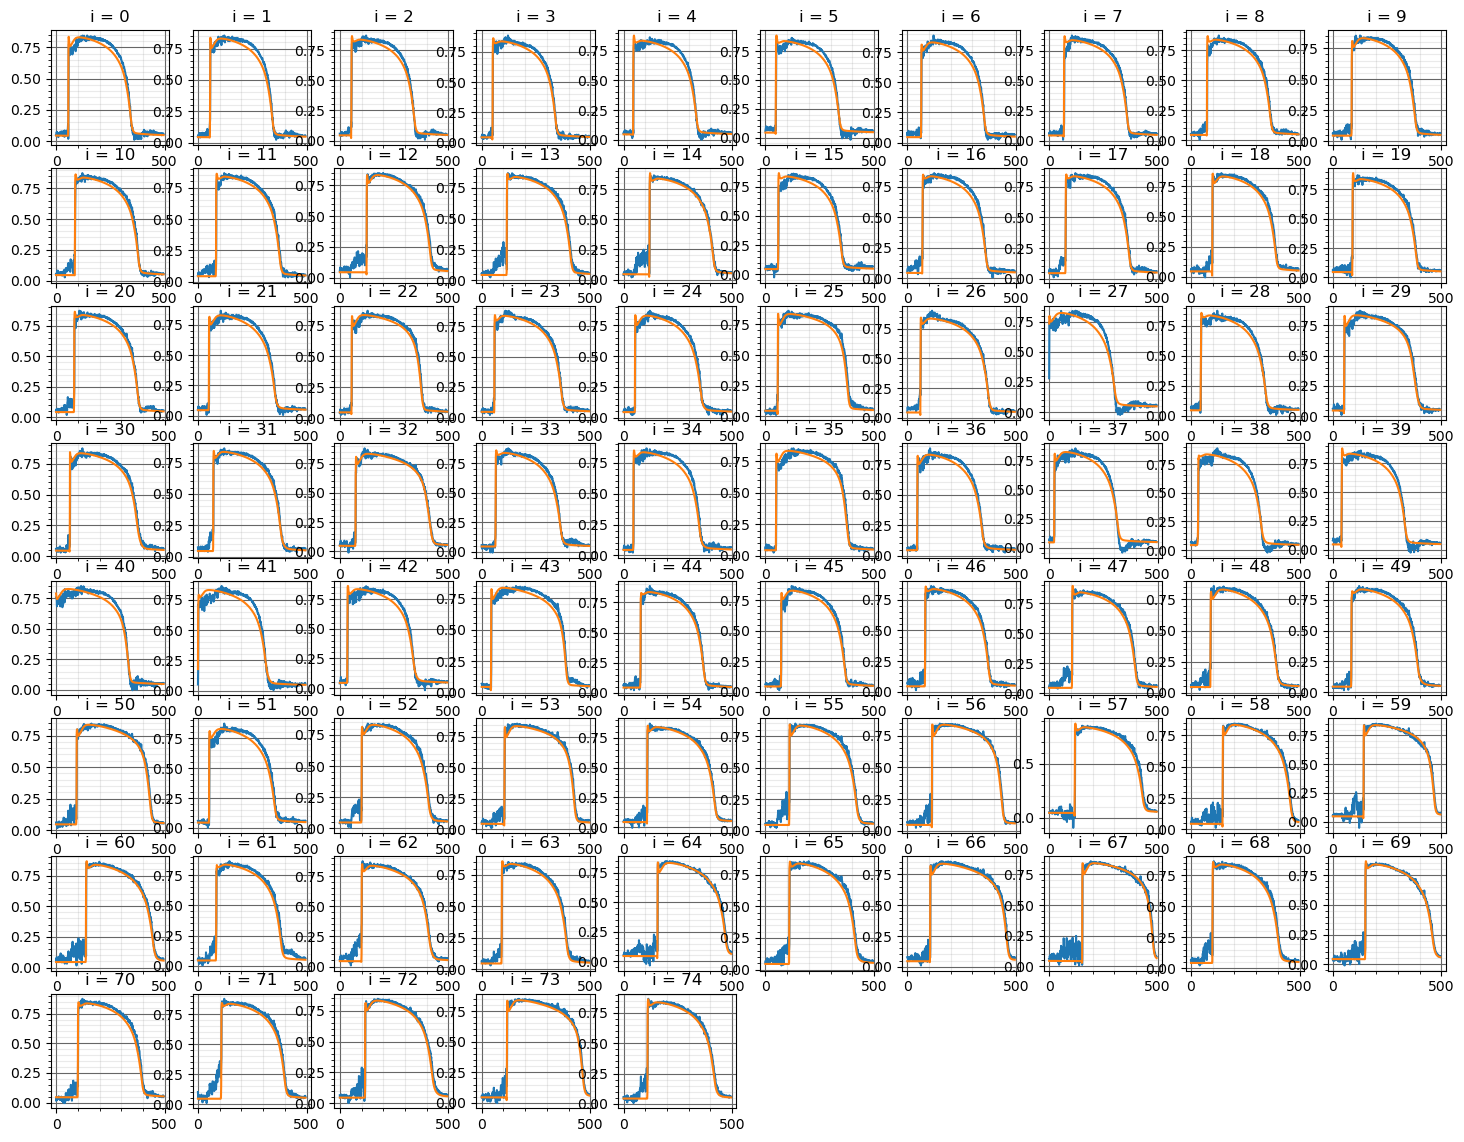

In [10]:
index = 10

pyplot.figure(figsize=(18, 14))

for count, i in enumerate(range(sequences.shape[2])):
    pyplot.subplot(8, 10, count + 1)
    pyplot.plot(sequences[index,:,i].cpu().numpy(), label ='Predicted data')
    pyplot.plot(tru_sequences[index,:,i].cpu().numpy(), label = 'True data')
    pyplot.title(f'i = {i}')
    pyplot.grid(visible=True, which='major', color='#666666', linestyle='-')
    pyplot.minorticks_on()
    pyplot.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# pyplot.plot(sequences[index,:,0].cpu().numpy())
# pyplot.plot(tru_sequences[index, :, 4])
pyplot.savefig('Transformer-final.png')
pyplot.show()
